# Részvényindexek EDA – Adathalmaz bemutatása

A 11. feladathoz tartozó adatot használom fel, a projektben a data mappába helyezvve.

Ebben a jegyzetfüzetben az `data/usa_stocks_data` könyvtárban található, nyilvánosan elérhető amerikai részvényindex-adatokat vizsgálom. A forrás tartalmazza a három nagy index (S&P 500, Dow Jones, Nasdaq-100) vállalati összetételét (`index/constituents`), az indexek historikus teljesítményét (`index/perf`), valamint több száz egyedi részvény napi árfolyam-sorozatát (`stock_prices`).

 - Forrás: a dataset az amerikai tőzsdéken jegyzett vállalatok nyilvános történeti adatait gyűjti össze CSV formában. A vállalati listák mezői (ticker, vállalatnév, szektor, iparág, alapítás éve stb.) közvetlenül felhasználhatók, míg az index- és árfolyam-fájlok időbélyeg + OHLCV struktúrát követnek.
 - Szerkezet: minden index/vállalati fájl első sora oszlopfejléceket tartalmaz, a rekordok soronkénti CSV formátumúak. A notebook során a `sp500.csv`-t használom elsődleges vállalati törzsadatként (mert naprakészebb és teljesebb metrikákat ad), míg az index teljesítményeket a `index/perf` almappából töltöm be `Date` indexeléssel.

A későbbi cellákban részletesen betöltöm, megtisztítom, majd EDA célokra elemezhető formátumba alakítom ezeket az adatokat.

In [2]:
# Szükséges könyvtárak importálása
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns

from pathlib import Path
import warnings
import re

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.seasonal import STL

import calendar

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

warnings.filterwarnings('ignore')

# Ábrázolási beállítások
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

random_state = 42

print("Könyvtárak importálva!")


Könyvtárak importálva!


Könyvtárak elérési útjai

In [3]:
data_path = Path('data/usa_stocks_data')
constituents_path = data_path / 'index/constituents'
idxperf_path = data_path / 'index/perf'
stock_prices_path = data_path / 'stock_prices'


# Adatbetöltés és Adattisztítás
## S&P 500
### Forrásfájl kiválasztása
Amint látható, S&P 500 indexhez 2 fájl is található. Ezeket megvizsgálom, és a jelenlegi állapotához közelebbit használom a továbbiakban

In [4]:
sp500_companies1 = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)
sp500_companies2 = pd.read_csv(constituents_path / 'sp500_companies.csv', header=0, index_col=0)

# Szimbólumok összehasonlítása
print(f"sp500_companies.csv rekordjainak száma: {len(sp500_companies1)}")
print(f"sp500.csv rekordjainak száma: {len(sp500_companies2)}")

sp500_symbols = set(sp500_companies1['Symbol'].unique())
sp500_companies_symbols = set(sp500_companies2['Symbol'].unique())

print(f"\nSP500.csv egyedi szimbólumok száma: {len(sp500_symbols)}")
print(f"SP500_companies.csv egyedi szimbólumok száma: {len(sp500_companies_symbols)}")

# Szimbólumok, amelyek csak az egyikben vannak
only_sp500 = sp500_symbols - sp500_companies_symbols
only_sp500_companies = sp500_companies_symbols - sp500_symbols
common_symbols = sp500_symbols & sp500_companies_symbols

print(f"\nKözös szimbólumok: {len(common_symbols)}")
print(f"Csak SP500-ban lévő szimbólumokszáma: {len(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok száma: {len(only_sp500_companies)}")

print(f"\nCsak SP500-ban lévő szimbólumok: {list(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok: {list(only_sp500_companies)}")



sp500_companies.csv rekordjainak száma: 503
sp500.csv rekordjainak száma: 501

SP500.csv egyedi szimbólumok száma: 503
SP500_companies.csv egyedi szimbólumok száma: 501

Közös szimbólumok: 500
Csak SP500-ban lévő szimbólumokszáma: 3
Csak SP500_companies-ben lévő szimbólumok száma: 1

Csak SP500-ban lévő szimbólumok: ['BX', 'ABNB', 'VLTO']
Csak SP500_companies-ben lévő szimbólumok: ['NWL']


Azt, hogy nem 500 rekordot tartalmaznak a fájlok az magyarázza, hogy bizonyos cégeknek több osztályú részvénye is része a rekordoknak, pl.: GOOG (Class B), GOOGL (Class A)

In [5]:
#Attribútumok vizsgálata
print(f"\nsp500.csv oszlopok:\n {list(sp500_companies1.columns)}\n")
print(f"\nsp500_companies.csv oszlopok:\n {list(sp500_companies2.columns)}\n")


sp500.csv oszlopok:
 ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded', 'Shares Outstanding']


sp500_companies.csv oszlopok:
 ['Symbol', 'Company Name', 'Industry', 'Sector', 'Founded', 'shares outstanding']



A rekordok számának viszgálatából kiderült, hogy egyik fájlban sincs duplikált adat.

Az sp500_companies.csv-ben található egyedül az NWL (Newell Brands Inc.), ami 2023 szeptember 18.-án kikerült az indexből.
Az sp500.csv-ben található egyedül 'ABNB', 'VLTO', 'BX', (Airbnb, Inc., Blackstone Inc., Veralto Corp.), amik 2023 szeptember 18.-án, és 2023 október 2.-án kerültek fel az indexre.
Ezek alapján az sp500.csv aktuálisabb információt tartalmaz.

Emellet az sp500.csv több információt tartalmaz a cégekről, és összes sp500_companies.csv-ben találhtó attribútum is jelen van.

Tehát innentől az sp500.csv-t használom az S&P 500 teljesítményének vizsgálatára.


In [6]:
sp500_companies = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)

### Adatok tisztítása

Ebben a fejezetben az
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre
 - Átnevezek bizonyos oszlopokat, hogy a többi index oszlopával konzisztens legyem
 - *Founded* adatokból kinyerem a pontos évet minden rekord esetén

In [7]:
text_cols = ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location']
for col in text_cols:
    sp500_companies[col] = sp500_companies[col].astype('string').str.strip()

#Indexek közötti konzisztencia érdekében
sp500_companies.rename(columns={'GICS Sector': 'Sector'}, inplace=True)
sp500_companies.rename(columns={'GICS Sub-Industry': 'Industry'}, inplace=True)

sp500_companies['Date added'] = pd.to_datetime(sp500_companies['Date added'], errors='coerce')
sp500_companies['CIK'] = sp500_companies['CIK'].astype(int)
sp500_companies['Shares Outstanding'] = sp500_companies['Shares Outstanding'].astype(int)

def extract_year(x):
    if pd.isna(x):
        return pd.NA
    years = [int(y) for y in re.findall(r'(\d{4})', str(x))]
    return min(years) if years else pd.NA

sp500_companies['Founded'] = sp500_companies['Founded'].apply(extract_year)
sp500_companies['Founded'] = pd.to_numeric(sp500_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata
Ebben a fejezetben:
 - Megvizsgálom, hogy hol hiányzok adat, és feltöltöm őket
 - Megvizsgálom a kategorikus változókat, és azt, hogy megfelel-e az iparban használtakkal

In [8]:
sp500_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   Sector                 503 non-null    string        
 3   Industry               502 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             491 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    int64         
dtypes: datetime64[ns](1), int64(3), string(5)
memory usage: 39.3 KB


Itt látható, hogy a Date added, és industry attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata:

 - Industry:

In [9]:
sp500_companies[sp500_companies["Industry"].isna()]

Symbol Security       Sector Industry   Headquarters Location Date added  \
468   VLTO  Veralto  Industrials     <NA>  Waltham, Massachusetts 2023-10-02   

         CIK  Founded  Shares Outstanding  
468  1967680     2023           246291005

Hiányzó adat: Environmental & Facilities Services, ennek hozzáadása

In [10]:
sp500_companies.loc[sp500_companies["Symbol"] == "VLTO", "Industry"] = "Environmental & Facilities Services"

 - Date added

In [11]:
sp500_companies[sp500_companies["Date added"].isna()]

Symbol               Security                  Sector  \
156      D        Dominion Energy               Utilities   
186     ES             Eversource               Utilities   
211    FCX       Freeport-McMoRan               Materials   
243    HUM                 Humana             Health Care   
404    ROK    Rockwell Automation             Industrials   
415    SRE          Sempra Energy               Utilities   
435   TROW          T. Rowe Price              Financials   
445    TXN      Texas Instruments  Information Technology   
457    USB              U.S. Bank              Financials   
482     WM       Waste Management             Industrials   
490     WY           Weyerhaeuser             Real Estate   
491    WHR  Whirlpool Corporation  Consumer Discretionary   

                                Industry    Headquarters Location Date added  \
156                   Electric Utilities       Richmond, Virginia        NaT   
186                      Multi-Utilities    Hartford, Connecticut        NaT   
211                               Copper         Phoenix, Arizona        NaT   
243                  Managed Health Care     Louisville, Kentucky        NaT   
404    Electrical Components & Equipment     Milwaukee, Wisconsin        NaT   
415                      Multi-Utilities    San Diego, California        NaT   
435     Asset Management & Custody Banks      Baltimore, Maryland        NaT   
445                       Semiconductors            Dallas, Texas        NaT   
457                    Diversified Banks   Minneapolis, Minnesota        NaT   
482  Environmental & Facilities Services           Houston, Texas        NaT   
490                         Timber REITs      Seattle, Washington        NaT   
491                 Household Appliances  Benton Harbor, Michigan        NaT   

         CIK  Founded  Shares Outstanding  
156   715957     1983           836772984  
186    72741     1966           349085992  
211   831259     1912          1433639982  
243    49071     1961           123906995  
404  1024478     1903           114860005  
415  1032208     1998           629307049  
435  1113169     1937           224295018  
445    97476     1930           907966030  
457    36104     1968          1556970036  
482   823768     1968           405059015  
490   106535     1900           730748029  
491   106640     1911            54817801

Hiányzó adatok hozzáadása:

In [12]:
missing_map = {
    "D":   "2016-11-30",
    "ES":  "2009-07-24",
    "FCX": "2011-07-01",
    "HUM": "2012-12-10",
    "ROK": "2000-03-12",
    "SRE": "2017-03-17",
    "TROW":"2019-07-29",
    "TXN": "2001-03-12",
    "USB": "1999-11-01",
    "WM":  "1998-08-31",
    "WY":  "1979-10-01",
    "WHR": "1959-04-01",
}

for sym, date in missing_map.items():
    sp500_companies.loc[(sp500_companies["Symbol"] == sym) & (sp500_companies["Date added"].isna()), "Date added"] = date

#### Kategórikus változók
 - Szektorok

In [13]:
print(f"Szektorok száma: {len(sp500_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {sp500_companies['Sector'].value_counts()}")

Szektorok száma: 11
Szektorok lebontása: Sector
Industrials               76
Financials                72
Health Care               65
Information Technology    64
Consumer Discretionary    52
Consumer Staples          38
Real Estate               31
Utilities                 30
Materials                 29
Communication Services    23
Energy                    23
Name: count, dtype: Int64


11 Szektorból található cég van az indexben, ami megfelel a GICS által meghatározott szektorok számának.

 - Iparágak

In [14]:
print(f"Iparágak száma: {len(sp500_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {sp500_companies['Industry'].value_counts()}")

Iparágak száma: 126
Iparágak lebontása: Industry
Health Care Equipment                           19
Semiconductors                                  15
Industrial Machinery & Supplies & Components    14
Application Software                            13
Electric Utilities                              13
                                                ..
Metal, Glass & Plastic Containers                1
Multi-Sector Holdings                            1
Computer & Electronics Retail                    1
Data Processing & Outsourced Services            1
Household Appliances                             1
Name: count, Length: 126, dtype: Int64


### S&P 500 teljesítményének betöltése

Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [15]:
#Date indexként használva
sp500_perf = pd.read_csv(idxperf_path / 'SP500_perf.csv', parse_dates=['Date'], header=0, index_col=0)


 - Típus konverziók

In [16]:
sp500_perf.index = pd.to_datetime(sp500_perf.index,utc=True, errors='coerce')
sp500_perf.index = sp500_perf.index.tz_convert("America/New_York")
sp500_perf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24060 entries, 1927-12-30 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24060 non-null  float64
 1   High          24060 non-null  float64
 2   Low           24060 non-null  float64
 3   Close         24060 non-null  float64
 4   Volume        24060 non-null  int64  
 5   Dividends     24060 non-null  float64
 6   Stock Splits  24060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


Az index és az össze attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

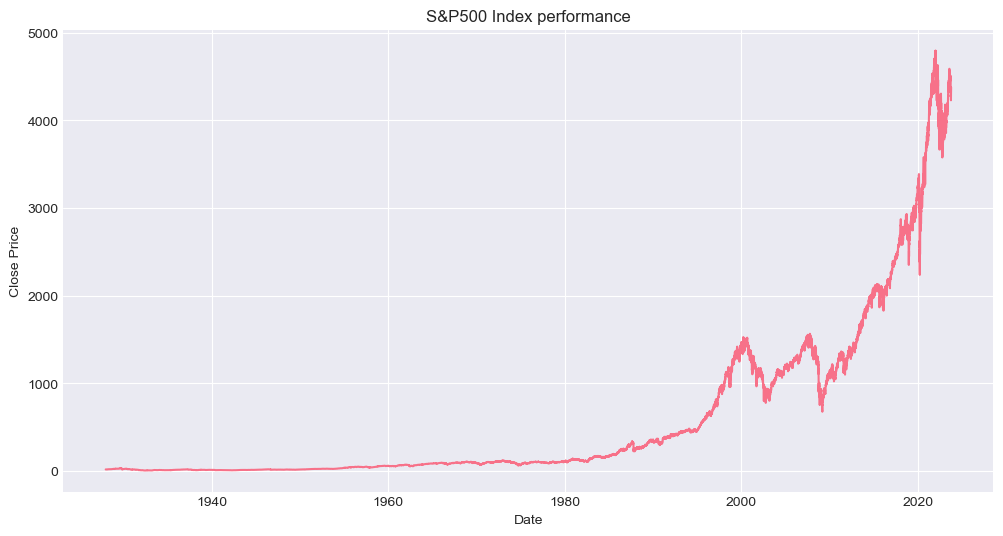

In [17]:
plt.plot(sp500_perf.index, sp500_perf["Close"])
plt.title("S&P500 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Nasdaq 100
### Adatok tisztítása

Ebben a fejezetben
 - Betöltöm az adatokat
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre


In [18]:
nasdaq100_companies = pd.read_csv(constituents_path / 'nasdaq100_companies.csv', header=0, index_col=0)

text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    nasdaq100_companies[col] = nasdaq100_companies[col].astype('string').str.strip()

nasdaq100_companies['Founded'] = pd.to_numeric(nasdaq100_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata

In [19]:
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    string 
 1   Company Name        101 non-null    string 
 2   Industry            101 non-null    string 
 3   Sector              101 non-null    string 
 4   Founded             89 non-null     float64
 5   shares outstanding  101 non-null    float64
dtypes: float64(2), string(4)
memory usage: 5.5 KB


Itt látható, hogy a Founded, attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata
 - Founded

In [20]:
nasdaq100_companies[nasdaq100_companies["Founded"].isna()]

Symbol             Company Name                        Industry  \
8    AVGO                 Broadcom                  Semiconductors   
24    HON  Honeywell International                   Conglomerates   
35   MDLZ   Mondelez International                   Confectioners   
45    CSX          CSX Corporation                       Railroads   
52   MNST         Monster Beverage       Beverages - Non-Alcoholic   
54     JD                   JD.com                 Internet Retail   
66     ON         ON Semiconductor                  Semiconductors   
68   SGEN                   Seagen                   Biotechnology   
69    EXC                   Exelon  Utilities - Regulated Electric   
75   IDXX       IDEXX Laboratories          Diagnostics & Research   
78    BKR     Baker Hughes Company  Oil & Gas Equipment & Services   
98   SIRI       Sirius XM Holdings                   Entertainment   

                    Sector  Founded  shares outstanding  
8               Technology      NaN        4.127360e+08  
24             Industrials      NaN        6.639610e+08  
35        Consumer Staples      NaN        1.360420e+09  
45             Industrials      NaN        2.006330e+09  
52        Consumer Staples      NaN        1.047520e+09  
54  Consumer Discretionary      NaN        1.573000e+09  
66              Technology      NaN        4.315290e+08  
68              Healthcare      NaN        1.876980e+08  
69               Utilities      NaN        9.952191e+08  
75              Healthcare      NaN        8.301240e+07  
78                  Energy      NaN        1.016650e+09  
98  Communication Services      NaN        3.842400e+09

Hiányzó adatok hozzáadása:

In [21]:
missing_map = {
    "AVGO": 1961,
    "HON":  1885,
    "MDLZ": 1903,
    "CSX":  1980,
    "MNST": 1935,
    "JD":   1998,
    "ON":   1999,
    "SGEN": 1998,
    "EXC":  2000,
    "IDXX": 1983,
    "BKR":  1908,
    "SIRI": 2008
}

for sym, date in missing_map.items():
    nasdaq100_companies.loc[(nasdaq100_companies["Symbol"] == sym) & (nasdaq100_companies["Founded"].isna()), "Founded"] = date

nasdaq100_companies['Founded'] = nasdaq100_companies['Founded'].astype(int)

#### Kategórikus változók
Ebben a fejezetben
 - Átnevezek bizonyos attribútumokat, hogy konzisztens legyen a többi index-szel
 - Összehasonlítom, a már feldolgozott, S&P 500-zal


- Szektorok:

In [22]:
#Konzisztencia érdekében
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Healthcare", "Health Care")
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Technology", "Information Technology")

print(f"Szektorok száma: {len(nasdaq100_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {nasdaq100_companies['Sector'].value_counts()}")

Szektorok száma: 10
Szektorok lebontása: Sector
Information Technology    37
Consumer Discretionary    15
Health Care               15
Communication Services    10
Industrials                9
Consumer Staples           7
Utilities                  4
Energy                     2
Financials                 1
Real Estate                1
Name: count, dtype: Int64


Itt már nem jelenik meg mind a 11 szektor, de ez azért van, mert míg az S&P 500 500 céget, a Nasdaq csak 100-at tartalmaz és tech-irányult, ezért a *Materials* szektorból nem tartalmaz céget.

Megfelelés ellenőrzése:

In [23]:
print(f"Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? "
      f"{set(nasdaq100_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")


Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? True 


 - Iparágak:

In [24]:
print(f"Iparágak száma: {len(nasdaq100_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {nasdaq100_companies['Industry'].value_counts()}")

Iparágak száma: 45
Iparágak lebontása: Industry
Semiconductors                         13
Software - Application                  9
Software - Infrastructure               7
Internet Retail                         5
Semiconductor Equipment & Materials     4
Drug Manufacturers - General            4
Biotechnology                           4
Utilities - Regulated Electric          3
Internet Content & Information          3
Beverages - Non-Alcoholic               3
Telecom Services                        3
Entertainment                           3
Medical Devices                         2
Diagnostics & Research                  2
Apparel Retail                          2
Staffing & Employment Services          2
Travel Services                         2
Discount Stores                         2
Auto Manufacturers                      2
Packaged Foods                          1
Health Information Services             1
Oil & Gas E&P                           1
Industrial Distribution     

Hasonló okokból itt sincs jelen az összes, S&P 500-nál megfigyelt iparág

### Nasdaq 100 teljesítményeének betöltése

Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [25]:
# Date indexként használva
nasdaq100_perf = pd.read_csv(idxperf_path / 'Nasdaq100_perf.csv', parse_dates=['Date'], header=0, index_col=0)

 - Típus konverziók

In [26]:
nasdaq100_perf.index = pd.to_datetime(nasdaq100_perf.index,utc=True, errors='coerce')
nasdaq100_perf.index = nasdaq100_perf.index.tz_convert("America/New_York")
nasdaq100_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9585 entries, 1985-10-01 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9585 non-null   float64
 1   High          9585 non-null   float64
 2   Low           9585 non-null   float64
 3   Close         9585 non-null   float64
 4   Volume        9585 non-null   int64  
 5   Dividends     9585 non-null   float64
 6   Stock Splits  9585 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.1 KB


Az index és az összes attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

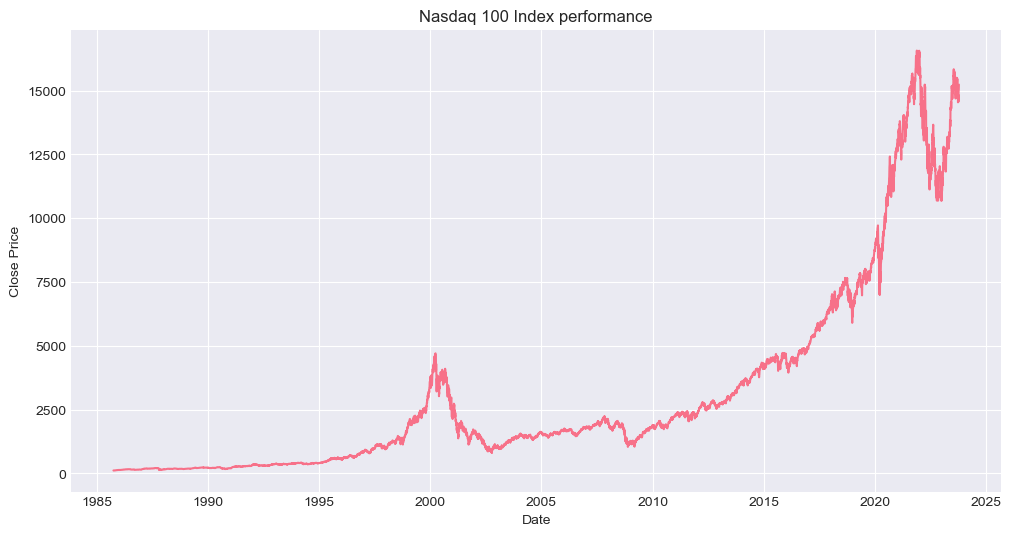

In [27]:
plt.plot(nasdaq100_perf.index, nasdaq100_perf["Close"])
plt.title("Nasdaq 100 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Dow Jones
### Adatok tisztítása

Ebben a fejezetben
 - Betöltöm az adatokat
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre

In [28]:
dowjones_companies = pd.read_csv(constituents_path / 'dowjones_companies.csv', header=0, index_col=0)

text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    dowjones_companies[col] = dowjones_companies[col].astype('string').str.strip()

dowjones_companies['Founded'] = pd.to_numeric(dowjones_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata

In [29]:
dowjones_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        30 non-null     string 
 1   Company Name  30 non-null     string 
 2   Industry      30 non-null     string 
 3   Sector        30 non-null     string 
 4   Founded       28 non-null     float64
dtypes: float64(1), string(4)
memory usage: 1.4 KB


Itt látható, hogy a Founded, attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata
 - Founded

In [30]:
dowjones_companies[dowjones_companies["Founded"].isna()]

Symbol             Company Name       Industry       Sector  Founded
22    HON  Honeywell International  Conglomerates  Industrials      NaN
28    DOW                 Dow Inc.      Chemicals    Materials      NaN

Hiányzó adatok hozzáadása:

In [31]:
missing_map = {
    "HON": 1906,
    "DOW":  1897
}

for sym, date in missing_map.items():
    dowjones_companies.loc[(dowjones_companies["Symbol"] == sym) & (dowjones_companies["Founded"].isna()), "Founded"] = date

dowjones_companies['Founded'] = dowjones_companies['Founded'].astype(int)

#### Kategórikus változók
Ebben a fejezetben
 - Átnevezek bizonyos attribútumokat, hogy konzisztens legyen a többi index-szel
 - Összehasonlítom, a már feldolgozott, S&P 500-zal


 - Szektorok

In [32]:
#Konzisztencia érdekében
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Healthcare", "Health Care")
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Technology", "Information Technology")

print(f"Szektorok száma: {len(dowjones_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {dowjones_companies['Sector'].value_counts()}")

Szektorok száma: 9
Szektorok lebontása: Sector
Information Technology    6
Financials                5
Health Care               5
Industrials               4
Consumer Staples          3
Consumer Discretionary    3
Communication Services    2
Energy                    1
Materials                 1
Name: count, dtype: Int64


Itt már nem jelenik meg mind a 11 szektor, de ez azért van, mert ez az index már csak 30 cégből áll.

Megfelelés ellenőrzése:

In [33]:
print(f"Dow Jones Industry-k megfelelnek az S&P 500 szektorainak? "
      f"{set(dowjones_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")

Dow Jones Industry-k megfelelnek az S&P 500 szektorainak? True 


 - Iparágak

In [34]:
print(f"Iparágak száma: {len(dowjones_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {dowjones_companies['Industry'].value_counts()}")

Iparágak száma: 26
Iparágak lebontása: Industry
Drug Manufacturers - General           3
Credit Services                        2
Conglomerates                          2
Consumer Electronics                   1
Entertainment                          1
Chemicals                              1
Insurance - Property & Casualty        1
Capital Markets                        1
Aerospace & Defense                    1
Information Technology Services        1
Telecom Services                       1
Farm & Heavy Construction Machinery    1
Footwear & Accessories                 1
Semiconductors                         1
Restaurants                            1
Software - Infrastructure              1
Software - Application                 1
Communication Equipment                1
Beverages - Non-Alcoholic              1
Home Improvement Retail                1
Oil & Gas Integrated                   1
Household & Personal Products          1
Banks - Diversified                    1
Discount 

### Dow Jones teljesítményének betöltése
Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [35]:
#Date indexként használva
dowjones_perf = pd.read_csv(idxperf_path / 'Dow_Jones_perf.csv', parse_dates=['Date'], header=0, index_col=0)

 - Típus konverziók

In [36]:
dowjones_perf.index = pd.to_datetime(dowjones_perf.index, utc=True, errors="coerce")
dowjones_perf.index = dowjones_perf.index.tz_convert("America/New_York")
dowjones_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8004 entries, 1992-01-02 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8004 non-null   float64
 1   High          8004 non-null   float64
 2   Low           8004 non-null   float64
 3   Close         8004 non-null   float64
 4   Volume        8004 non-null   int64  
 5   Dividends     8004 non-null   float64
 6   Stock Splits  8004 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 500.2 KB


Az index és az összes attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

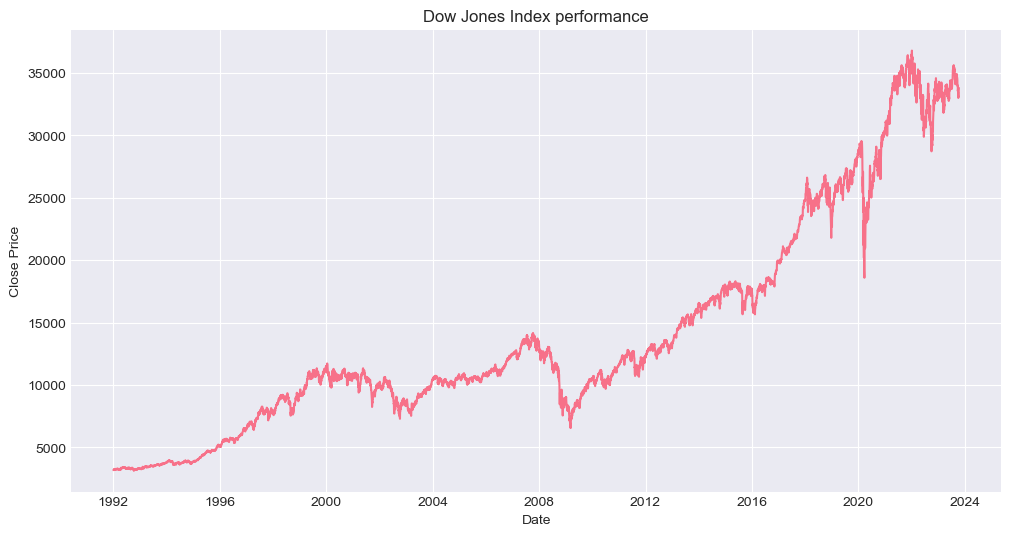

In [37]:
plt.plot(dowjones_perf.index, dowjones_perf["Close"])
plt.title("Dow Jones Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Inflációs adatok
Ebben a fejezetben
 - Betöltöm az adatokat
 - Elforgatom a táblázatot, hogy kezelhetőbb legyen
 - Oszlopok típusát állítom be helyesre

In [38]:
inflation_temp = pd.read_csv(data_path / 'usd_inflation.csv', parse_dates=['Year'], header=0)
inflation_temp.head()

Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct  \
0 1914-01-01   2.0   1.0   1.0   0.0   2.1   1.0   1.0   3.0   2.0   1.0   
1 1915-01-01   1.0   1.0   0.0   2.0   2.0   2.0   1.0  -1.0  -1.0   1.0   
2 1916-01-01   3.0   4.0   6.1   6.0   5.9   6.9   6.9   7.9   9.9  10.8   
3 1917-01-01  12.5  15.4  14.3  18.9  19.6  20.4  18.5  19.3  19.8  19.5   
4 1918-01-01  19.7  17.5  16.7  12.7  13.3  13.1  18.0  18.5  18.0  18.5   

    Nov   Dec   Ave  
0   1.0   1.0   1.0  
1   1.0   2.0   1.0  
2  11.7  12.6   7.9  
3  17.4  18.1  17.4  
4  20.7  20.4  18.0

### Adatok tisztítása
 - Elforgatás

Felül látható, hogy 1 sor = 1 év 12 hónapra és azok átlaga. Ez megjelenítésre alkalmatlan, tehát elforgatom úgy, hogy 1 sorban legyen 1 hónap inflációs adata.
Egy sorban az adat dátuma (indexként), és maga az adat lesz.

In [39]:
inflation = inflation_temp.melt(
    id_vars=["Year"],
    value_vars=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    var_name="Month",
    value_name="Inflation"
)
inflation["Year"] = pd.to_datetime(inflation["Year"]).dt.year

# dátum aggregálása egy attribútumba
inflation["Date"] = pd.to_datetime(inflation["Year"].astype(str) + "-" + inflation["Month"], format="%Y-%b")
inflation = inflation[["Date","Inflation"]].sort_values("Date").reset_index(drop=True)
inflation = inflation.set_index("Date")

# azon sorok elhagyása amikhez nincs inflációs adat (2023 vége)
inflation = inflation.dropna(subset=["Inflation"])
inflation.index = inflation.index.tz_localize('America/New_York')

inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1316 entries, 1914-01-01 00:00:00-05:00 to 2023-08-01 00:00:00-04:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  1316 non-null   float64
dtypes: float64(1)
memory usage: 20.6 KB


Az infláció és az index attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

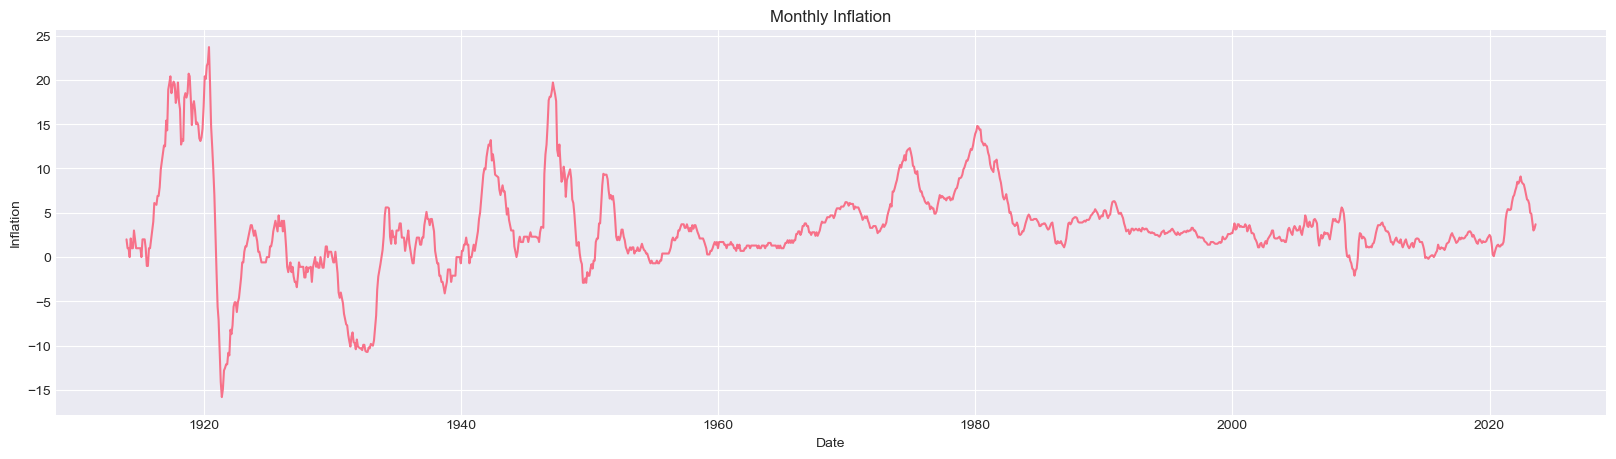

In [40]:
plt.figure(figsize=(20,5))
plt.plot(inflation.index, inflation["Inflation"])
plt.title("Monthly Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.show()

## Részvények

Ebben a fejezetben
 - Ismertetem az adatok struktúráját
 - Cikusban betöltöm az összes részvényt

### Teszt egy részvényen

In [41]:
teststock = pd.read_csv('data/usa_stocks_data/stock_prices/TSLA.csv', header=0, index_col=0)
teststock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3345 entries, 2010-06-29 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3345 non-null   float64
 1   High          3345 non-null   float64
 2   Low           3345 non-null   float64
 3   Close         3345 non-null   float64
 4   Volume        3345 non-null   int64  
 5   Dividends     3345 non-null   float64
 6   Stock Splits  3345 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 209.1+ KB


Látható, hogy az adattípusok, az indexen kívül, megfelelnek az elvártaknak, és nem hiányzik adat

 - Típus konverziók

In [42]:
teststock.index = pd.to_datetime(teststock.index, utc=True, errors="coerce")
teststock.index = teststock.index.tz_convert("America/New_York")
teststock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3345 entries, 2010-06-29 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3345 non-null   float64
 1   High          3345 non-null   float64
 2   Low           3345 non-null   float64
 3   Close         3345 non-null   float64
 4   Volume        3345 non-null   int64  
 5   Dividends     3345 non-null   float64
 6   Stock Splits  3345 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 209.1 KB


### Összes részvény adat betöltése

Ebben a fejezetben az összes részvény adatát betöltöm
   - *stocks* tömb: Összes betöltött részvény szimbóluma
   - *prices* dictionary: összes részvény adata, kulcs a részvény szimbóluma

In [43]:
folder = Path("data/usa_stocks_data/stock_prices/")

prices = {}
stocks = []

for csv_file in folder.glob("*.csv"):
    symbol = csv_file.stem  
    df = pd.read_csv(csv_file, header=0, index_col=0)

    df.index = pd.to_datetime(df.index, utc=True, errors="coerce")
    df.index = df.index.tz_convert("America/New_York")

    stocks.append(symbol)
    prices[symbol] = df

- Ellenőrzés

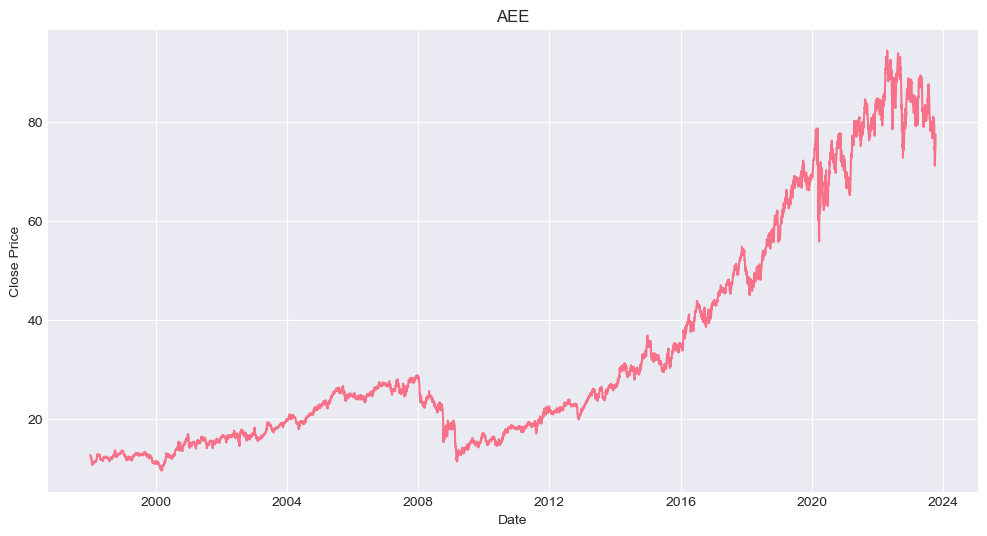

In [44]:
current_stock = stocks[13]
plt.plot(prices[current_stock].index, prices[current_stock]["Close"])
plt.title(current_stock)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


# Adatok vizsgálata

Ebben a fejezetben az EDA utolsó lépései következnek, a betöltött adatok alapvető tulajdonságainak vizsgálata

## Idősorok vizsgálata

Megvizsgálom, hogy az adatok milyen részletességgel és meddigre visszamenőleg állnak rendelkezésre adatok
### Indexek

In [55]:
indeces = {
    'S&P 500': sp500_perf,
    'Nasdaq 100': nasdaq100_perf,
    'Dow Jones': dowjones_perf
}
data_list = []

for name, idx in indeces.items():
    start = idx.index.min().date()
    end = idx.index.max().date()
    duration = round((end - start).days / 365, 1)
    delta = idx.index.to_series().diff().value_counts().sort_index()


    data_list.append({
        'Index neve': name,
        'Kezdet': start,
        'Vége': end,
        'Időtartam (év)': duration,
        'Adatpontok száma': len(idx),
        'Részletesség (nap)': min(delta)
    })

df_summary = pd.DataFrame(data_list)
df_summary.set_index('Index neve', inplace=True)

display(df_summary)

Kezdet        Vége  Időtartam (év)  Adatpontok száma  \
Index neve                                                             
S&P 500     1927-12-30  2023-10-11            95.8             24060   
Nasdaq 100  1985-10-01  2023-10-11            38.1              9585   
Dow Jones   1992-01-02  2023-10-11            31.8              8004   

            Részletesség (nap)  
Index neve                      
S&P 500                      1  
Nasdaq 100                   1  
Dow Jones                    1

Látható, hogy az összes index napi részletességgel van jelen, az indexek közül, pedig az S&P 500 messze a legrégebbi, majd ezt a 80-as években bejegyzett Nasdaq 100, és a 90-es években létrehozott Dow Jones követi.

### Részvények

Összesen 1 különböző részletesség van az adatokban : [1] (nap)


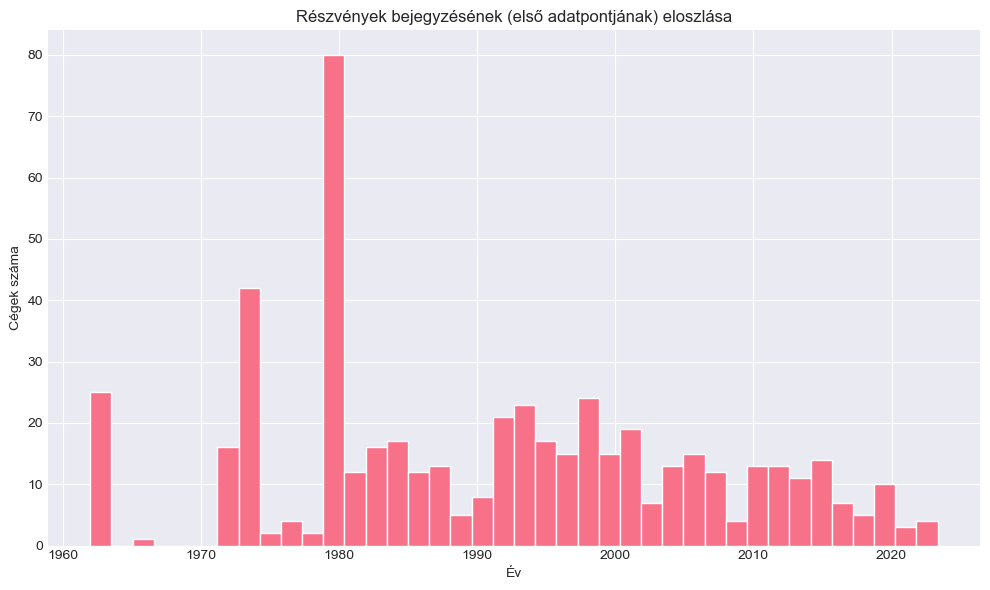

In [63]:
ipo = []
deltas = set()

for ticker, idx in prices.items():
    if not idx.empty:
        ipo.append(idx.index.min())

        # Részletesség (leggyakoribb időköz) meghatározása
        delta = idx.index.to_series().diff().value_counts()
        most_frequent_delta = delta.idxmax().days
        deltas.add(most_frequent_delta)

print(f"Összesen {len(deltas)} különböző részletesség van az adatokban : {list(deltas)} (nap)")

#Hisztogram
plt.figure(figsize=(10, 6))
plt.hist(ipo, bins=40)

plt.title('Részvények bejegyzésének (első adatpontjának) eloszlása')
plt.xlabel('Év')
plt.ylabel('Cégek száma')

plt.tight_layout()
plt.show()

## Szektorok eloszlása

Itt megvizsgálom a szektorokban található cégek számát, ami a későbbi klaszterezésnél fontos lehet.


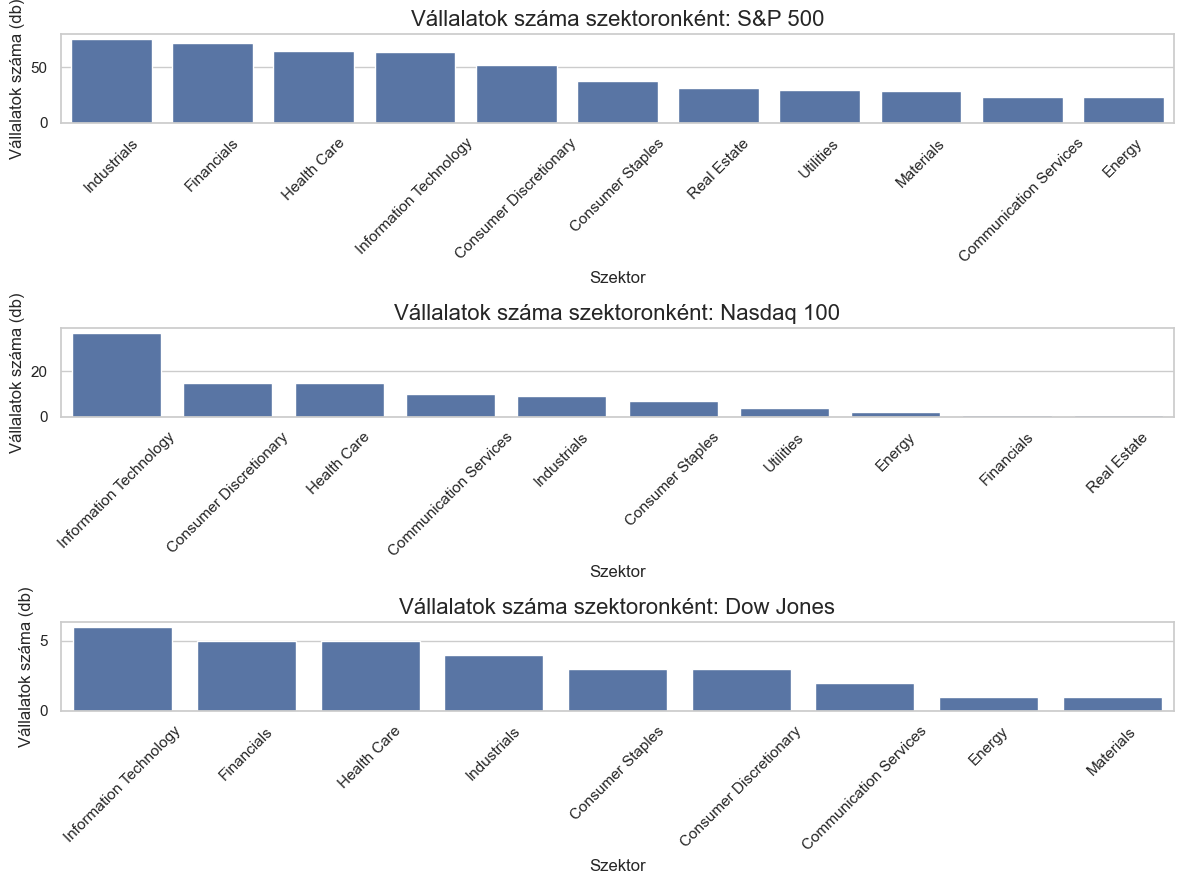

In [72]:
indeces_constituents = {
    'S&P 500': sp500_companies,
    'Nasdaq 100': nasdaq100_companies,
    'Dow Jones': dowjones_companies
}

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

for i, (name, idx) in enumerate(indeces_constituents.items()):
    sector_counts = idx['Sector'].value_counts().sort_values(ascending=False)
    sns.barplot(
        x=sector_counts.index,
        y=sector_counts.values,
        ax=axs[i]
    )
    axs[i].set_title(f"Vállalatok száma szektoronként: {name}", fontsize=16)
    axs[i].set_xlabel('Szektor')
    axs[i].set_ylabel('Vállalatok száma (db)')
    axs[i].tick_params(axis='x', rotation=45)

# Az átfedések elkerülése
plt.tight_layout()
plt.show()

Megfigyelések:

Nasdaq-100: Az ábrán látható, hogy a Nasdaq-100 indexet az Information Technology szektor dominálja.

S&P 500: Az S&P 500 esetében sokkal egyenletesebb a szektorok eloszlása. Ez indokolja, hogy miért ezt az indexet tekintjük a piac általános "benchmarkjának".

Dow Jones korlátai: A Dow Jones mindössze 30 vállalatot tartalmaz, így itt bizonyos szektorok (pl. Real Estate vagy Utilities) teljesen hiányozhatnak. Ezért a klaszterezési algoritmusoknál a Dow Jones adataitól várhatjuk a legkevesebb "zajt", de a legkisebb statisztikai reprezentativitást is

## Indexek hozama

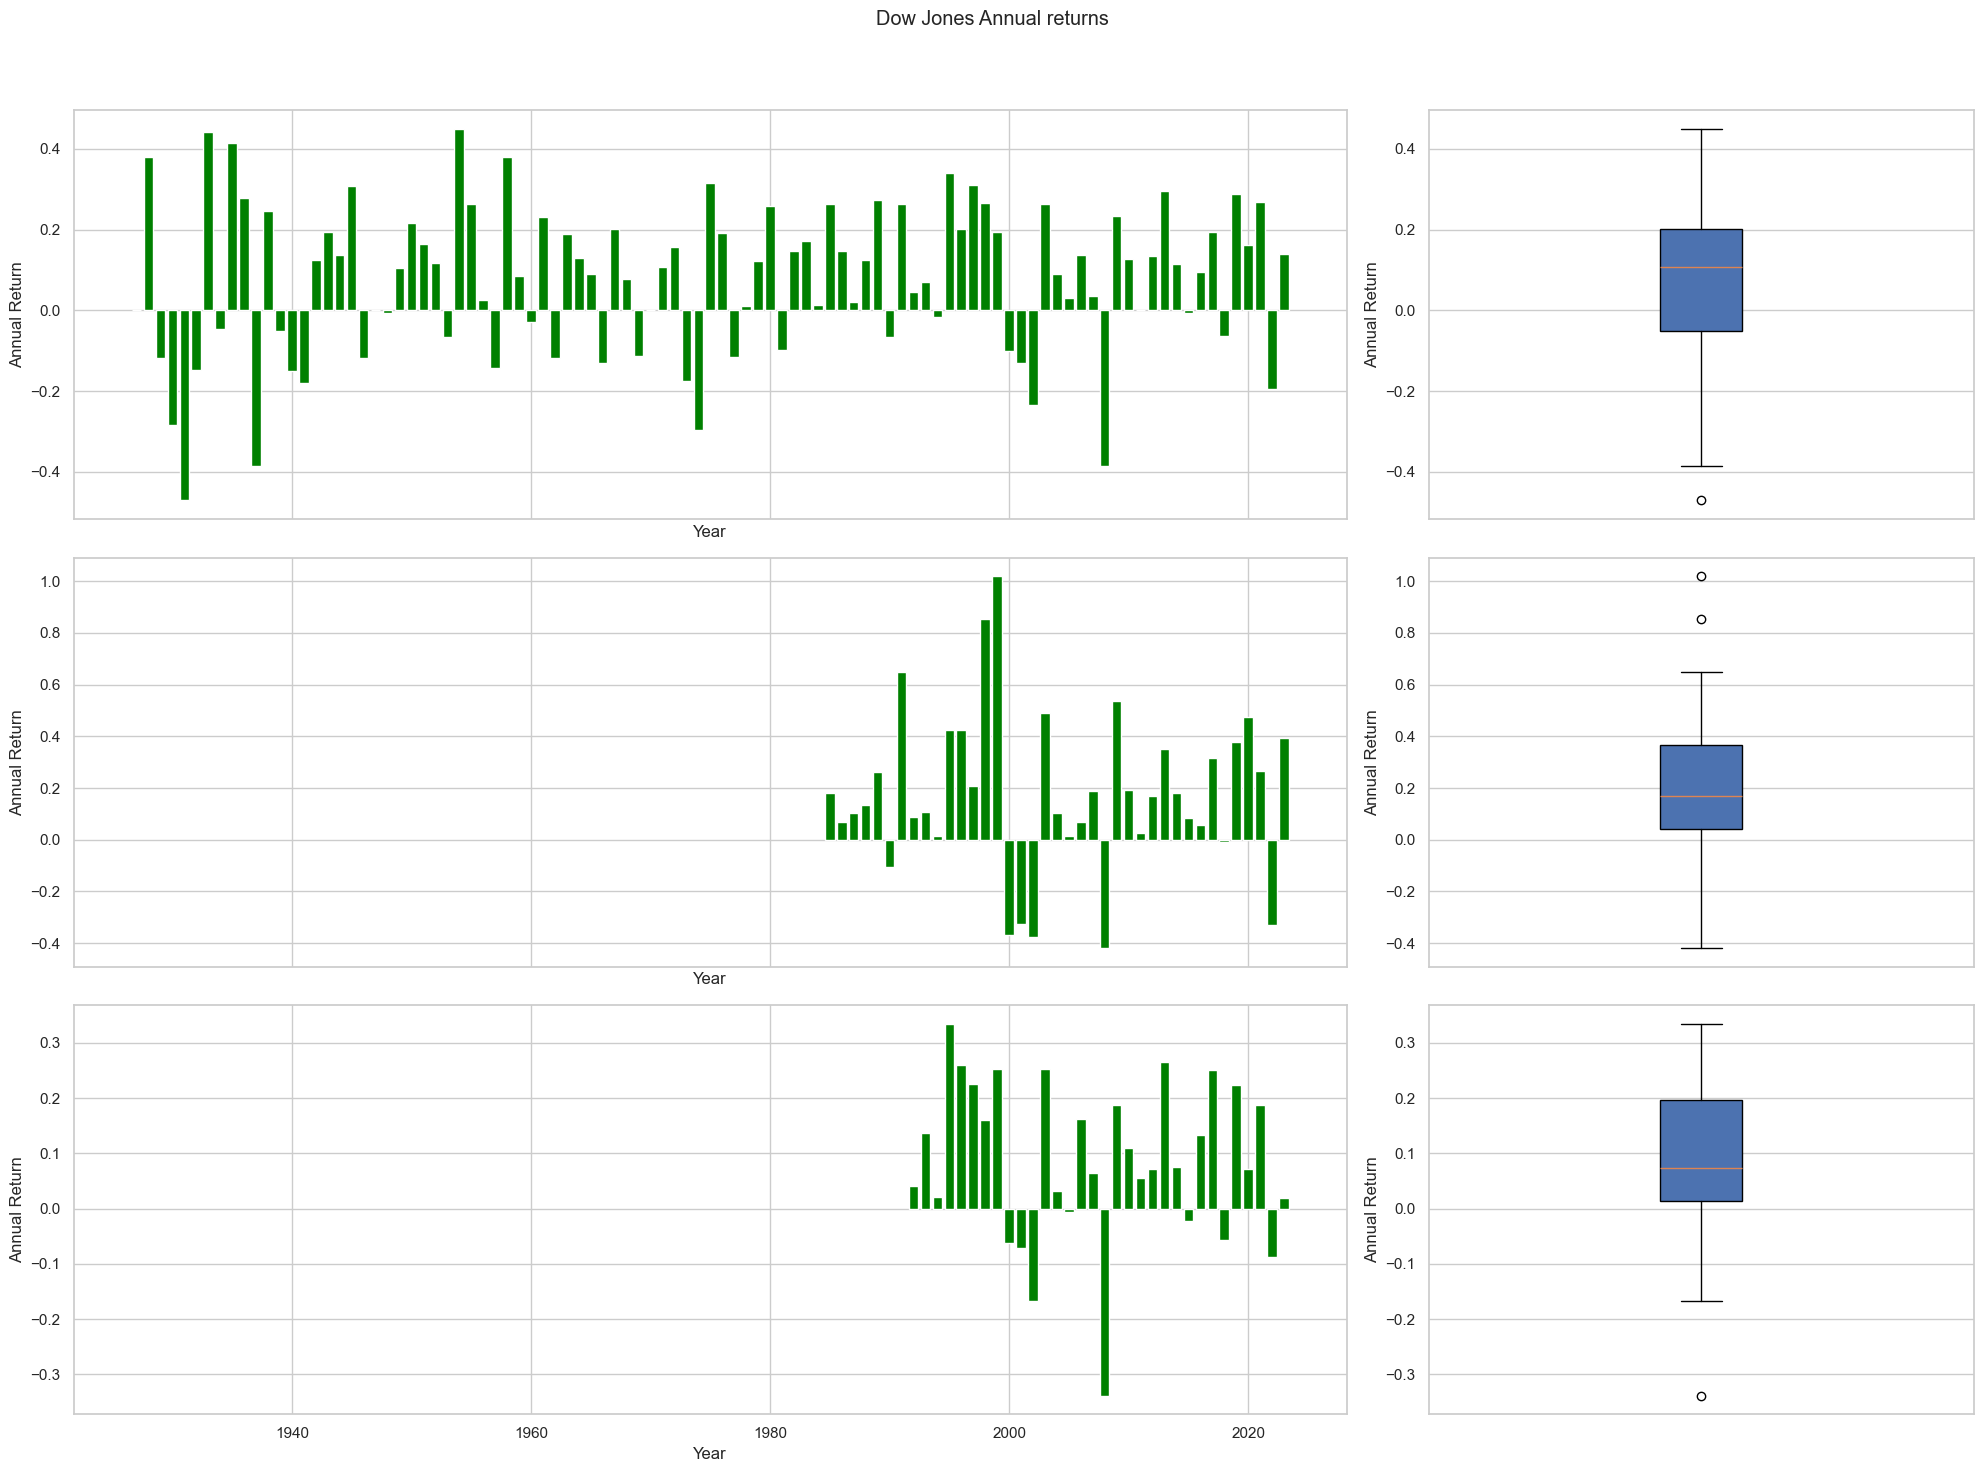

In [73]:
fig, axs = plt.subplots(3, 2, figsize=(20,15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
for i, (name, idx) in enumerate(indeces.items()):
    idx['Return'] = idx['Close'].pct_change()
    annual_return = (1 + idx['Return']).resample('Y').prod() - 1


    fig.suptitle(f"{name} Annual returns")

    axs[i,0].bar(annual_return.index.year, annual_return.values, color='green')
    axs[i,0].set_xlabel("Year")
    axs[i,0].set_ylabel("Annual Return")
    axs[i,0].grid(True, axis='y')

    axs[i,1].boxplot(annual_return.values, vert=True, patch_artist=True)
    axs[i,1].set_ylabel("Annual Return")
    axs[i,1].set_xticks([])
    axs[i,1].grid(True, axis='y')

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

Általános tendenciák:
- A három index hosszú távon pozitív hozamot mutat, bár jelentős évenkénti ingadozásokkal.
- A boxplotok mutatják, hogy az éves hozamok eloszlása aszimmetrikus: több pozitív év van, mint negatív, ami a részvénypiac hosszú távú növekedési trendjét tükrözi.

Index-specifikus megfigyelések:
- S&P 500: A leghosszabb idősorral rendelkezik (1927-től), így tartalmazza a legtöbb történelmi eseményt (pl. 1929-es válság, olaj-válság, 2008-as pénzügyi válság). A volatilitás a boxplot alapján viszonylag stabil.
- Nasdaq 100: Technológiai orientációja miatt általában magasabb volatilitást mutat, és gyakran erősebb növekedési periódusokat mutat (pl. dot-com buborék, 2020-as tech rally).
- Dow Jones: A legrövidebb idősorral rendelkezik (1992-től), de a 30 nagyvállalat összetétele miatt általában stabilabb hozamokat mutat.

Kockázati tényezők:
- A negatív évek (pl. 2008, 2022) mindhárom indexnél egyértelműen láthatók, és gyakran makrogazdasági válságokhoz köthetők.


## Legmagasabb és legalacsonyabb hozamú évek


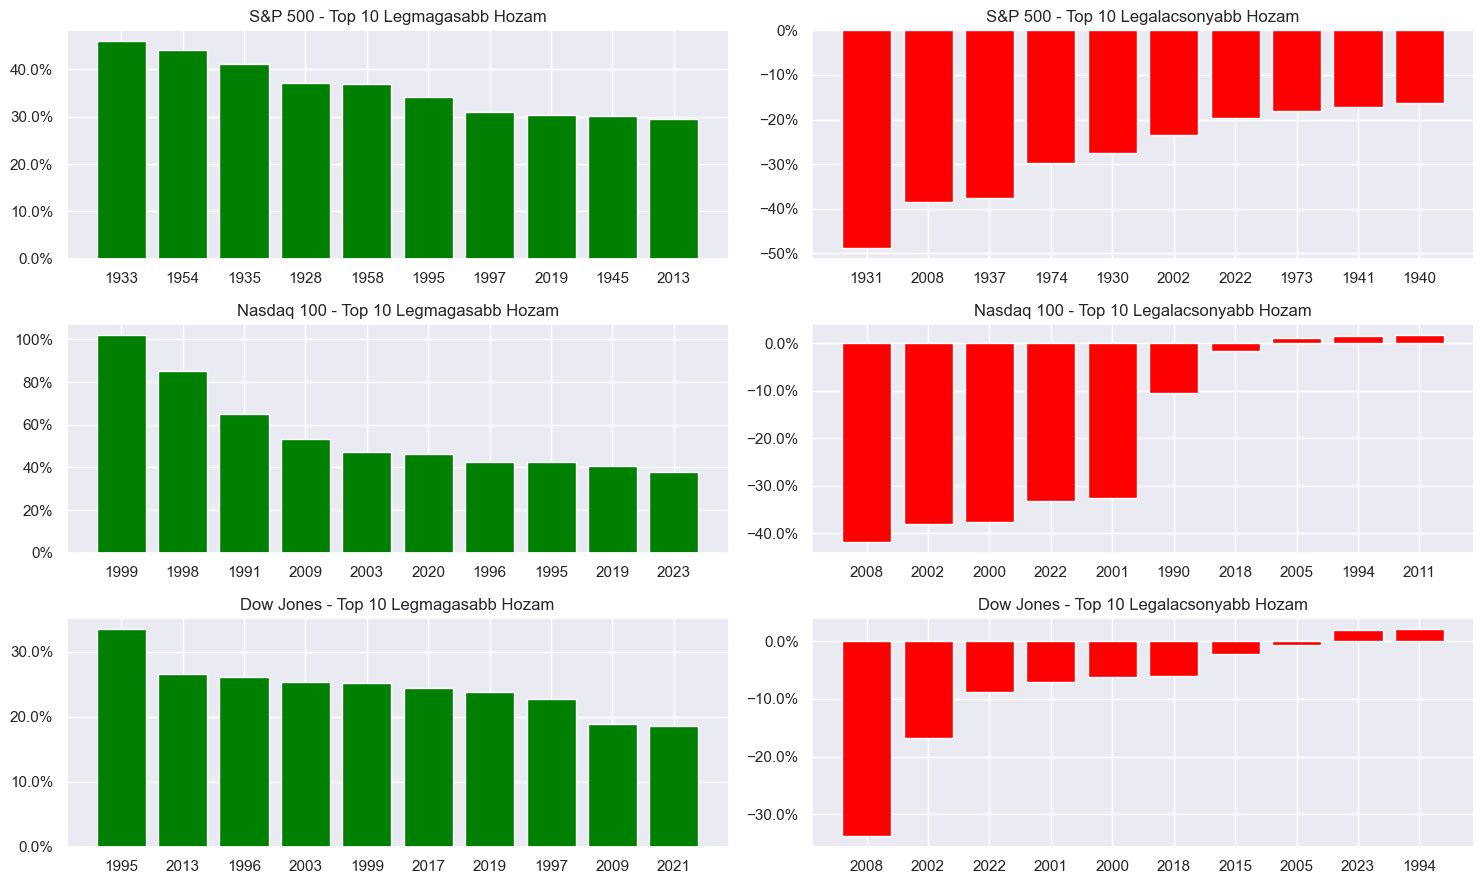

In [92]:
top_n = 10
yearly_return = {}

for name, idx in indeces.items():
    annual_return = {}
    for year, group in idx.groupby(idx.index.year):
        open_price = group.iloc[0]['Open'] if group.iloc[0]['Open'] != 0 else group.iloc[0]['Close']
        close_price = group.iloc[-1]['Close']

        if pd.notna(open_price) and pd.notna(close_price):
            annual_return[year] = (close_price - open_price) / open_price

    yearly_return[name] = pd.Series(annual_return).dropna()

fig, axs = plt.subplots(3, 2, figsize=(15, 9))

if len(yearly_return) == 1:
    axs = [axs]

for i, (idx_name, returns) in enumerate(yearly_return.items()):
    top_highest = returns.nlargest(top_n).sort_values(ascending=False)
    top_lowest = returns.nsmallest(top_n).sort_values(ascending=True)

    # Legjobbak
    ax_high = axs[i][0]
    ax_high.bar(top_highest.index.astype(str), top_highest.values, color='green')
    ax_high.set_title(f"{idx_name} - Top {top_n} Legmagasabb Hozam")
    ax_high.grid(True)
    ax_high.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Legrosszabbak
    ax_low = axs[i][1]
    ax_low.bar(top_lowest.index.astype(str), top_lowest.values, color='red')
    ax_low.set_title(f"{idx_name} - Top {top_n} Legalacsonyabb Hozam")
    ax_low.grid(True)
    ax_low.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout()
plt.show()

Az ábrán látható, hogy a Nasdaq 100 a legvolatilisebb (100% feletti csúcs és sűrűbb -30% alatti évek), míg a Dow Jones a legstabilabb index. A legrosszabb évek listáján több pozitív hozamú év is szerepel, ami jelzi, hogy a tőzsdén a növekedés az uralkodó irány. A grafikonokon jól láthatóak a történelmi válságok (világválság, dotcom crash, 2008-as gazdasági válság) egységesen negatív hatásai.

## Inflációs adatok eloszlása

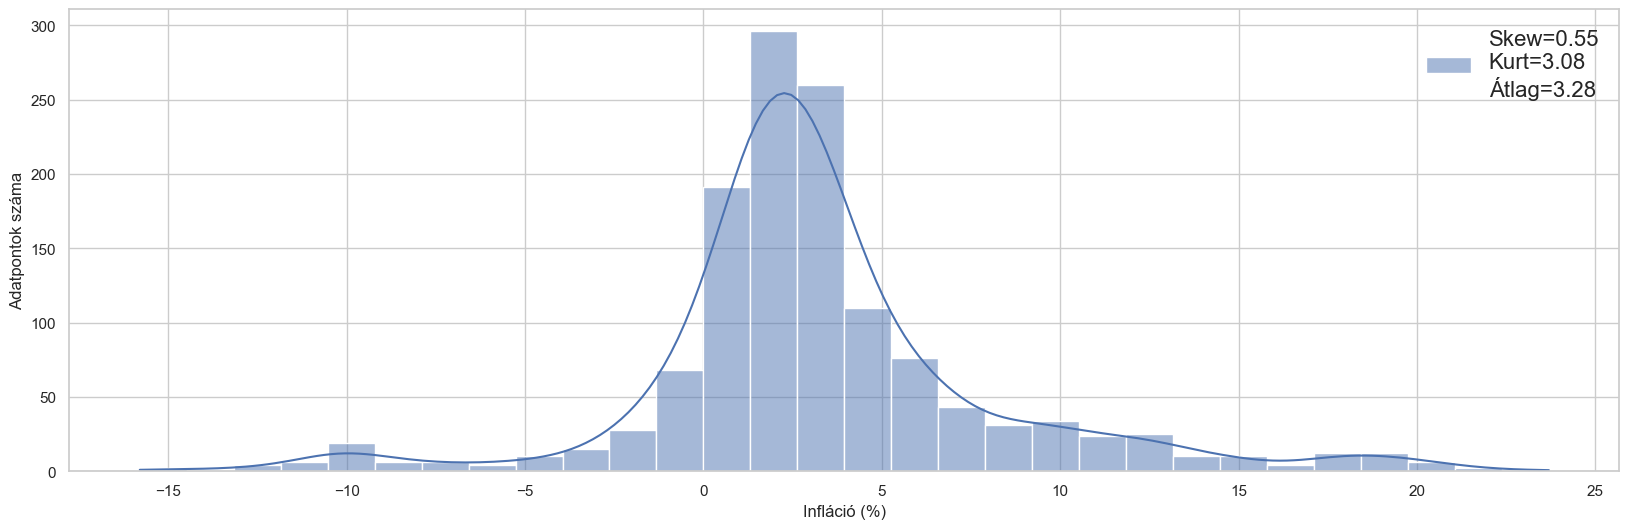

In [79]:
skew = inflation['Inflation'].skew()
kurt = inflation['Inflation'].kurtosis()
mean = inflation['Inflation'].mean()

plt.figure(figsize=(20,6))
sns.histplot(inflation['Inflation'], bins=30, kde=True, label=f'Skew={skew:.2f}\nKurt={kurt:.2f}\nÁtlag={mean:.2f}')
plt.xlabel("Infláció (%)")
plt.ylabel("Adatpontok száma")
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

Ferdeség: 0.55 : A pozitív ferdeség azt jelenti, hogy az eloszlás enyhén jobbra húzódik, azaz a leggyakoribb inflációs értékek a medián alatt helyezkednek el, és az eloszlásnak van egy hosszabb "farka" a magas infláció irányába, tehát a ritkán előforduló, extrém magas inflációs sokkok valószínűbbek voltak, mint az extrém deflációs sokkok.

Csúcsosság: 3.08 :  A 3.08 érték azt jelenti, hogy az eloszlás nagyon közel áll a normál eloszláshoz. Az enyhén 3 feletti érték azt jelzi, hogy az infláció a középpontban enyhén csúcsosabb, és a szélső értékek is enyhén gyakoribbak, mint amit a normál eloszlás feltételezne.

# Statisztikák
### Havi átlagos volatilitás

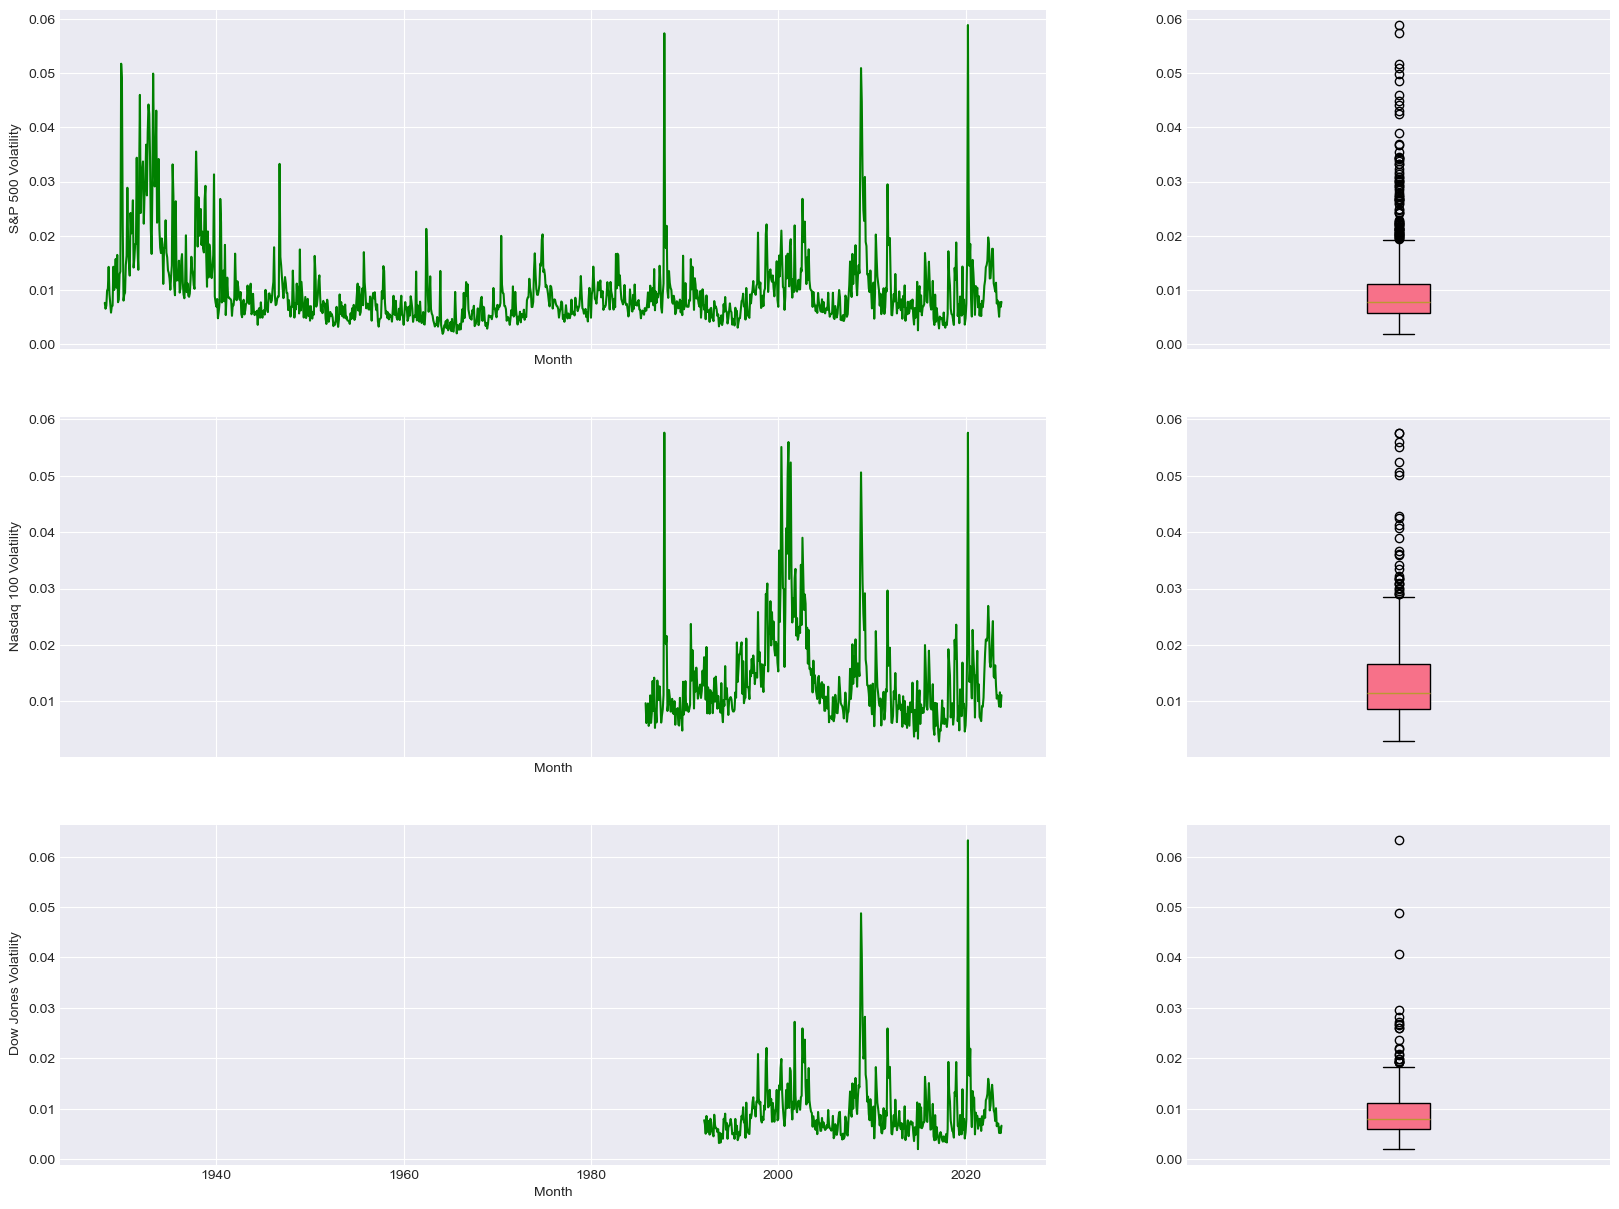

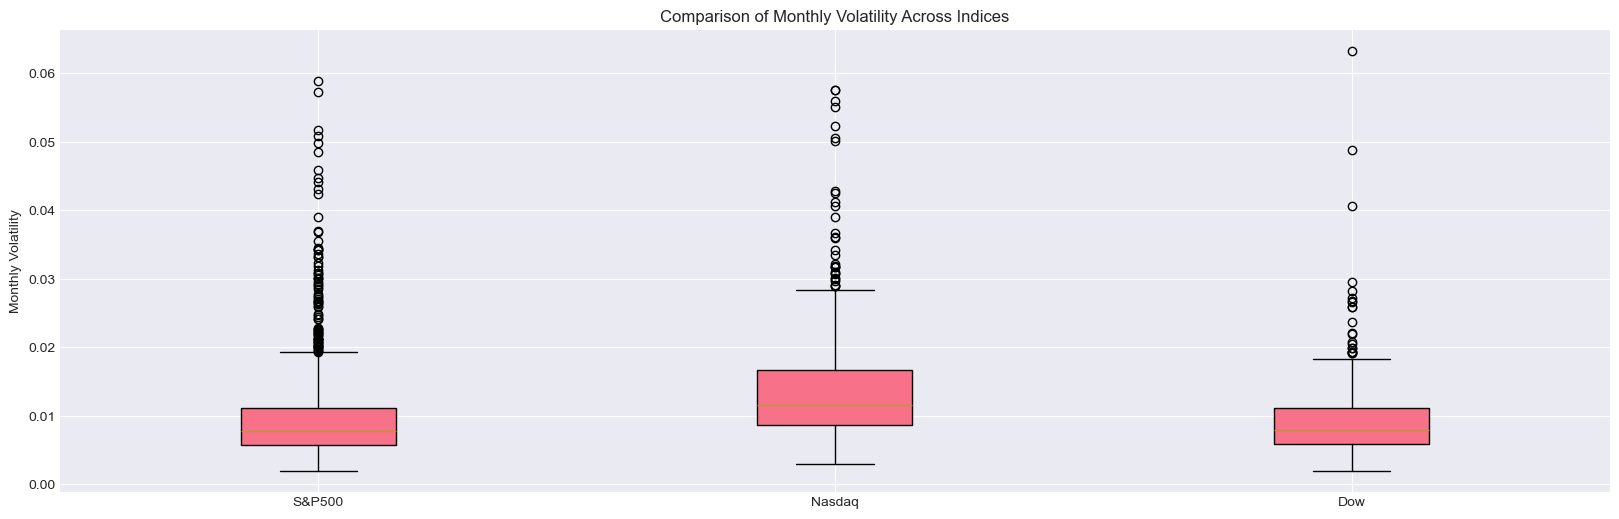

In [175]:
fig, axs = plt.subplots(3, 2, figsize=(20,15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')

for i, (name, idx) in enumerate(indeces.items()):
    monthly_vol = idx['Return'].resample('M').std()
    monthly_vol = monthly_vol.dropna()


    axs[i, 0].plot(monthly_vol.index, monthly_vol.values, color='green')
    axs[i, 0].set_xlabel("Month")
    axs[i, 0].set_ylabel(f" {name} Volatility")
    axs[i, 0].grid(True, axis='y')

    axs[i, 1].boxplot(monthly_vol.values, vert=True, patch_artist=True)
    axs[i, 1].set_xticks([])
    axs[i, 1].grid(True, axis='y')
    
plt.show()

monthly_vols = {
    'S&P500': sp500_perf['Return'].resample('M').std().dropna(),
    'Nasdaq': nasdaq100_perf['Return'].resample('M').std().dropna(),
    'Dow': dowjones_perf['Return'].resample('M').std().dropna()
}
data = [v.values for v in monthly_vols.values()]
plt.figure(figsize=(20,6))
plt.boxplot(data, vert=True, patch_artist=True, labels=monthly_vols.keys())

plt.ylabel("Monthly Volatility")
plt.title("Comparison of Monthly Volatility Across Indices")
plt.grid(True, axis='y')
plt.show()

A havi volatilitás ábrái jól szemléltetik, hogy az egyes részvényindexek (S&P 500, Nasdaq 100 és Dow Jones) mekkora árfolyam-ingadozást mutattak a vizsgált időszak során. A volatilitás a napi hozamok szórásából került kiszámításra havi bontásban.

A diagramok alapján megfigyelhető, hogy mindhárom index volatilitása egyértelműen összefügg a gazdasági ciklusokkal és a pénzügyi stressz időszakaival.

A három index közötti összehasonlító boxplot egyértelmű különbségeket mutat. A Nasdaq 100 esetében a medián volatilitás magasabb, mint az S&P 500-é vagy a Dow Jonesé, ami jól tükrözi a technológiai szektor nagyobb kockázatvállalását és gyorsabban változó árfolyamait. Ezzel szemben a Dow Jones volatilitása jellemzően alacsonyabb.

Összességében a havi volatilitás vizsgálata rámutat arra, hogy a különböző indexek eltérő kockázati profilokkal rendelkeznek, és hogy a piaci hangulat változásai gyorsan megjelennek a volatilitási mutatókban.


### Indexek hozamai közti korreláció

Az alábbiakban megvizsgáljuk három jelentős amerikai részvényindex: az S&P 500, a Nasdaq 100 és a Dow Jones napi hozamai közötti összefüggéseket.

<Axes: >

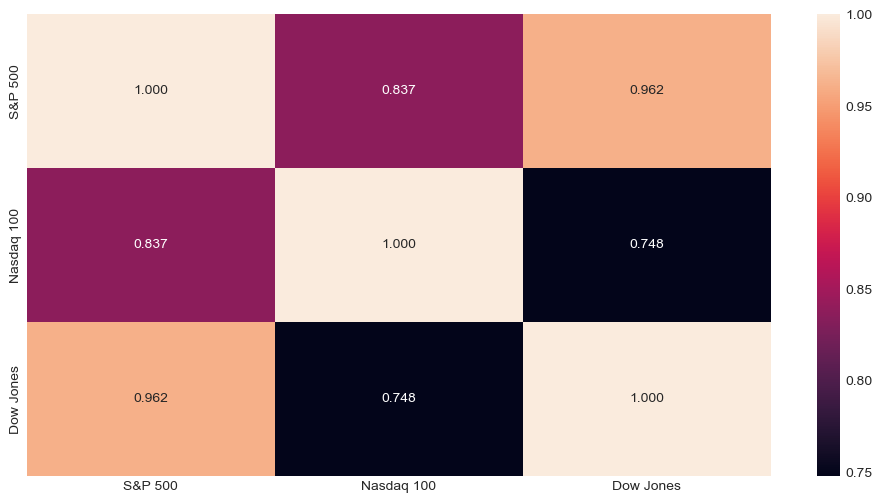

In [182]:
returns = pd.DataFrame({
    'S&P 500': sp500_perf['Return'].dropna(),
    'Nasdaq 100': nasdaq100_perf['Return'].dropna(),
    'Dow Jones': dowjones_perf['Return'].dropna()

})
sns.heatmap(returns.corr(), annot=True, fmt=".3f")

Összes index között erős korreláció van, de mégis eltérnek kicsit egymástól:

S&P 500 - Dow Jones: 0.962 Ez majdnem tökéletes korreláció, ami a nagy átfedésnek, és a két index hasonló felépítésének köszönhető.

S&P 500 - Nasdaq 100: 0.837 Ez már nem olyan magas mint az előbb, de még mindig erős. Ez a különbség részben magarázható azzal, hogy a Nasdaq inkább tech súlyú.

Nasdaq 100 - Dow Jones: 0.748: Ez a legkisebb, de azért még midnig erős korreláció. Ez is azzal magyarázható, hogy a nasdaq főleg technológiai,Ez a különbség részben magarázható azzal, hogy a Nasdaq inkább tech súlyú, a Dow pedig inkább hagyományos ipari, és blue chip cégeket tartalmaz.

### Gördülő korreláció

A korábbiakban kiszámítottuk az indexek közötti korrelációt, amely egy összesített képet ad az indexek együttmozgásáról hosszabb távon. A piacok viselkedése azonban időben folyamatosan változik, így a kapcsolat erőssége az indexek között sem állandó.

Ezt gördülő korreláció segítségével próbálom megérteni. Korábbiakhoz hasonlóan, a window változóban tárolt értékkel lehet megadni az ablak méretét napban.


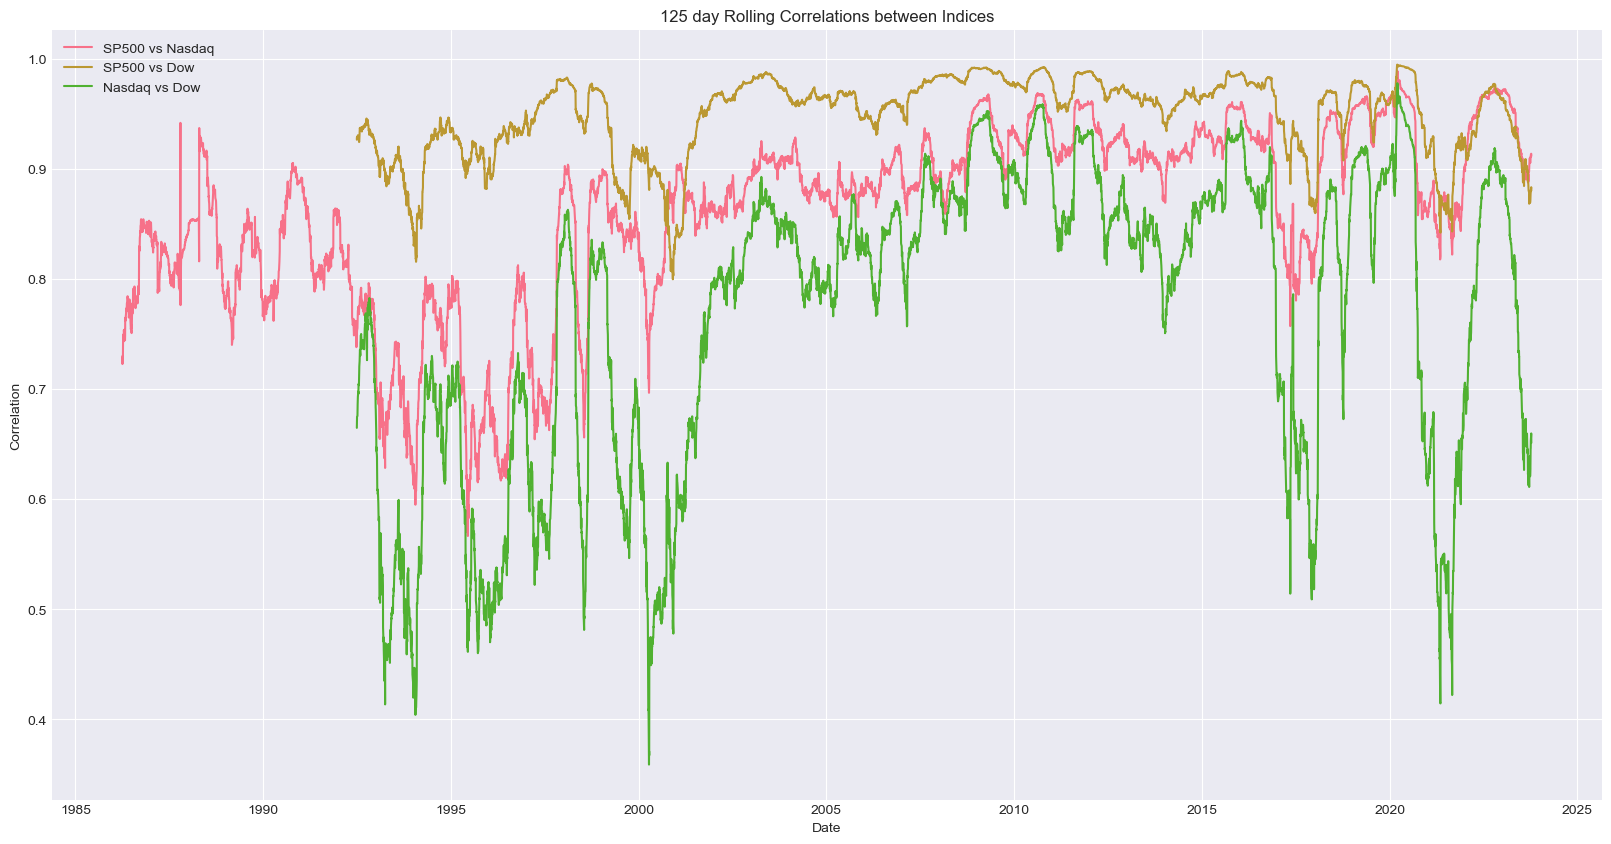

In [183]:
window = 125

rolling_sp_nas = returns['S&P 500'].rolling(window).corr(returns['Nasdaq 100'])
rolling_sp_dow = returns['S&P 500'].rolling(window).corr(returns['Dow Jones'])
rolling_nas_dow = returns['Nasdaq 100'].rolling(window).corr(returns['Dow Jones'])

plt.figure(figsize=(20,10))
plt.plot(rolling_sp_nas, label='SP500 vs Nasdaq')
plt.plot(rolling_sp_dow, label='SP500 vs Dow')
plt.plot(rolling_nas_dow, label='Nasdaq vs Dow')
plt.title(f'{window} day Rolling Correlations between Indices')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()


A korábban megfigyelt hierarchia itt is fentáll, viszont megfigyelhető ezek volatilitása is, ami láthatóan fordítottan arányos a korreláció mértékével. Az is megfigyelhető, hogy hogy volt hatással a 2000-es évek környéki dot-com buborék a nasdaq korrelációjára más indexekkel, és hogy milyen nagy kitettsége volt a Nasdaq-nak a 2000-es összeomlásban a többi indexhez képest.

### Gördülő volatilitás

Korábbiakhoz hasonlóan állítható ablakkal

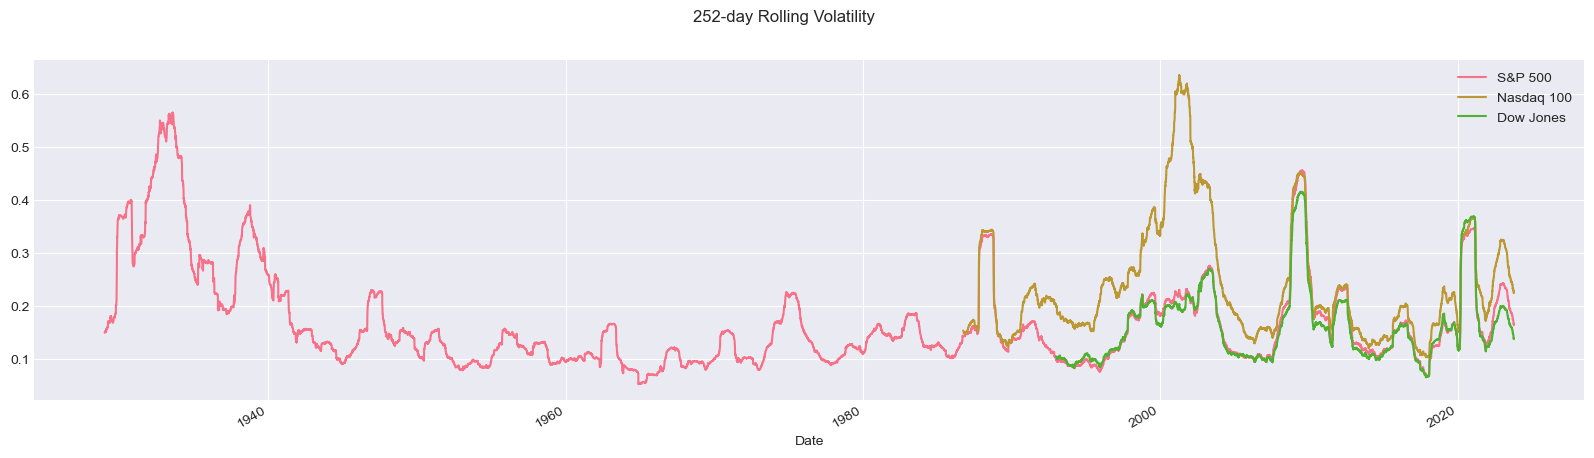

In [184]:
window = 252

rolling_vol = returns.rolling(window).std() * (window ** 0.5)
fig, ax = plt.subplots(figsize=(20, 5))
fig.suptitle(f"{window}-day Rolling Volatility")
rolling_vol.plot(ax=ax)
plt.show()

Ez egy nagyon elterjedt vizualizáció, amin látszik a korábban említett volatility clustering, összehasonlítható a különböző indexek voaltilitásprofilja.

Látható, hogy a tech-heavy Nasdaq  a dot-com buborék körül lényegesen különbözik a másik kettőtől.

Habár a S&P 500 és a Dow közel vannak egymáshoz, egy Dow - S&P - Nasdaq sorrend kivehető, ami a korábbi "sorrendekhez" hasonlít, és ez ugyanúgy az indexek felépítéséből ered.


### Maximum Drawdowns

A kockázatok elemzésének kritikus lépése a tőkecsúcsoktól való visszaesés (Drawdown) mértékének vizsgálata.
A grafikon az indexek időbeli "All-Time High" (ATH) szintjüktől való százalékos távolságát ábrázolja.

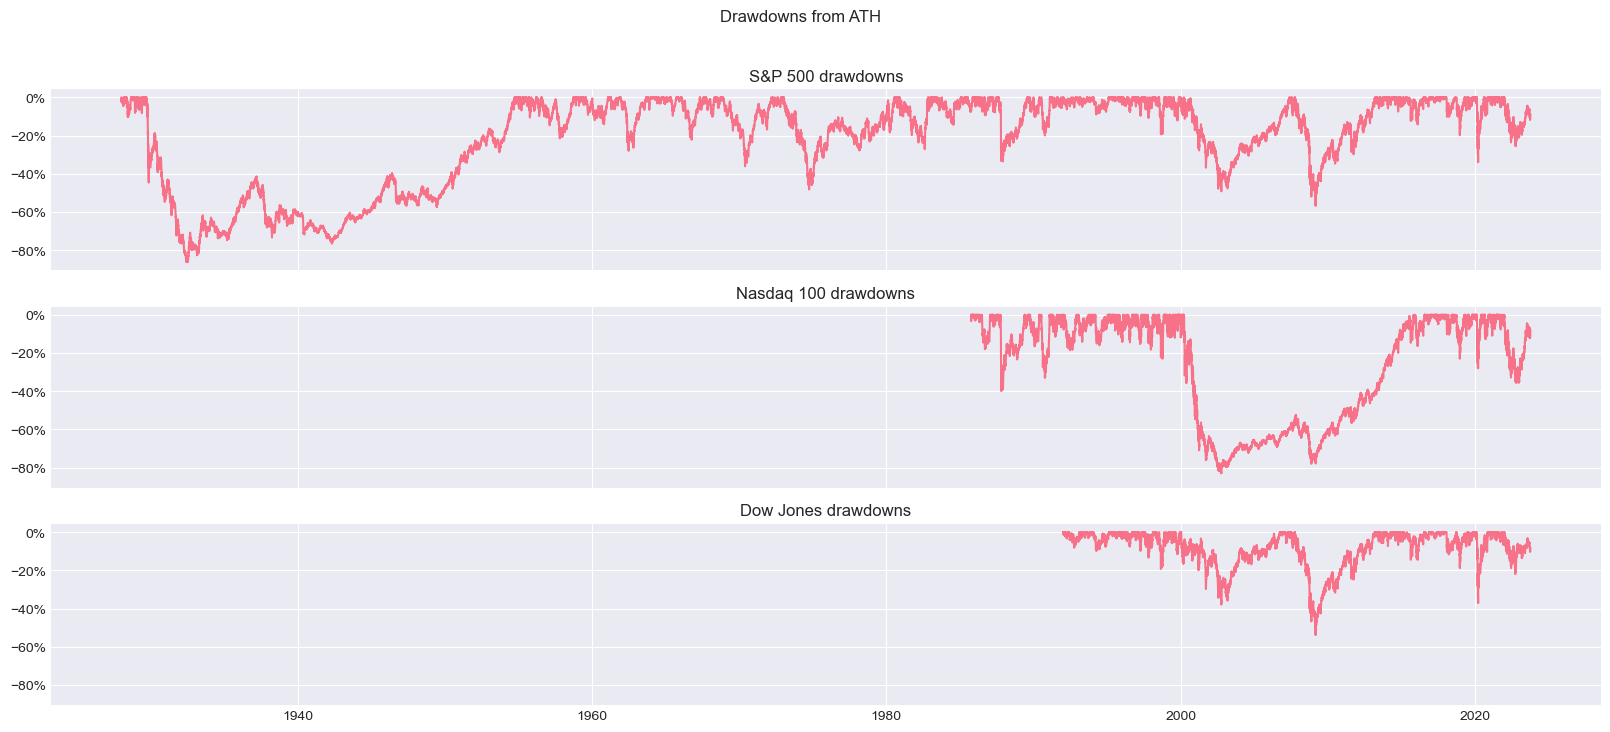

In [185]:
fig, ax = plt.subplots(3, 1, figsize=(20,8), sharey=True, sharex=True)
fig.suptitle("Drawdowns from ATH")

for i, (name, idx) in enumerate(returns.items()) :
    cumulative = (1 + returns[name]).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    ax[i].plot(drawdown)
    ax[i].set_title(f'{name} drawdowns')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
fig.show()

A grafikonon látható visszaesések segítenek megítélni, hogy az egyes indexek mennyire voltak kitéve súlyos piaci stressznek, és mennyi ideig tartott az onnan való felépülés. 

Itt is látszik a Nasdaq nagy tech-kitettsége, nagyobb válságok és azok hatásai közti különbséget.

### Hozameloszlás ferdesége (skew), csúcsossága (kurtosis)

A következő cella a napi hozamok eloszlását ábrázolja a ferdeség és csúcsosság értékeivel együtt.

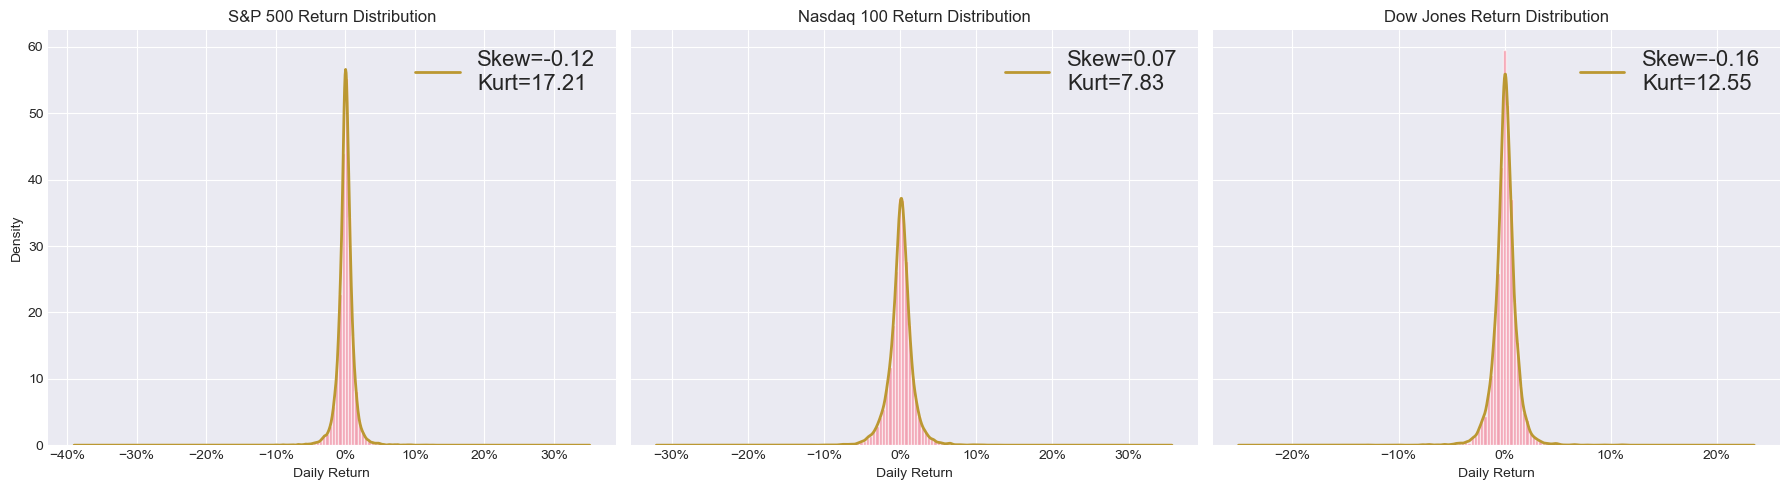

In [186]:
fig, ax = plt.subplots(1, 3, figsize=(18,5), sharey=True)

for i, name in enumerate(returns.columns):
    skew = returns[name].skew()
    kurt = returns[name].kurtosis()

    ax[i].hist(returns[name], bins=80, density=True, alpha=0.6)

    returns[name].plot(kind='kde', ax=ax[i], linewidth=2,
              label=f'Skew={skew:.2f}\nKurt={kurt:.2f}')

    ax[i].set_title(f"{name} Return Distribution")
    ax[i].set_xlabel("Daily Return")
    ax[i].set_ylabel("Density")
    ax[i].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax[i].legend(fontsize=16)

plt.tight_layout()
plt.show()

A negatív ferdeség (S&P 500, DOW) tipikus a pénzügyi piacokon, mivel a pánik és a nagy eladási hullámok általában gyorsabbak és mélyebbek, mint a hosszan tartó, stabil emelkedések. Mindhárom index hozama *leptokurtikus* mivek csúcsosság mindegyiknél nagyobb mint 3, ami jellemző a pénzügyi adatokra. Ez azt jelenti, hogy az 'extrém' értékeknek nagyobb esélyük van. 

S&P 500 mutatja a legnagyobb kockázatot a szélsőséges események szempontjából, mivel az ő csúcsossága a legmagasabb (17.25).

Mind a S&P 500, mind a DOW enyhe baloldali ferdeséget mutat, ami azt jelzi, hogy a nagy negatív meglepetések valószínűbbek, mint a nagy pozitív meglepetések.

A NASDAQ hozamai állnak a legközelebb a szimmetrikus eloszláshoz, de a magas csúcsosság (7.83) itt is figyelmeztet a ritka, de potenciálisan súlyos események kockázatára.



### Kondicionális volatilitás

A piacok aszimmetrikus volatilitási válaszát fogom vizsgálni.
Ez az elemzés azt nézi meg, hogy az index hozamának volatilitása hogyan változik, ha azt egy megelőző pozitív, vagy negatív hozamú nap követi.


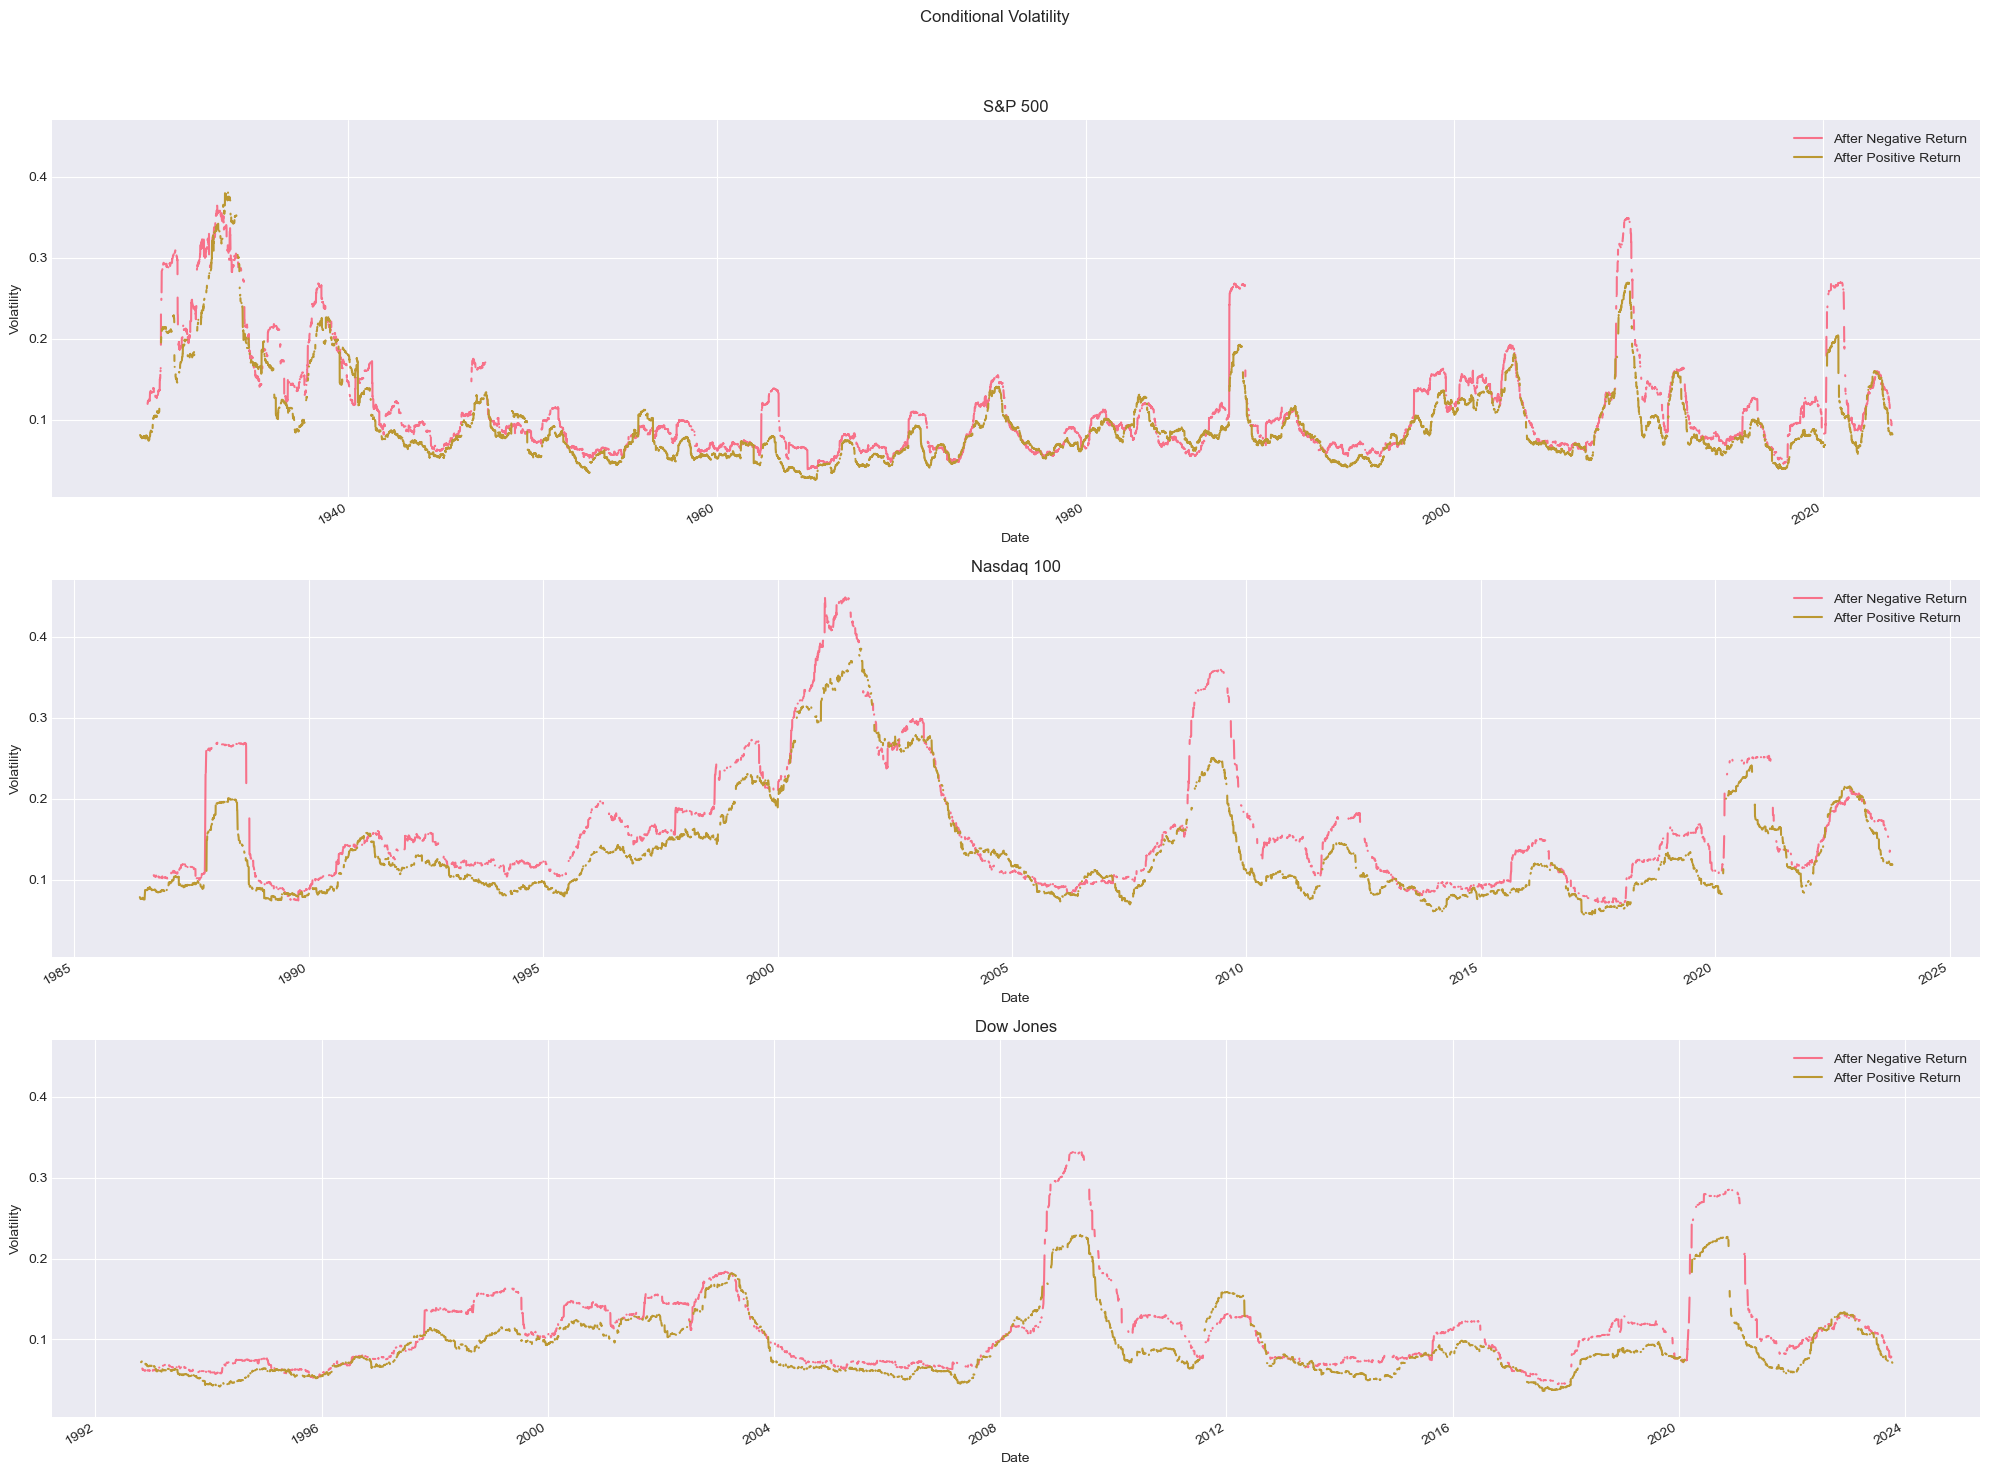

In [187]:
neg_returns = returns[returns < 0]
pos_returns = returns[returns > 0]

window = 100

cond_vol = {}
for name in returns.columns:
    lagged_sign = returns[name].shift(1)
    vol_neg = returns[name][lagged_sign < 0].rolling(window).std() * (window**0.5)
    vol_pos = returns[name][lagged_sign > 0].rolling(window).std() * (window**0.5)

    cond_vol[name] = pd.DataFrame({
        'Vol_after_neg': vol_neg,
        'Vol_after_pos': vol_pos
    })

fig, ax = plt.subplots(3, 1, figsize=(20, 15), sharey=True)
fig.suptitle("Conditional Volatility")

for i, name in enumerate(returns.columns):
    cond_vol[name].plot(ax=ax[i])
    ax[i].set_title(name)
    ax[i].set_ylabel("Volatility")
    ax[i].legend(["After Negative Return", "After Positive Return"])

plt.tight_layout(rect=(0,0,1,0.95))
plt.show()


A grafikonon látható, negatív hozamot mutató napok után nagyobb volatilitást (kockázatot) mutatnak, mint pozitív hozamot mutató napok után.

Ezt a jelenséget pénzügyi nyelven *Leverage effect*-nek hívják. Ezt a nevet a hatás egyik magyarázatáról kapta, ami az, ha az árfolyam esik, a vállalatok tőkeáttétele (leverage) automatikusan megnő. A megnövekedett tőkeáttétel a jövőbeli nyereség nagyobb bizonytalanságát eredményezi, ami megnövekedett volatilitásban nyilvánul meg.



### STL felbontás

STL segítségével a teljes árfolyam idősort három összetevőre bontjuk:
 - Trend (hosszú távú irány)
 - Szezonalitás (ismétlődő minták)
 - Reziduális (zaj/maradék).

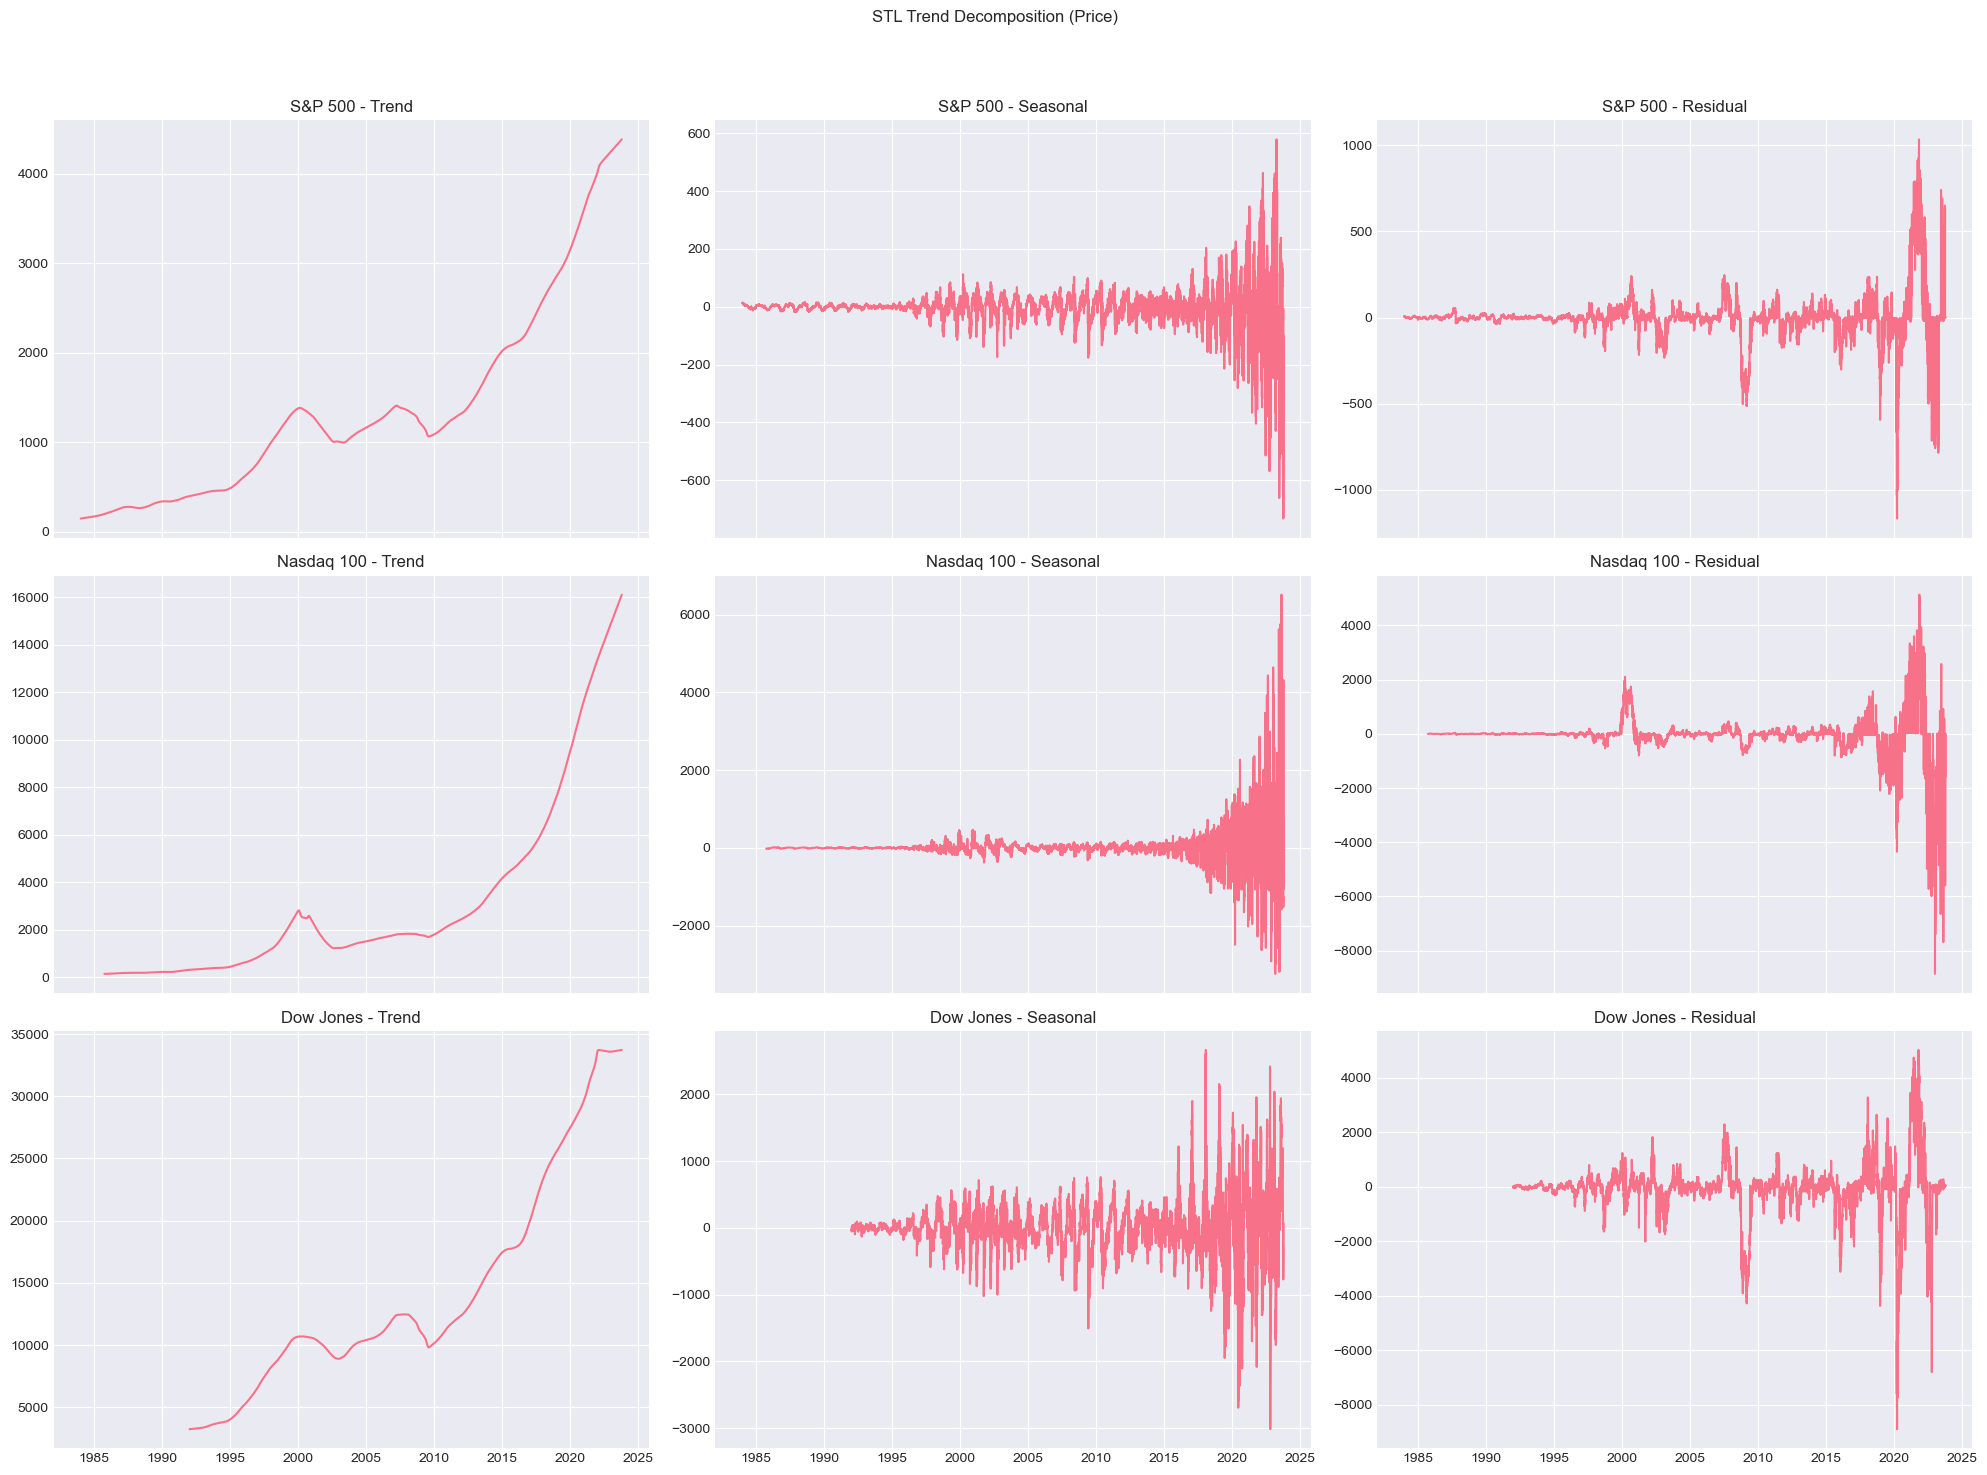

In [188]:
# Frekvencia (period), 252 = kereskedési napok egy évben
period = 252
# Utolsó n év vizsgálata
last_years = 40

fig, axes = plt.subplots(len(indeces), 3, figsize=(20, 15), sharex=True)
fig.suptitle("STL Trend Decomposition (Price)")

for i, (name, idx) in enumerate(indeces.items()):
    price = idx.last(f'{last_years}Y')['Close'].dropna()

    stl = STL(price, period=period, robust=True).fit()

    axes[i, 0].plot(stl.trend)
    axes[i, 0].set_title(f"{name} - Trend")

    axes[i, 1].plot(stl.seasonal)
    axes[i, 1].set_title(f"{name} - Seasonal")

    axes[i, 2].plot(stl.resid)
    axes[i, 2].set_title(f"{name} - Residual")

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


A trend komponens mutatja az index hosszú távú alapvető mozgásirányát. A pénzügyi idősorok esetében ez a legfontosabb összetevő, ami a gazdasági növekedést, recessziót és a piaci általános hangulatot tükrözi. Ez az elvárásokkal megegyezően emelkedő tendenciát mutat.

A szezonális komponens azokat az ismétlődő, determinisztikus mintákat hivatott kimutatni, amelyek a beállított periódus (itt 252 kereskedési nap) mentén ismétlődnek. Mivel az árfolyamok abszolút értéke és a trend is idővel nő, a szezonális komponens is megpróbálja elnyelni azokat az ingadozásokat, amelyek az idősorban növekvő amplitúdóval jelentkeznek. Ezért látható, hogy a szezonalitás amplitúdója az idő előrehaladtával nő, ahogy az árfolyam szórása is abszolút értékben növekszik.

A Reziduális komponens az a megmagyarázhatatlan zaj, ami megmarad a Trend és a Szezonalitás levonása után. Ez a komponens reprezentálja a véletlenszerű sokkokat, a gyorsan beépülő híreket és a valódi piaci volatilitást, amit a modellezéskor figyelembe kell venni. Ezeken a grafikonokon megfigyelhető a *volatility clustering* jelenésge is

### STL felbontás Log-hozammal

Logaritmikus hozamok használatának az árfolyamok helyett két fő oka van a pénzügyi idősor-elemzésben:
 - Kiküszöböli az Exponenciális Növekedést: Az árfolyamok trendje általában exponenciális, tehát ha az árat bontjuk fel, az STL minden komponense is exponenciálisan nő az árfolyammal, ami megnehezíti az összehasonlítást. 
 - Stabilizálja a Volatilitást: Nyers árfolyamokkal végzett elemzésnél láttuk, hogy az ingadozások abszolút mértéke nőtt, ahogy az indexek drágultak (Heteroszkedaszticitás), tehát szezonális és reziduális komponensek amplitúdója már nem növekszik az árfolyammal együtt.



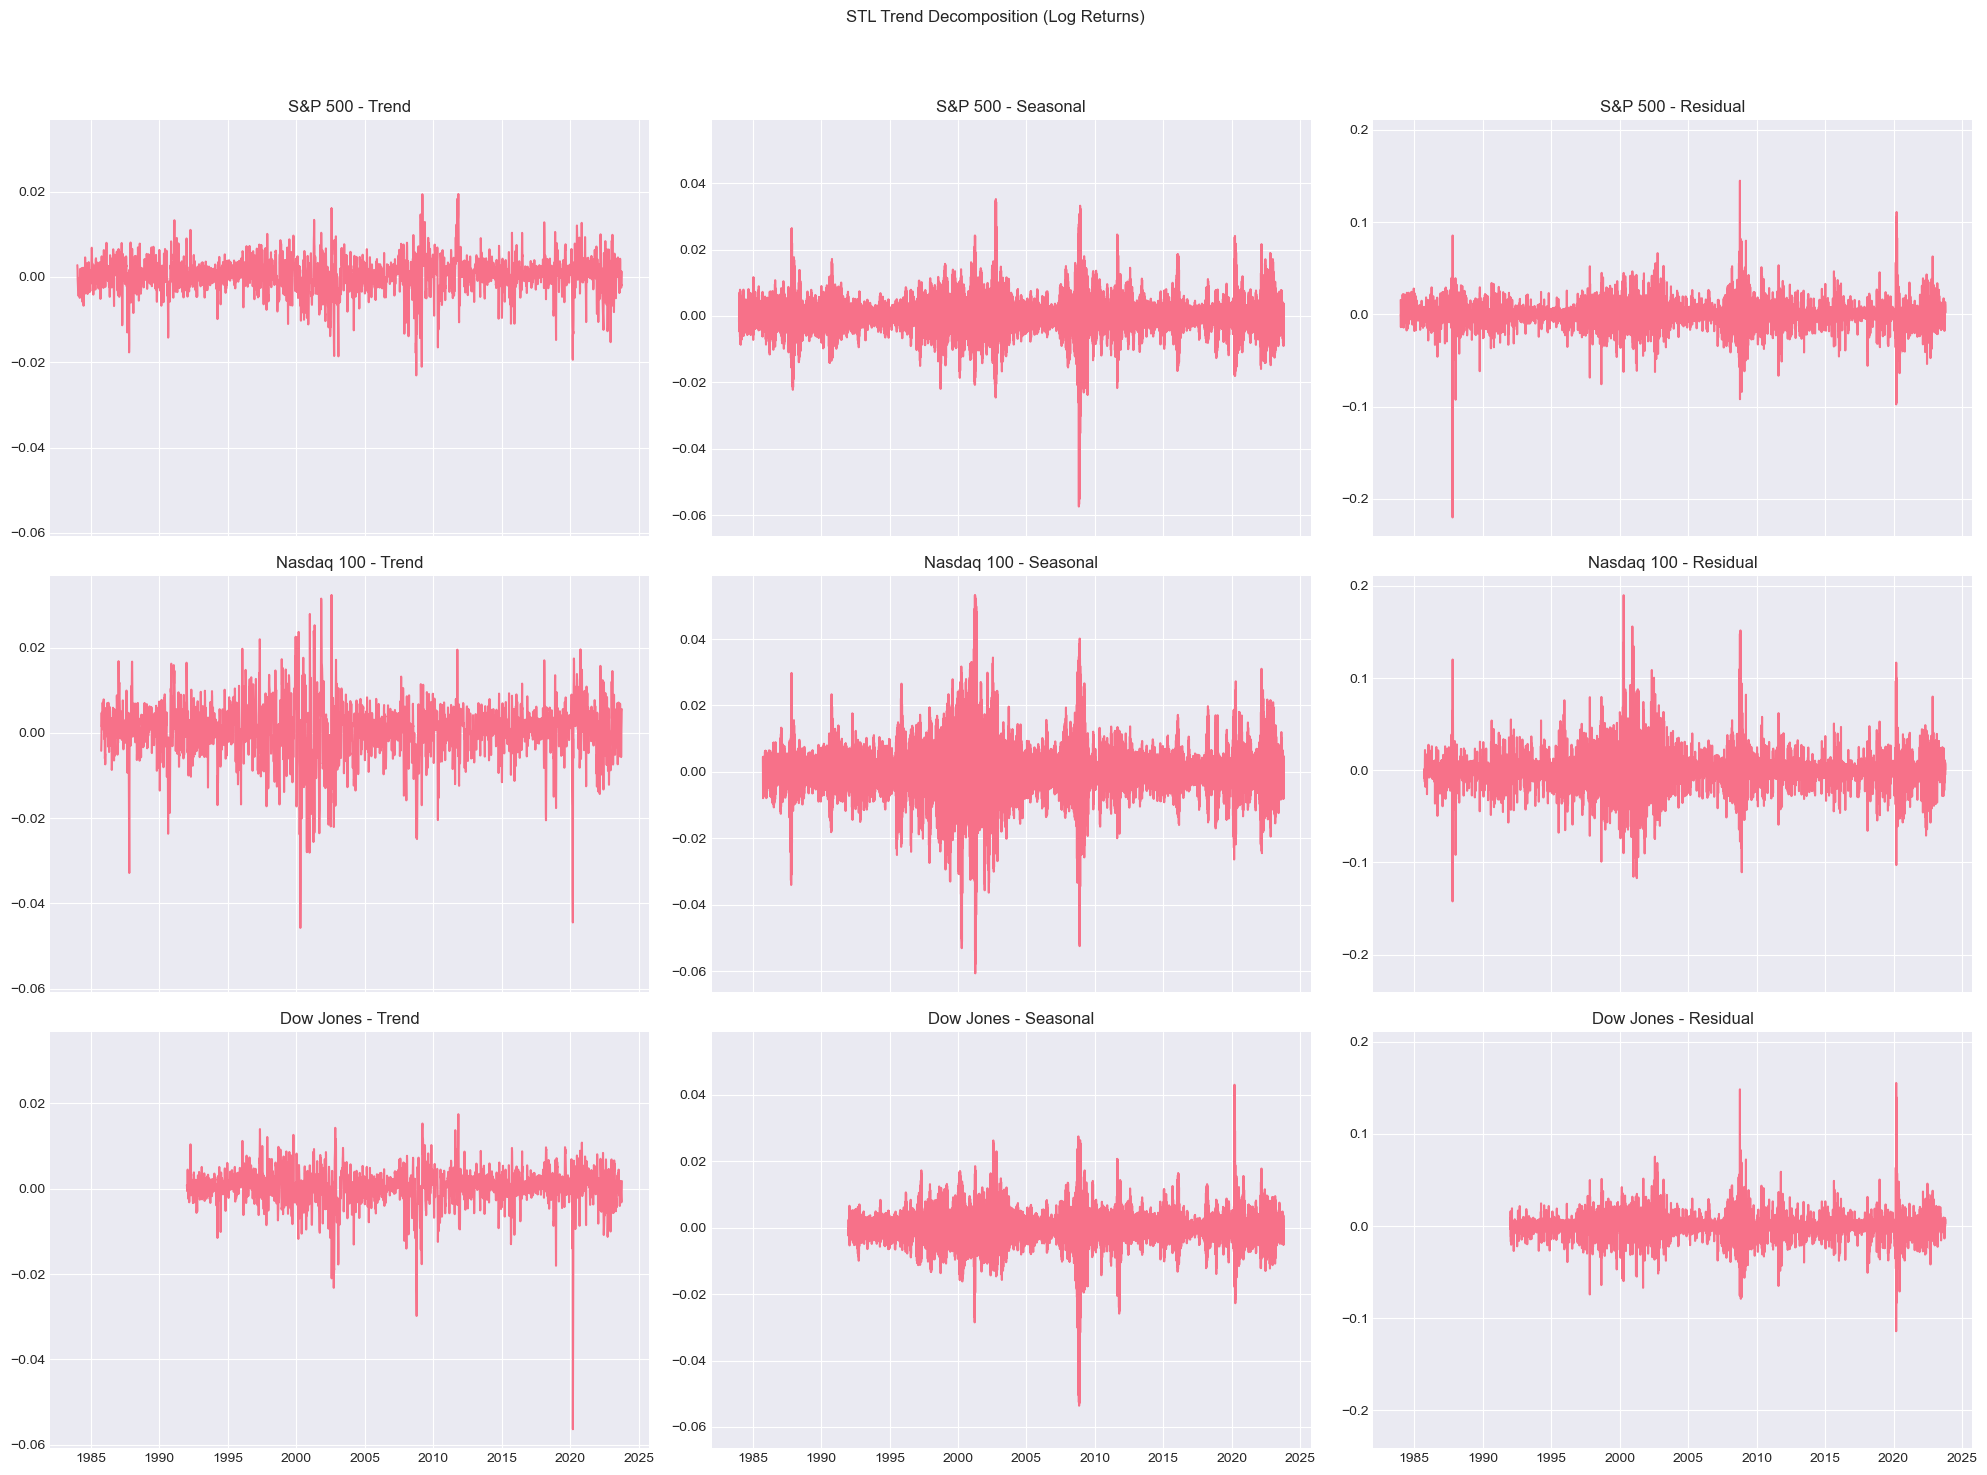

In [189]:
# Frekvencia (period), 252 = kereskedési napok egy évben
period = 5
# Utolsó n év vizsgálata
last_years = 40


fig, axes = plt.subplots(len(indeces), 3, figsize=(20, 15), sharex=True, sharey='col')
fig.suptitle("STL Trend Decomposition (Log Returns)")

for i, (name, idx) in enumerate(indeces.items()):
    price = idx.last(f'{last_years}Y')['Close'].dropna()
    log_ret = np.log(price).diff().dropna()

    stl = STL(log_ret, period=period, robust=True).fit()

    axes[i, 0].plot(stl.trend)
    axes[i, 0].set_title(f"{name} - Trend")

    axes[i, 1].plot(stl.seasonal)
    axes[i, 1].set_title(f"{name} - Seasonal")

    axes[i, 2].plot(stl.resid)
    axes[i, 2].set_title(f"{name} - Residual")

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()




Trend: A hozamok Trend komponense itt az index hosszú távú átlagos hozamát reprezentálja az idő függvényében. Ha a Trend görbe a 0 vonal körül mozog, az azt jelzi, hogy a hosszú távú hozam viszonylag stabil volt. Ha a görbe jelentősen 0 alá esik, az egy tartós negatív hozamú időszakot jelez, és fordítva.

Szezonalitás:  Szezonális komponens most sokkal tisztább formában mutatja a *period* napos mintákat, mivel a növekvő amplitúdó hatását kiküszöböltük. Ezeken a grafikonokon nem láthatóak periodikusan ismétlődő minták (heti, se havi, se évi periódussal sem), ami igazolja feltevést, hogy nincs jelentős szezonalitása.
A rendkívüli piaci események miatti volatilitás itt is látható.

Reziduális: Ez a komponens a legfontosabb a kockázatelemzés szempontjából, mivel ez felel meg a tisztított zajnak és a volatilitásnak. A Reziduális görbe amplitúdója közvetlenül a konstans szórású hozamok volatilitási klaszterezését mutatja. Ahol a görbe a legnagyobb kilengéseket mutatja, ott volt a legnagyobb kockázat és sokk a piacon pl.: 2008 vagy 2020 környékén.

## Inflációs adat


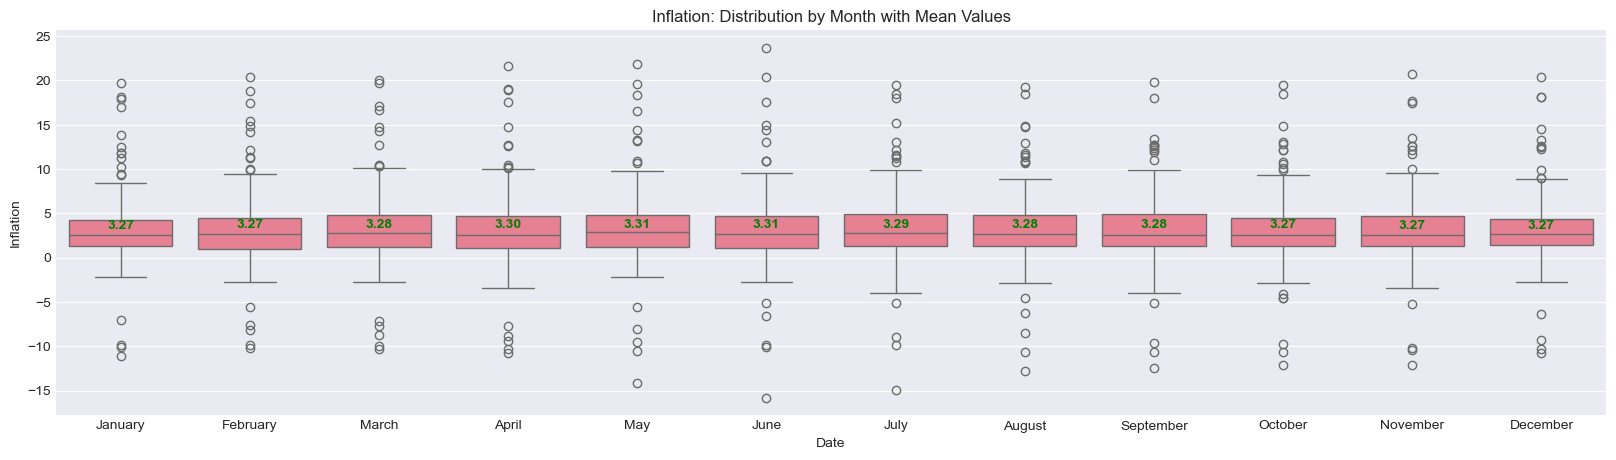

In [191]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=inflation, x=inflation.index.month, y="Inflation")

monthly_means = inflation.groupby(inflation.index.month)["Inflation"].mean()

for i, mean in enumerate(monthly_means, start=0):
    ax.text(i, mean + 0.05, f"{mean:.2f}",
            horizontalalignment='center', color='green', weight='bold')

# Replace x-ticks with month names
ax.set_xticks(range(12))
ax.set_xticklabels(calendar.month_name[1:])
plt.title("Inflation: Distribution by Month with Mean Values")
plt.show()

A 12 hónap átlagos inflációs rátái rendkívül közel állnak egymáshoz, ez azt jelzi, hogy havi szinten nincs jelentős szetonalitás.
Ez reális, hiszen inflációs adatok ingadozását sokkal inkább a hosszú távú makrogazdasági folyamatok és a véletlenszerű események határozzák meg, mintsem a kiszámítható naptári ciklusok.

Ferdeség: 0.55 : A pozitív ferdeség azt jelenti, hogy az eloszlás enyhén jobbra húzódik, azaz a leggyakoribb inflációs értékek a medián alatt helyezkednek el, és az eloszlásnak van egy hosszabb "farka" a magas infláció irányába, tehát a ritkán előforduló, extrém magas inflációs sokkok valószínűbbek voltak, mint az extrém deflációs sokkok.

Csúcsosság: 3.08 :  A 3.08 érték azt jelenti, hogy az eloszlás nagyon közel áll a normál eloszláshoz. Az enyhén 3 feletti érték azt jelzi, hogy az infláció a középpontban enyhén csúcsosabb, és a szélső értékek is enyhén gyakoribbak, mint amit a normál eloszlás feltételezne, de csak minimálisan.

### Autokorreláció viszgálata



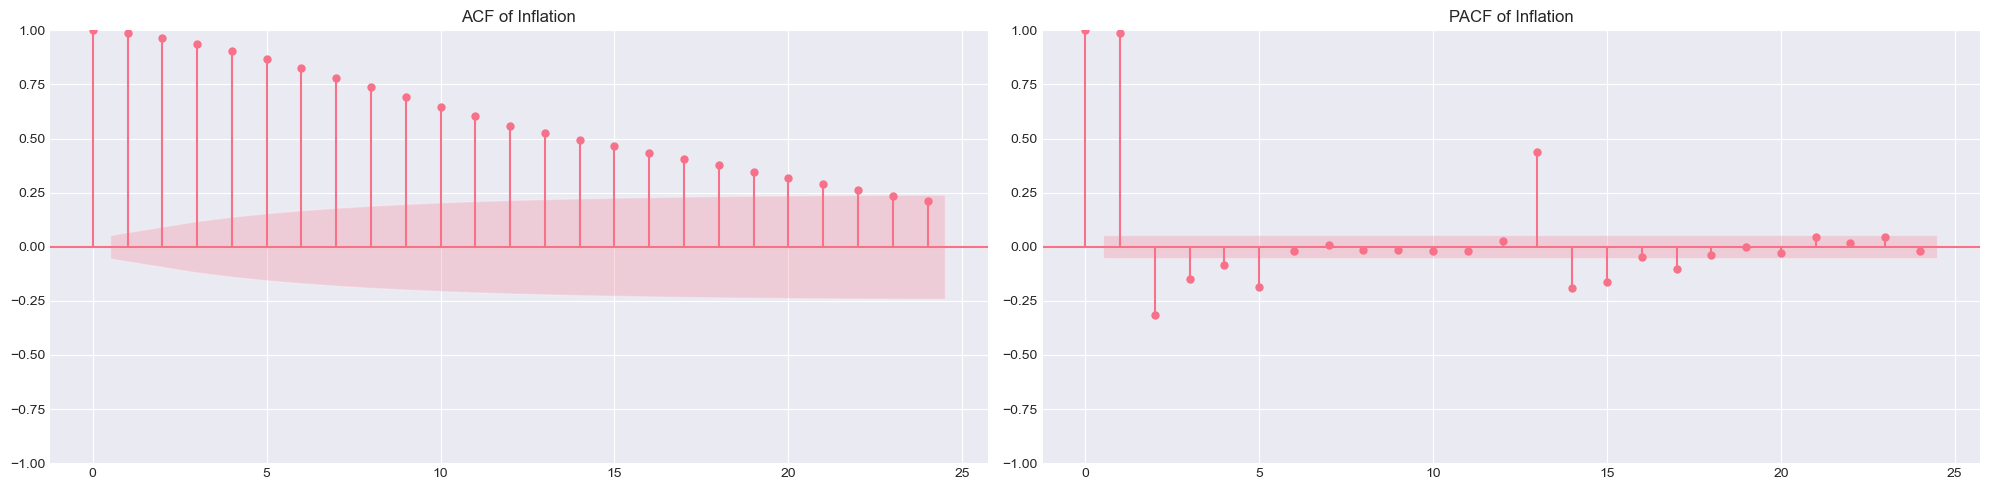

In [193]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# ACF
plot_acf(inflation['Inflation'].dropna(), lags=24, ax=ax[0])
ax[0].set_title("ACF of Inflation")

# PACF
plot_pacf(inflation['Inflation'].dropna(), lags=24, ax=ax[1])
ax[1].set_title("PACF of Inflation")

plt.tight_layout()
plt.show()


A legtöbb inflációs idősorra jellemző módon, az ACF görbe lassú, elnyújtott csökkenése erős jelzése annak, hogy az idősor nem stacionárius.

### Gördülő volatilitás

A gördülő volatilitás a kockázat idősoros dinamikáját mutatja be, segítve a makrogazdasági periódusok azonosítását.

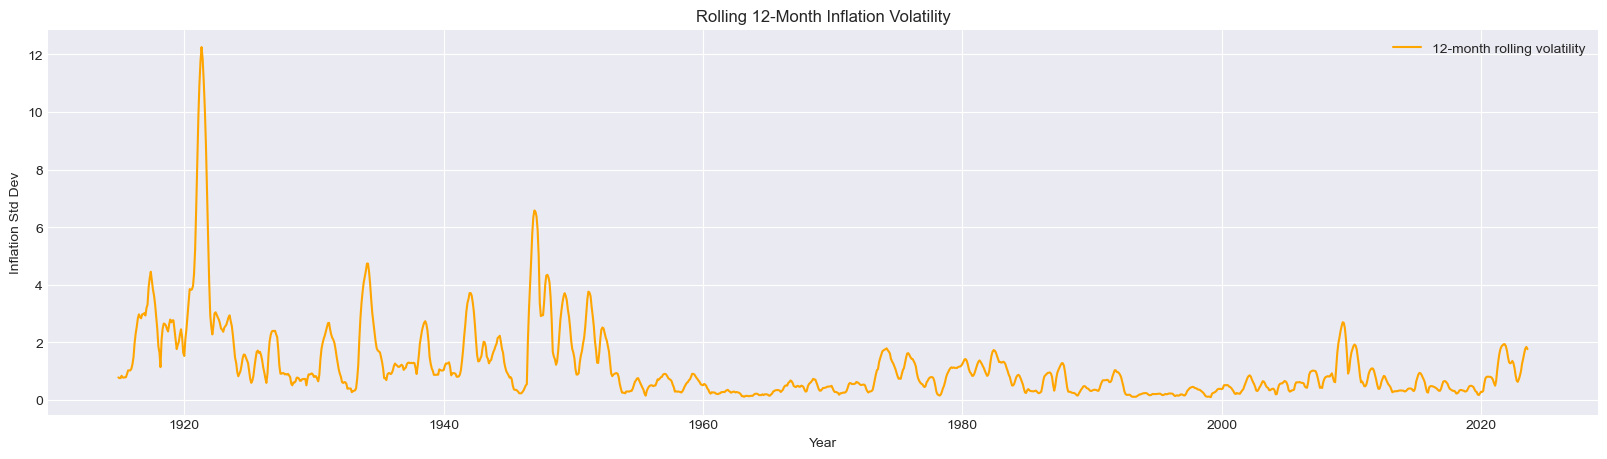

In [194]:
window = 12

rolling_vol = inflation['Inflation'].rolling(window=window).std()

plt.figure(figsize=(20,5))
plt.plot(inflation.index, rolling_vol, color='orange', label='12-month rolling volatility')
plt.title("Rolling 12-Month Inflation Volatility")
plt.xlabel("Year")
plt.ylabel("Inflation Std Dev")
plt.grid(True)
plt.legend()
plt.show()


A görbe emelkedése azt jelenti, hogy az infláció kiszámíthatatlanabbá vált, míg a csökkenés az inflációs ráta nagyobb stabilitását jelzi.

Az indexek hozamaihoz hasonlóan az infláció is gyakran mutat volatilitási klaszterezést, azaz a nagy ingadozású időszakokat (pl. olajválságok, monetáris politikai sokkok) tovább nagy ingadozású időszakok követik.

### A részvényhozamok vizsgálata különböző inflációs környezetekben

Az alábbi kód az inflációt négy kategóriába sorolja, majd kiszámolja az indexek átlagos évesített hozamát és volatilitását ezen kategóriák szerint.

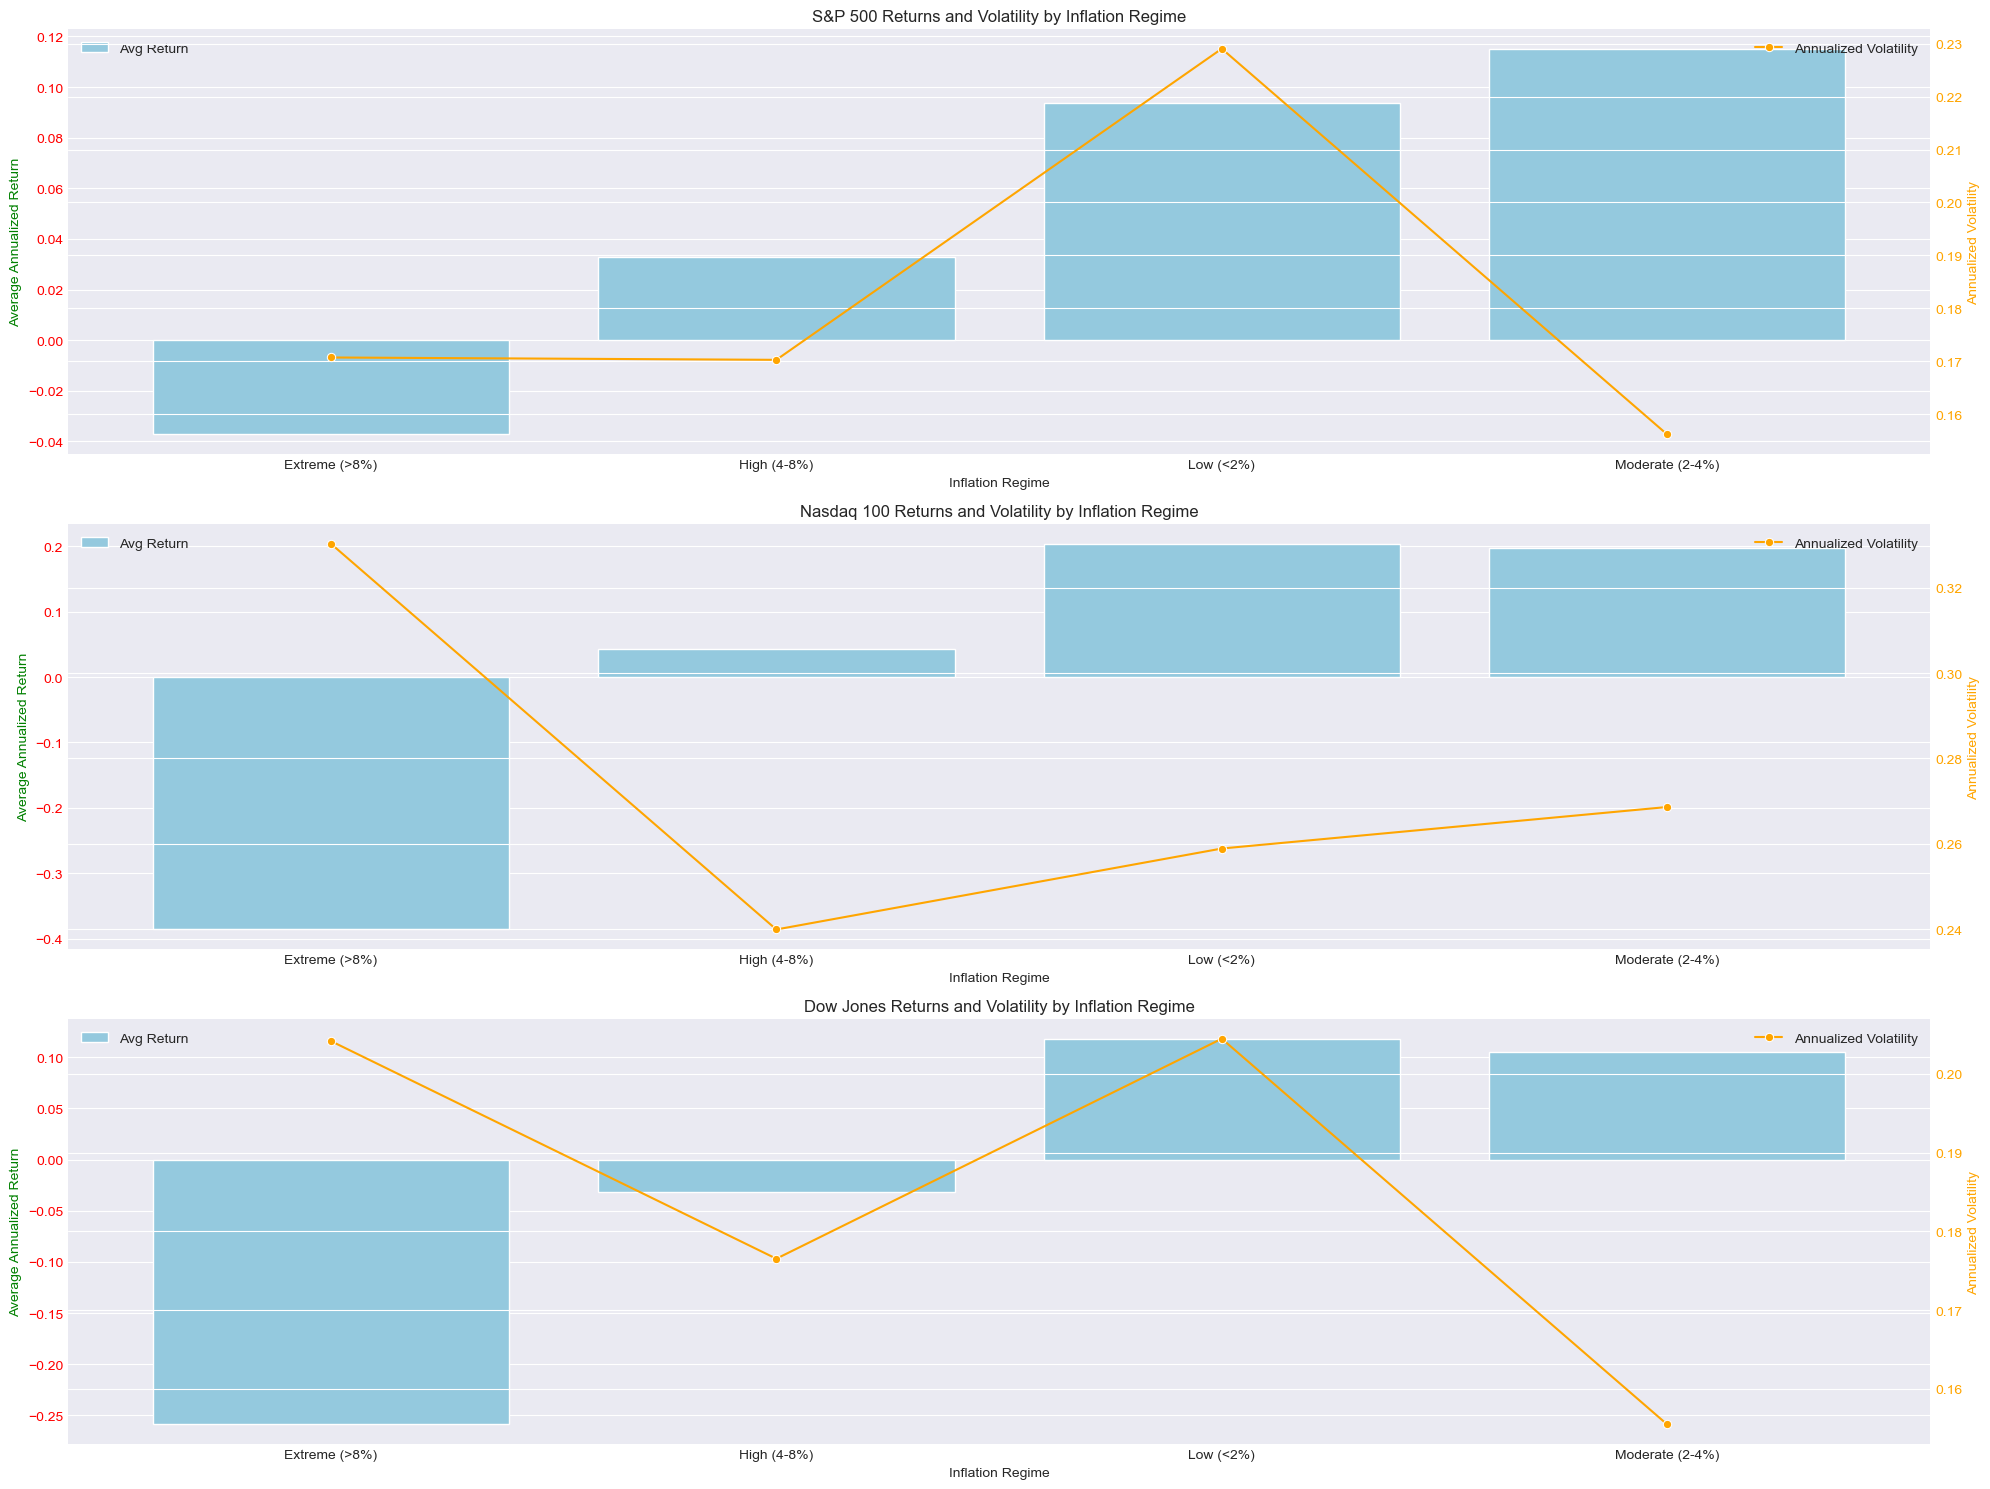

In [195]:
def classify_inflation(x):
    if x < 2:
        return 'Low (<2%)'
    elif x < 4:
        return 'Moderate (2-4%)'
    elif x < 8:
        return 'High (4-8%)'
    else:
        return 'Extreme (>8%)'

inflation_daily = inflation.reindex(returns.index, method='ffill')
inflation_daily.columns = ['Inflation']
inflation_daily['Regime'] = inflation_daily['Inflation'].apply(classify_inflation)

returns_with_regime = returns.copy()
returns_with_regime['Inflation_Regime'] = inflation_daily['Regime']


avg_stats = {}

for name in returns.columns:
    grouped = returns_with_regime.groupby('Inflation_Regime')[name]
    avg_returns = grouped.mean() * 252
    avg_vol = grouped.std() * (252**0.5)

    avg_stats[name] = pd.DataFrame({
        'Avg_Return': avg_returns,
        'Annualized_Volatility': avg_vol
    })

fig, ax = plt.subplots(3,1, figsize=(20,15))

for i, name in enumerate(returns.columns):
    df_plot = avg_stats[name].reset_index()

    # Oszlop
    sns.barplot(x='Inflation_Regime', y='Avg_Return', data=df_plot, ax=ax[i], color='skyblue', label='Avg Return')
    ax[i].set_ylabel("Average Annualized Return", color='green')
    ax[i].set_xlabel("Inflation Regime")
    ax[i].tick_params(axis='y', labelcolor='red')

    # Volatilitás
    ax2 = ax[i].twinx()
    sns.lineplot(x='Inflation_Regime', y='Annualized_Volatility', data=df_plot, ax=ax2, color='orange', marker='o', label='Annualized Volatility')
    ax2.set_ylabel("Annualized Volatility", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    ax[i].legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax[i].set_title(f"{name} Returns and Volatility by Inflation Regime")

plt.tight_layout()
plt.show()



Az ábrán látható, hogy melyik inflációs regime hozta történelmileg a legjobb átlagos hozamot a részvények számára. A hozamok jellemzően alacsonyabbak lehetnek az Extreme regime-ben, mivel a jegybankok ilyenkor agresszív kamatemelésekkel próbálják letörni az inflációt, ami rontja a vállalati profitkilátásokat.

A volatilitás általában a Low és Moderate regime-ekben a legalacsonyabb, mivel a gazdasági bizonytalanság kicsi. A kockázat emelkedése jelzi, hogy a magas infláció nemcsak alacsonyabb hozamot, hanem sokkal kiszámíthatatlanabb piacot is eredményez.

### Részvényhozamok és az infláció közötti kapcsolat vizsgálata

Correlation between S&P 500 returns and Inflation: -0.01
Correlation between Nasdaq 100 returns and Inflation: -0.02
Correlation between Dow Jones returns and Inflation: -0.02


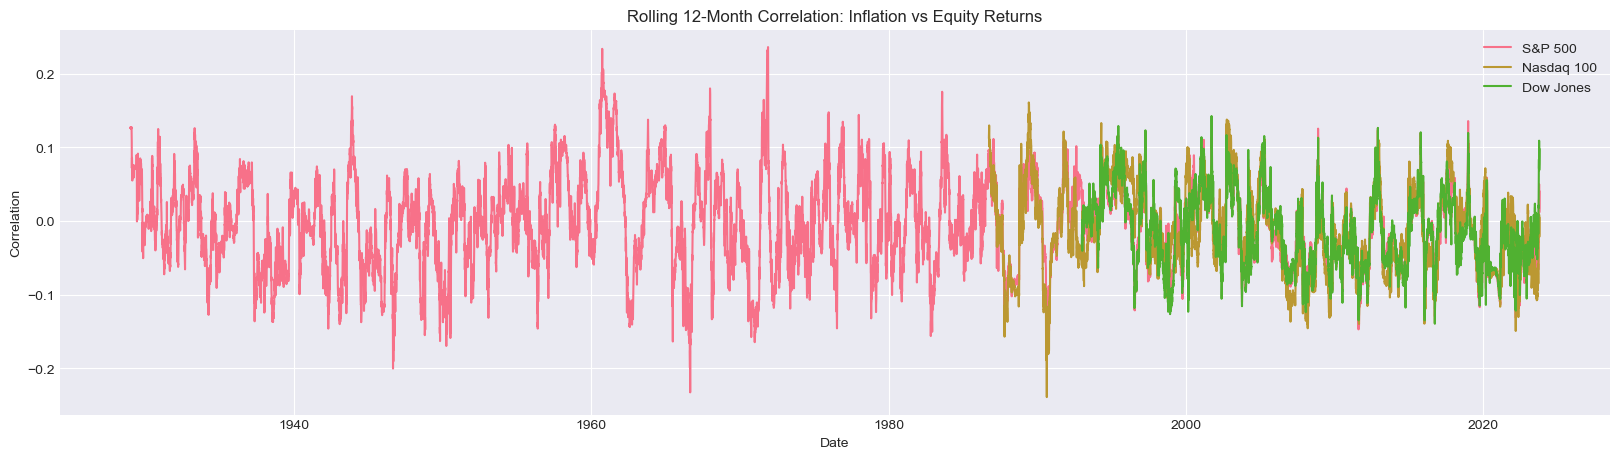

In [196]:
returns_inflation = returns.copy()
returns_inflation['Inflation'] = inflation_daily['Inflation']
returns_inflation = returns_inflation.dropna(subset=['Inflation'])

for name in returns.columns:
    corr = returns_inflation[name].corr(returns_inflation['Inflation'])
    print(f"Correlation between {name} returns and Inflation: {corr:.2f}")


window = 252
plt.figure(figsize=(20,5))

for name in returns.columns:
    rolling_corr = returns_inflation[name].rolling(window).corr(returns_inflation['Inflation'])
    plt.plot(rolling_corr, label=name)

plt.title("Rolling 12-Month Correlation: Inflation vs Equity Returns")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.show()



Statikus Korreláció: Mindhárom index esetében a korreláció nagyon közel van a nullához, ami azt jelenti, hogy a teljes időszak átlagában a napi részvényhozamok és a napi inflációs adatok között nincs stabil lineáris kapcsolat.

Dinamikus Korreláció: A grafikon mutatja a kapcsolat ingadozását, ami azt jelenti, hogy a befektetőknek folyamatosan újra kell értékelniük az indexek inflációval szembeni ellenálló képességét.
 - Negatív korreláció: Infláció emelkedik, a részvényhozamok csökkennek, ekkor a részvények felerősítik az inflációs kockázatot. Ez tipikusan akkor fordul elő, ha a piaci sokkot az infláció növekedése és egyidejű recessziós félelem kíséri.
 - Pozitív korreláció: Infláció emelkedik, a részvényhozamok is emelkednek, ekkor a részvények ekkor jobban működnek inflációs fedezetként. Ez jellemzően akkor fordul elő, ha a növekvő infláció oka a gazdasági növekedés és a nagy kereslet.

## Korrelációk

### Egyes részvények korrelációja egymással

In [197]:
returns_stocks = pd.DataFrame()

for symbol, df in prices.items():
    log_returns = np.log(df['Close']).diff().dropna()
    returns_stocks[symbol] = log_returns

returns_stocks = returns_stocks.dropna()


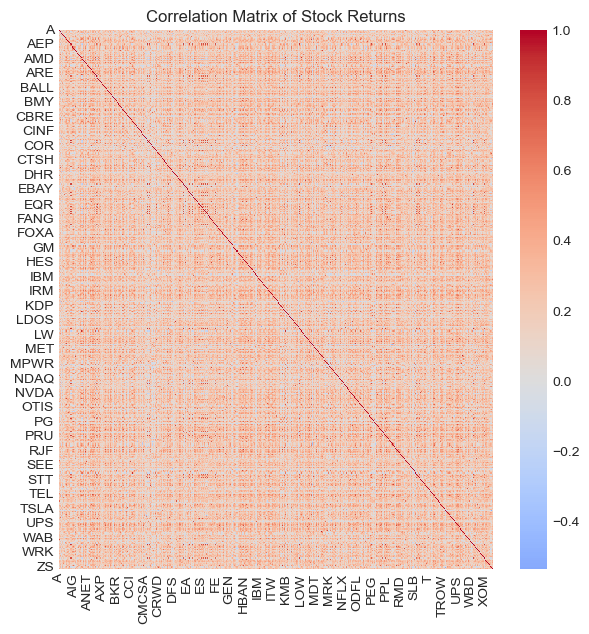

In [198]:
corr_matrix = returns_stocks.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Stock Returns")
plt.show()

Az összes részvénypár korrelációs együtthatójának eloszlását hisztogramon és sűrűséggörbén vizsgáljuk.

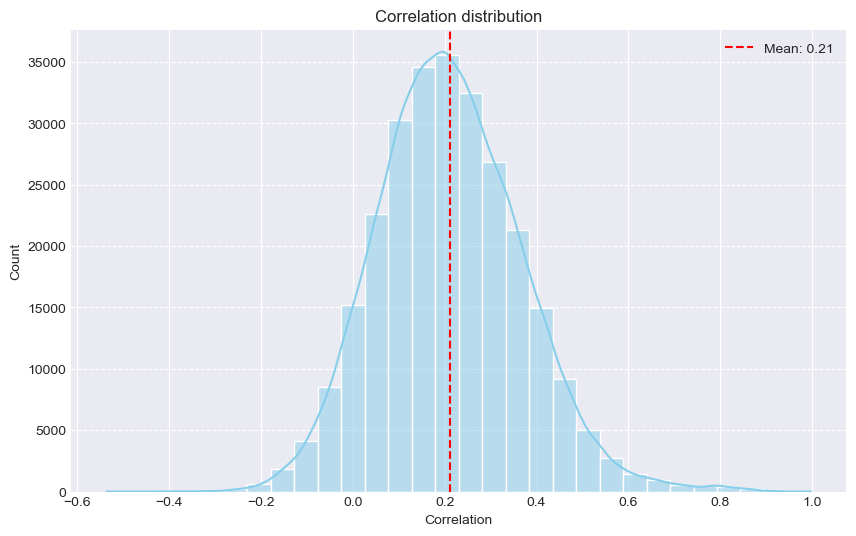

In [199]:
corr_values = corr_matrix.stack()
corr_values = corr_values[corr_values != 1.0]

plt.figure(figsize=(10, 6))

sns.histplot(
    corr_values,
    bins=30,
    kde=True,
    color='skyblue'
)

mean_corr = corr_values.mean()
plt.axvline(mean_corr, color='red', linestyle='--', label=f'Mean: {mean_corr:.2f}')
plt.legend()


plt.title("Correlation distribution")
plt.xlabel("Correlation")
plt.grid(axis='y', linestyle='--')
plt.show()

Látható, hogy az eloszlás jellemzően a pozitív tartományban csoportosul, ami alátámasztja azt, hogy a legtöbb részvény erősen együtt mozog. A piros szaggatott vonal jelzi a portfólió átlagos korrelációját, ami 
pozitív, de a relatív alacsony 0.21-es szint azt jelzi, hogy a datasetben található részvényel elég diverzifikáltak.

### Legerősebb korrelációk

n paraméterrel állítható, hogy mennyit szeretnénk megjeleníteni.

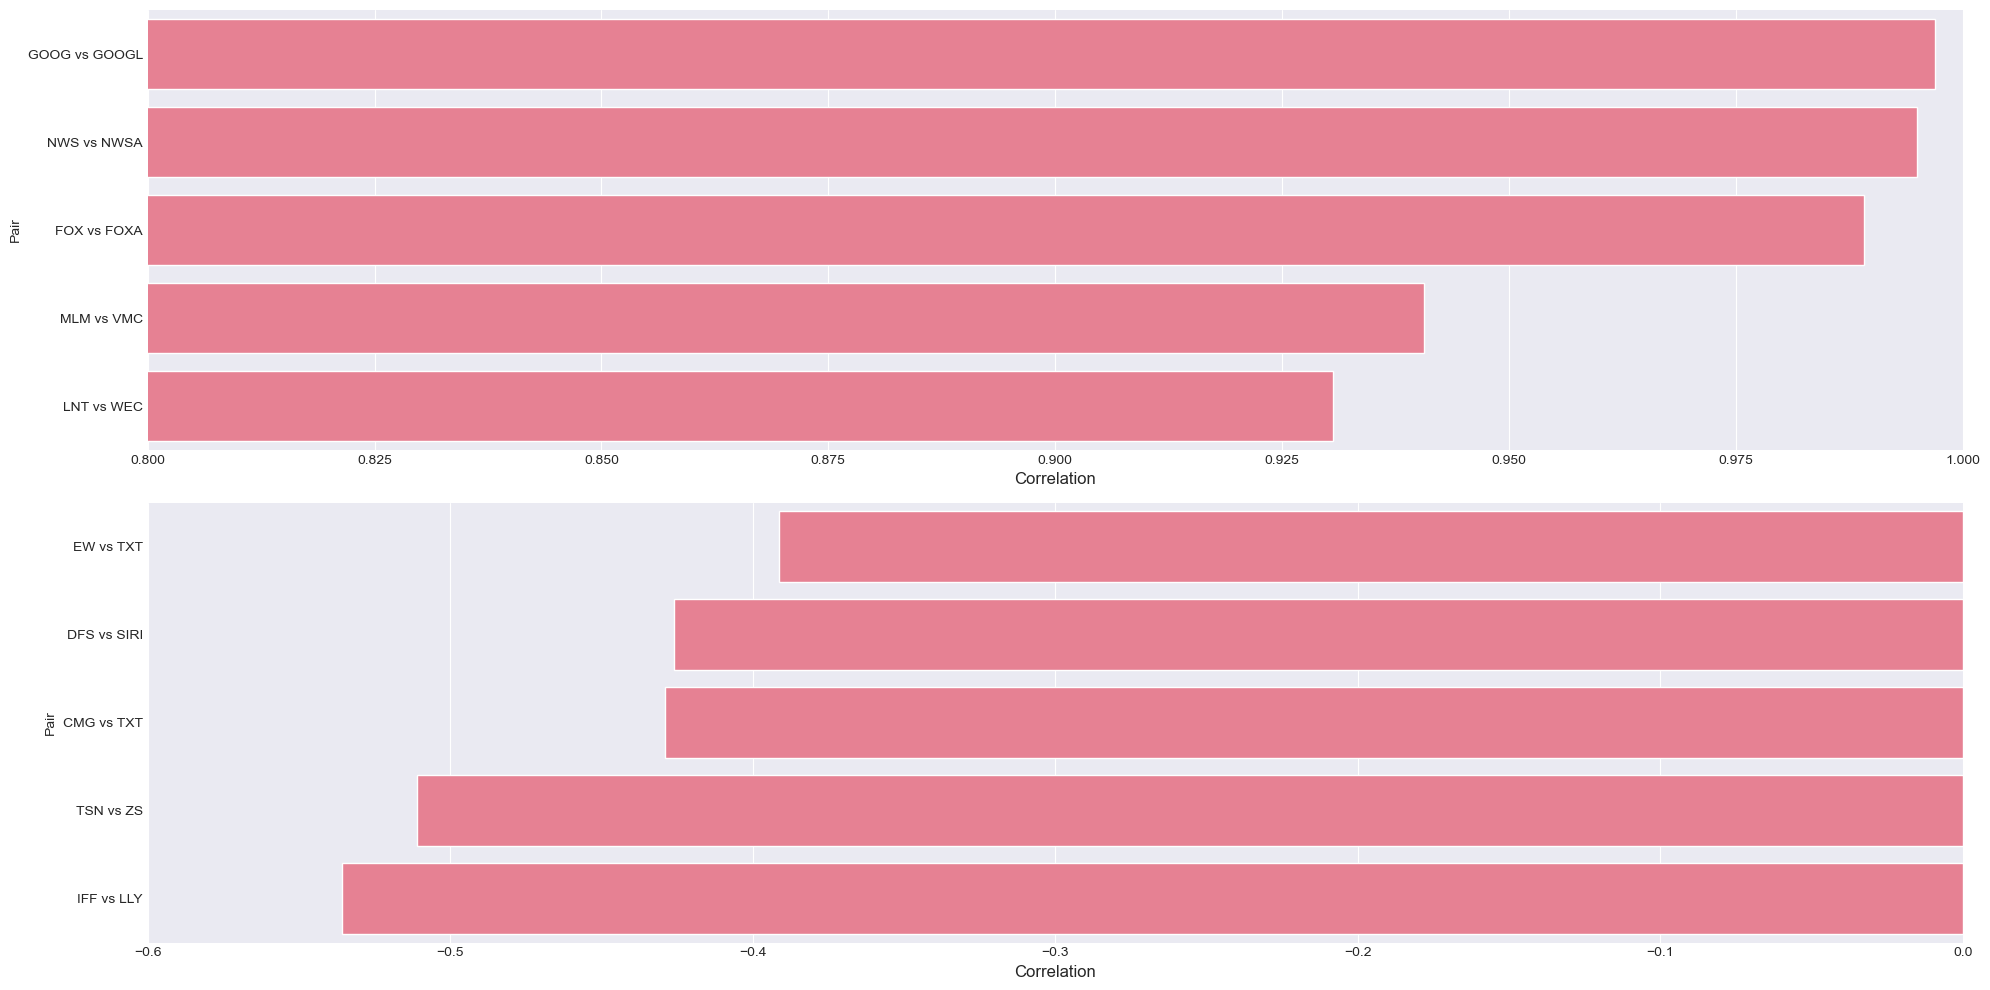

In [200]:
n = 5

corr_df = corr_matrix.stack().reset_index()
corr_df.columns = ['A', 'B', 'Correlation']

corr_df = corr_df[
    (corr_df['A'] != corr_df['B']) & 
    (corr_df['A'] < corr_df['B'])
].sort_values(by='Correlation', ascending=False)

pos = corr_df.head(n)
neg = corr_df.tail(n)

pos['Pair'] = pos['A'] + ' vs ' + pos['B']
neg['Pair'] = neg['A'] + ' vs ' + neg['B']

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

sns.barplot(
    x='Correlation',
    y='Pair',
    data=pos,
    ax=axes[0]
)
axes[0].set_xlabel("Correlation", fontsize=12)
axes[0].set_xlim(0.8, 1.0) 

sns.barplot(
    x='Correlation',
    y='Pair',
    data=neg,
    ax=axes[1]
)
axes[1].set_xlabel("Correlation", fontsize=12)
axes[1].set_xlim(-0.6, 0.0)

plt.tight_layout()
plt.show()



Az esetek többségében a piaci korreláció nem 2 cég közötti viszonyt írja le, hanem kitettségük a piacra tekintettel mennyire egyezik meg.

Pozitív korreláció:
 - A GOOG-GOOGL a Google anyavállalatának, NWS-NWSA a News Corp, FOX-FOXA a Fox Corporation két eltérő osztályú részvénye, ezzel magyarázható a kiemelkedő korreláció, még a top-5-ben is.
 - MLM-VMC: Martin Marietta Materials és a Vulcan Materials Company két legnagyobb szereplője az amerikai építőipari alapanyagok szektorának, tehát erős szektorális és ciklikus korreláció. Mindkét vállalat szorosan függ az amerikai infrastrukturális beruházásoktól és az építőipari aktivitástól, szóval gyakorlatilag nem egymással korrelálnak, hanem a piaci körülményekkel.
 - LNT-WEC: Az Alliant Energy és a WEC Energy Group  regionális amerikai közműszolgáltatók. Mivel üzleti modelljük stabil, szabályozott és nagyrészt monopolisztikus, az őket érintő makrogazdasági és szabályozási változások mindkét céget egyszerre érintik.

Negatív korreláció:
 - EW-TXT: Edwards Lifesciences és Textron két külön ciklus mentén mozognak. Az orvostechnikai cégek stabilabbak, míg a védelmi ipar a kormányzati megrendelésektől és a geopolitikától függ.
 - DFS-SIRI: A pénzügyi cégek (DFS) a kamatlábaktól és a fogyasztói hitelképességtől függnek. A szórakoztatóipari cégek (SIRI) a reklámbevételektől és a fogyasztói hűségtől.
 - CMG-TXT: Chipotle-t főként a nyersanyagárak és a fogyasztói hangulat befolyásolja, míg a Textron a kormányzati ciklusoktól függ.
 - TSN-ZS: Az élelmiszeripari cégek (TSN) nyersanyagkockázattal, keresleti kockázattal szembesülnek, míg a technológiai cégek (ZS) a felhőszolgáltatások iránti kereslettől függnek.
 - IFF-LLY: IFF az alapvető fogyasztói cikkek és a vegyipar ciklusaihoz kötődik, míg a LLY-t a biotechnológiai és a szabályozói környezet dominálja.

### Átlagos korreláció szektorokon belül

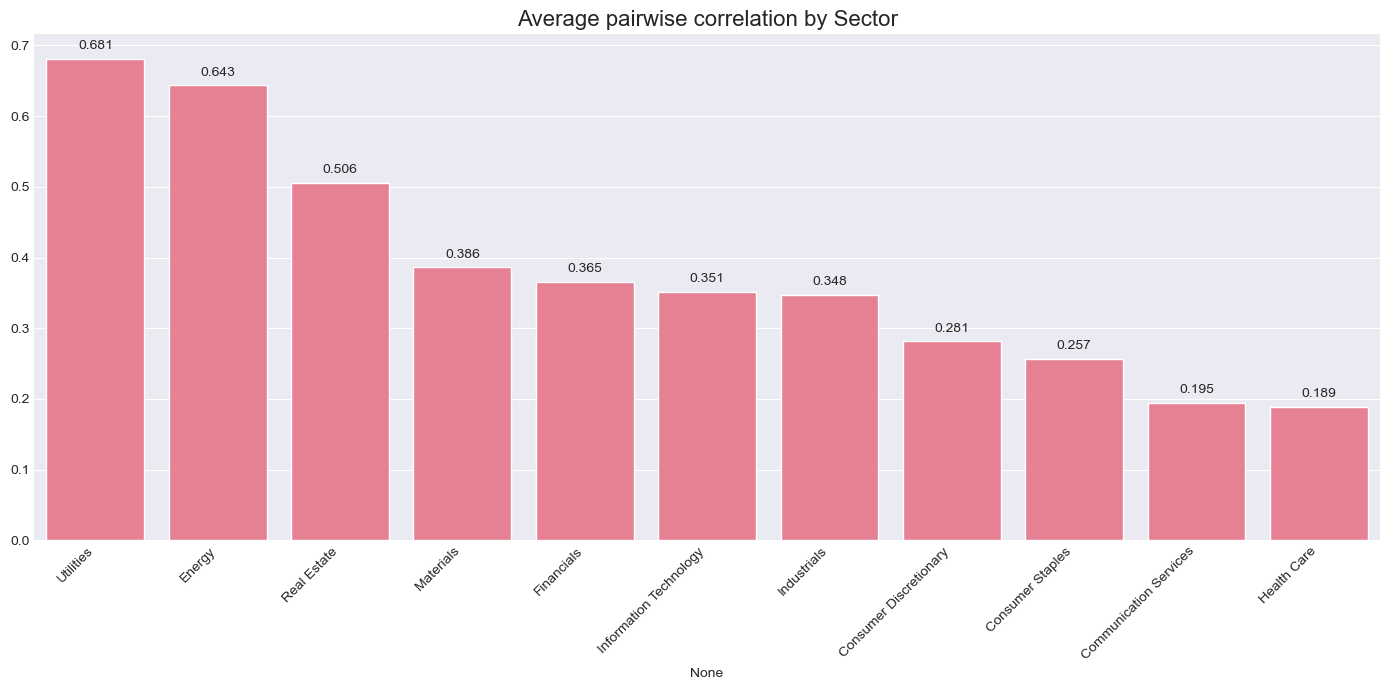

In [201]:
all_sectors_map = pd.concat([
    sp500_companies[['Symbol', 'Sector']],
    dowjones_companies[['Symbol', 'Sector']],
    nasdaq100_companies[['Symbol', 'Sector']]
]).drop_duplicates(subset=['Symbol']).reset_index(drop=True)

all_sectors_map.rename(columns={'Symbol': 'Stock'}, inplace=True)

sector_groups = all_sectors_map.groupby('Sector')['Stock'].apply(list)

sector_correlation_results = {}

for sector_name, symbols in sector_groups.items():
    valid_symbols = [s for s in symbols if s in returns_stocks.columns]
    corr_matrix_forpair = returns_stocks[valid_symbols].corr()

    pairwise_correlations = corr_matrix_forpair.values[np.triu_indices_from(corr_matrix_forpair, k=1)]
    sector_correlation_results[sector_name] = np.mean(pairwise_correlations)


avg_corr_series = pd.Series(sector_correlation_results).sort_values(ascending=False)

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x=avg_corr_series.index,
    y=avg_corr_series.values
)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('Average pairwise correlation by Sector', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


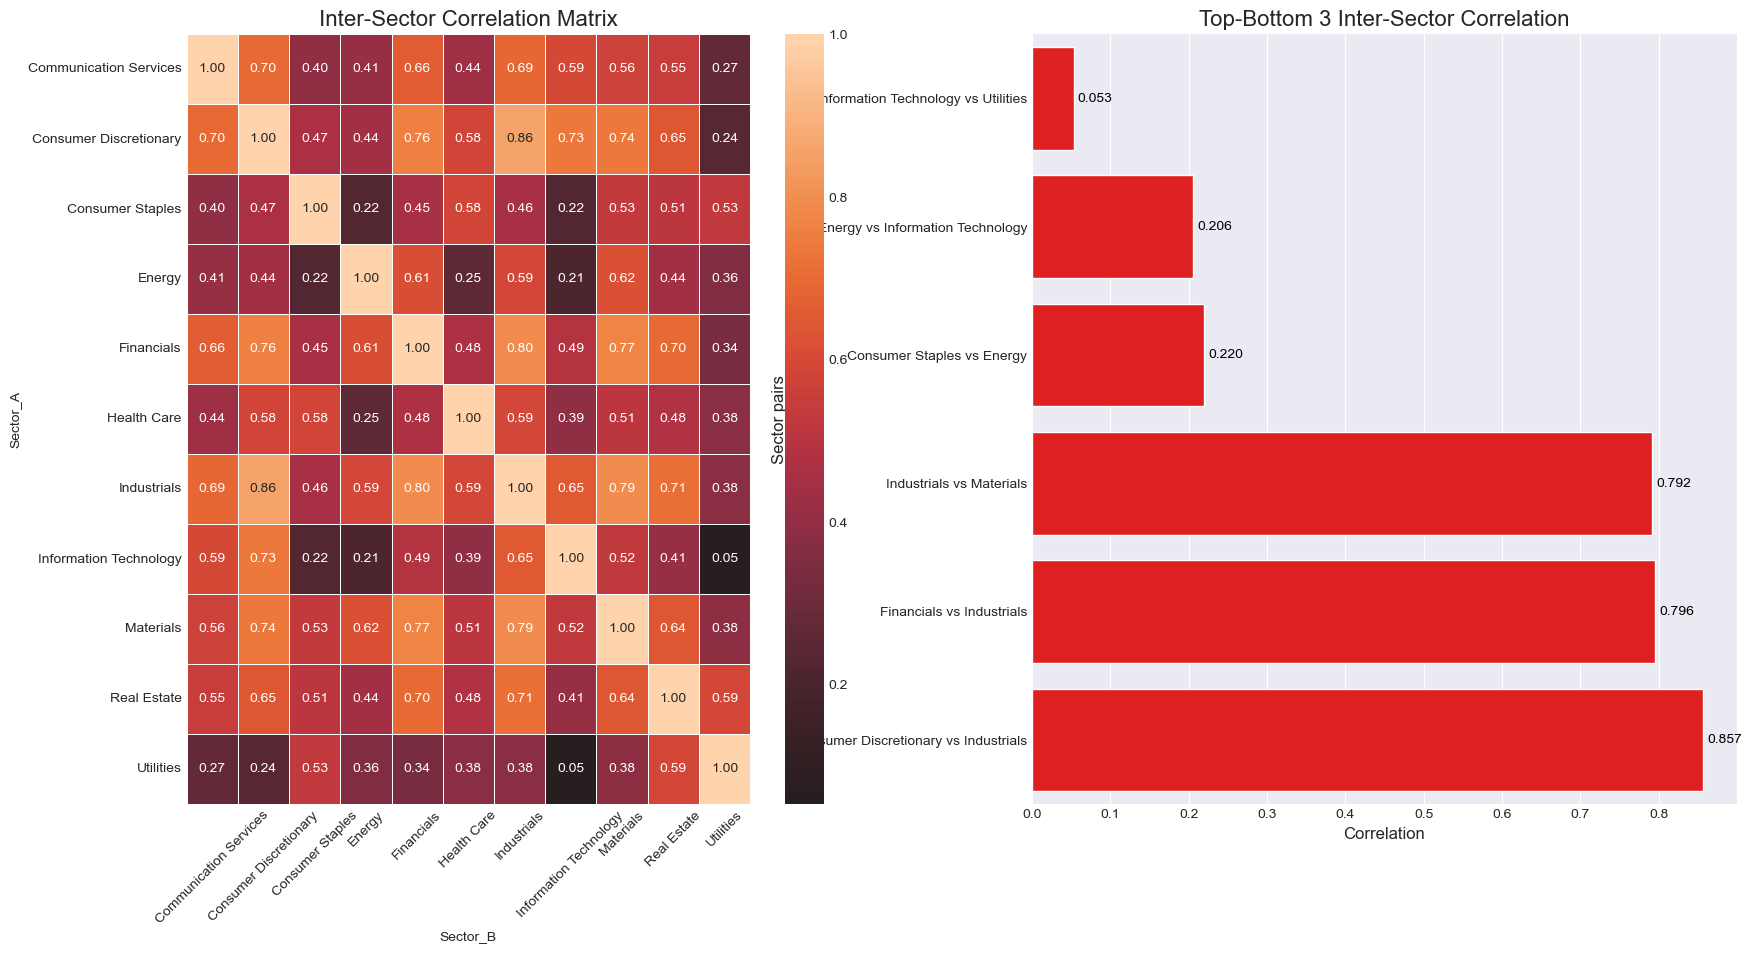

In [202]:
returns_with_sectors = returns_stocks.T.merge(
    all_sectors_map,
    left_index=True,
    right_on='Stock',
    how='inner'
)
returns_with_sectors.set_index('Stock', inplace=True)
returns_with_sectors.dropna(subset=['Sector'], inplace=True)

sector_returns = returns_with_sectors.groupby('Sector').mean().T
sector_returns.index = pd.to_datetime(sector_returns.index)


sector_corr_matrix = sector_returns.corr()
sector_corr_matrix.index.name = 'Sector_A'
sector_corr_matrix.columns.name = 'Sector_B'


corr_df_sector = sector_corr_matrix.stack().reset_index()
corr_df_sector.columns = ['Sector_A', 'Sector_B', 'Correlation']

corr_df_filtered = corr_df_sector[
    (corr_df_sector['Sector_A'] < corr_df_sector['Sector_B'])
].copy()

N = 3
top_pos = corr_df_filtered.sort_values(by='Correlation', ascending=False).head(N)
top_neg = corr_df_filtered.sort_values(by='Correlation', ascending=True).head(N)

plot_data = pd.concat([top_pos, top_neg]).sort_values(by='Correlation', ascending=True) # Növekvő sorrend a vízszinteshez
plot_data['Pair'] = plot_data['Sector_A'] + ' vs ' + plot_data['Sector_B']


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(
    sector_corr_matrix,
    annot=True,
    center=0,
    fmt=".2f",
    linewidths=.5,
    ax=axes[0]
)
axes[0].set_title("Inter-Sector Correlation Matrix", fontsize=16)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', rotation=0, labelsize=10)
axes[0].set_ylabel(sector_corr_matrix.index.name)
axes[0].set_xlabel(sector_corr_matrix.columns.name)


ax = sns.barplot(
    x='Correlation',
    y='Pair',
    data=plot_data,
    palette=['blue' if c < 0 else 'red' for c in plot_data['Correlation']],
    ax=axes[1]
)

for index, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_width():.3f}',
                (p.get_width() + 0.005, p.get_y() + p.get_height() / 2),
                ha='left', va='center',
                color='black',
                fontsize=10)

axes[1].set_title(f"Top-Bottom {N} Inter-Sector Correlation", fontsize=16)
axes[1].set_xlabel("Correlation", fontsize=12)
axes[1].set_ylabel("Sector pairs", fontsize=12)

plt.show()

Magas Pozitív Korreláció: Ezek a párok (pl. Consumer Discretionary vs. Industrials, Information Technology vs. Communication Services) 0.7 feletti korrelációval rendelkeznek.
 - Pénzügyi Ok: Ezek a szektorok ciklikusak vagy növekedési fázisban lévők, és szoros függőségben állnak az általános gazdasági hangulattal.
 - Mozgás: Ha a gazdasági növekedés erős, a fogyasztás nő,  a technológiai befektetések megindulnak, ekkor ezek a szektorok egyszerre emelkednek, ellenkező esetben szintén hasonlóan esnek.

Alacsony/Negatív Korreláció: Ezek a párok (pl. Information Technology vs. Utilities, Consumer Staples vs. Energy) a skála alján helyezkednek el, gyakran 0.3 alatt.
 - Pénzügyi Ok: Ezek a párok eltérő gazdasági faktorokra reagálnak, néha ellentétes irányba is mozognak.
    - A közművek és az alapvető fogyasztási cikkek defenzív szektorok. Ezek a cégek stabil cash flow-val rendelkeznek, és az emberek recesszió alatt is veszik a termékeiket. Amikor a piac egésze esik, a defenzív szektorok jobban tartják magukat.
    - Kamatérzékenység: A Utilities szektor árfolyama érzékeny a kamatlábakra, míg a Growth szektorok inkább  a jövőbeli kilátásokra.

### Hipotézis: korreláció szerinti csoportosítással szektorokra lehet bontani a részvényeket

11 klaszterre bontom a részvényeket (ennyi szektor van) korrelációjuk alapján.

#### Hierarchikus klaszterezés


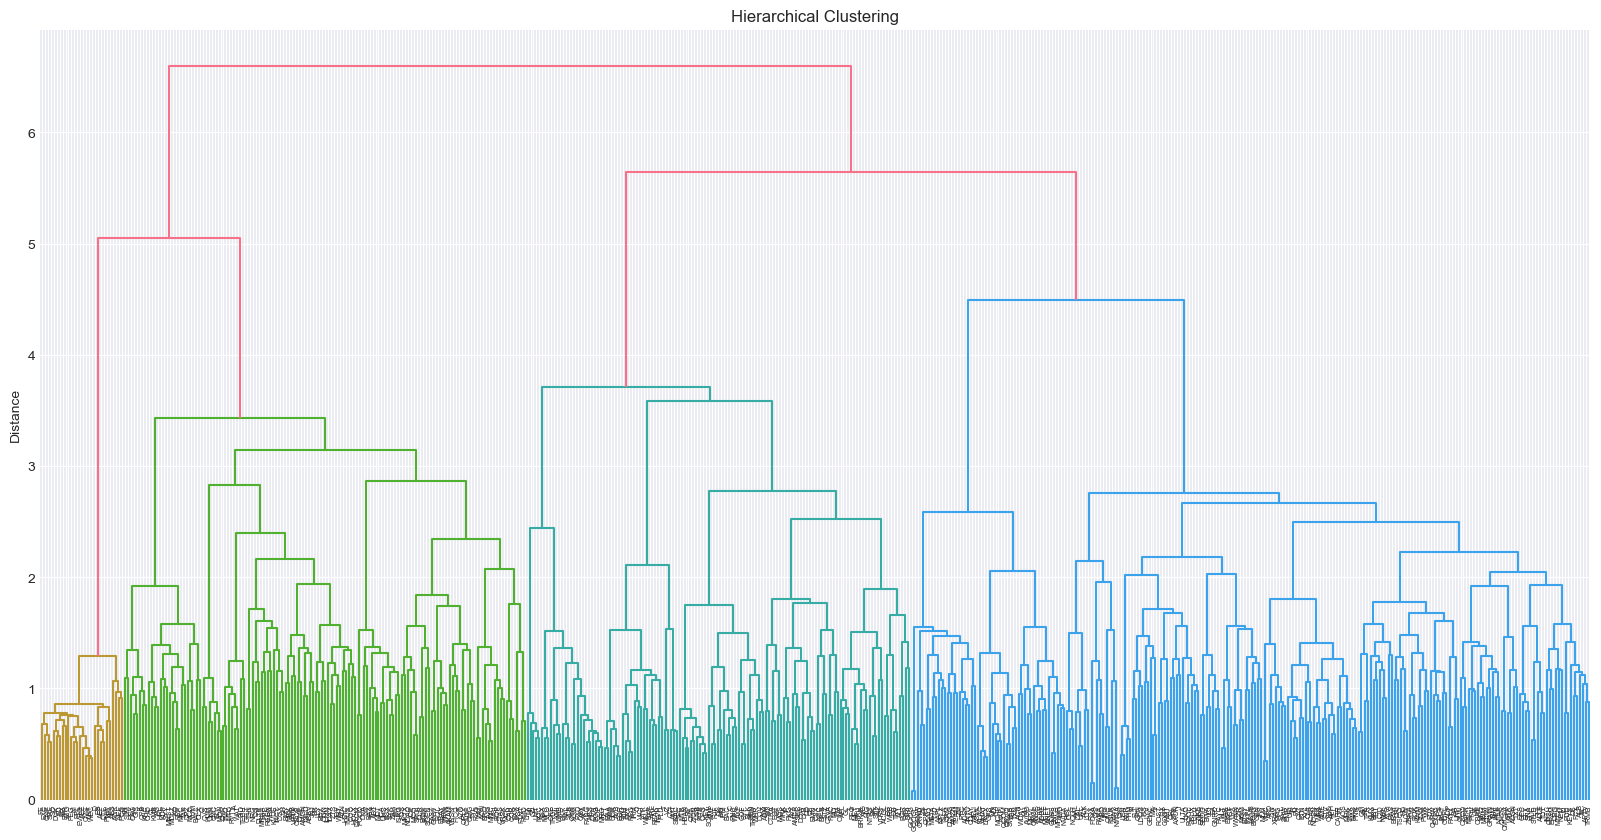

In [203]:
from scipy.spatial.distance import squareform

dist = np.sqrt(2 * (1 - corr_matrix))
dist_condensed = squareform(dist, checks=False)

linkage_result = linkage(dist_condensed, method="ward")

plt.figure(figsize=(20, 10))
dendrogram(linkage_result, orientation='top', labels=corr_matrix.columns.tolist())

plt.title("Hierarchical Clustering")
plt.ylabel("Distance")
plt.show() # 

num_clusters = 11
clusters = fcluster(linkage_result, num_clusters, criterion='maxclust')

cluster_df = pd.DataFrame({
    'Stock': returns_stocks.columns,
    'Cluster': clusters
})

Accuracy after mapping:                  0.5356
Macro F1:                                0.5262
Average cluster purity:                  0.7553

Adjusted Rand Index:                     0.2900
Normalized Mutual Information:           0.5268



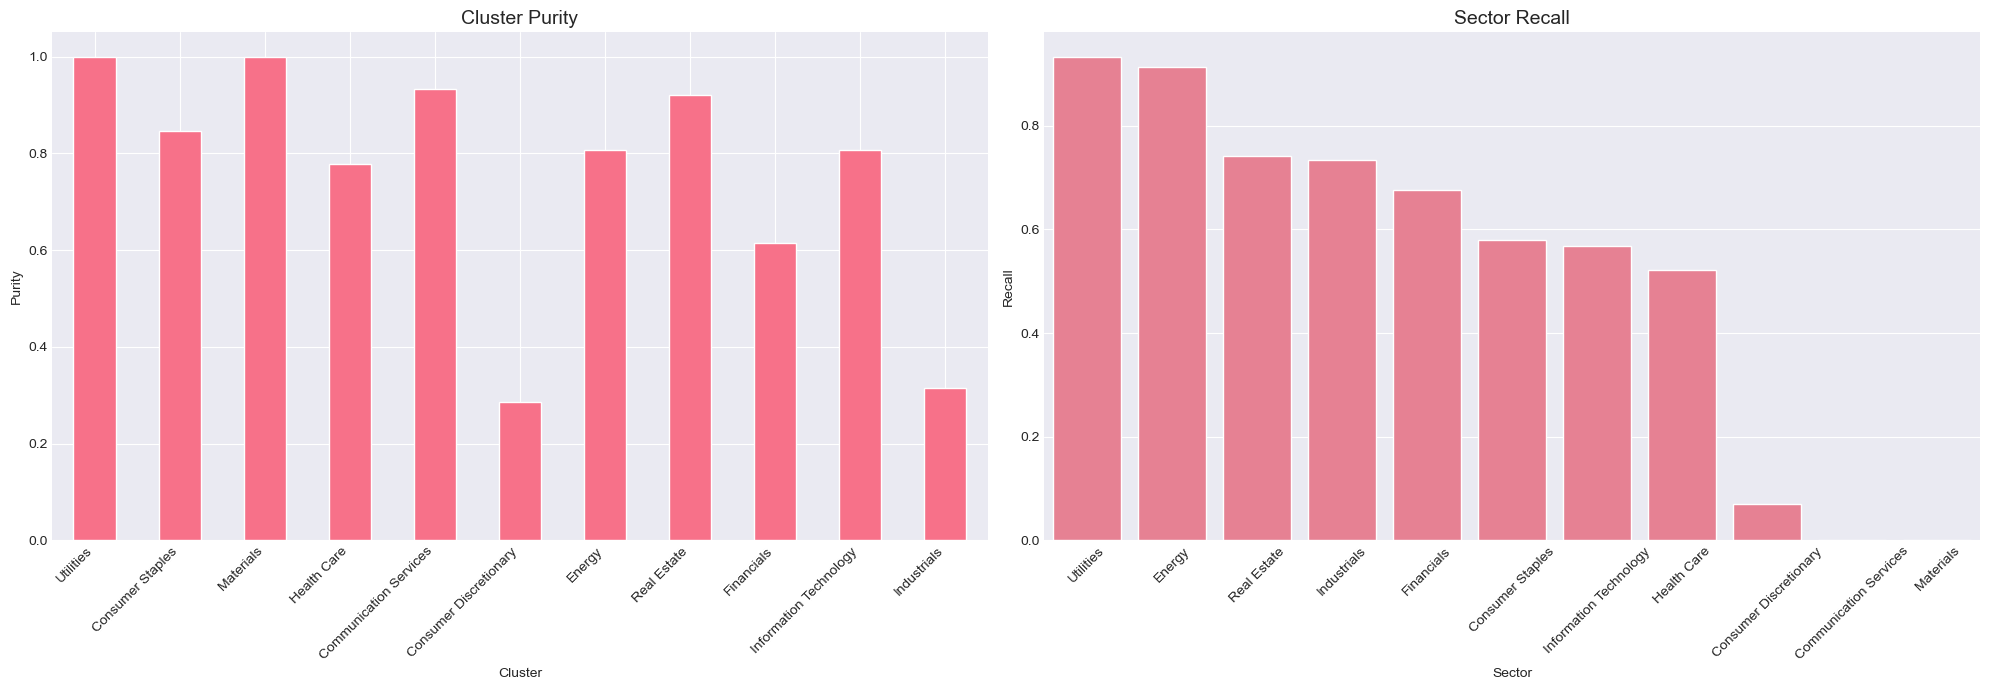

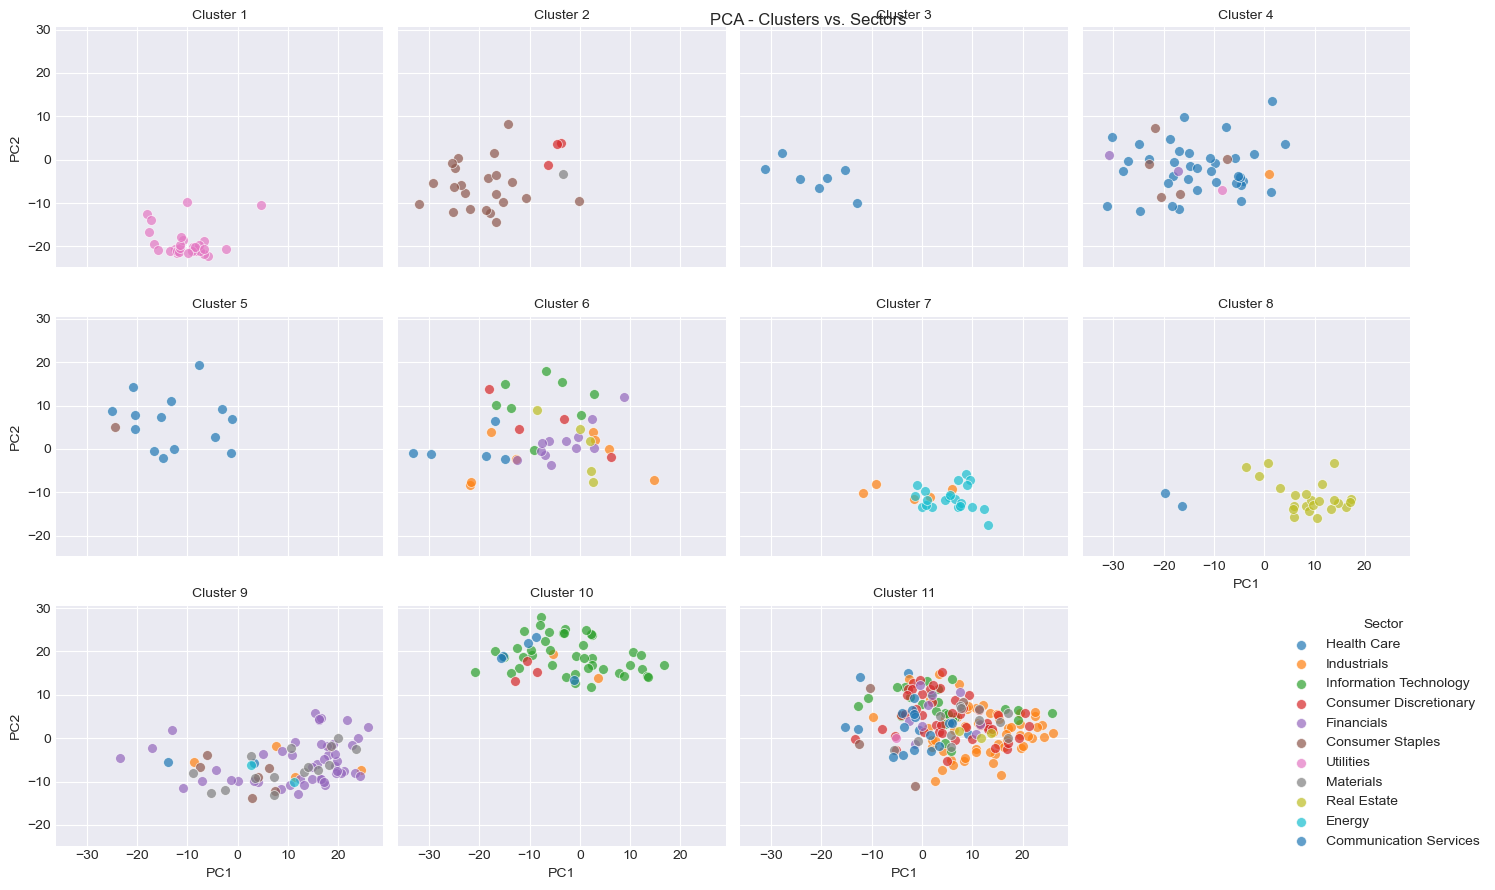

In [204]:
from scipy.optimize import linear_sum_assignment
import pandas as pd
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    accuracy_score,
    f1_score, recall_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# 1. Szektor Adatok Egyesítése és Tisztítása
all_sectors = pd.concat([
    sp500_companies[['Symbol', 'Sector']],
    dowjones_companies[['Symbol', 'Sector']],
    nasdaq100_companies[['Symbol', 'Sector']]
]).drop_duplicates(subset=['Symbol']).reset_index(drop=True)

all_sectors.rename(columns={'Symbol': 'Stock'}, inplace=True)

init_comparison_df = pd.merge(
    cluster_df,
    all_sectors,
    on='Stock',
    how='left'
)

comparison_df = init_comparison_df.dropna(subset=['Sector']).copy()

clusters_pred = comparison_df['Cluster'].values
sectors_true = comparison_df['Sector'].values

# Hungarian Algorithm
ct = pd.crosstab(comparison_df["Sector"], comparison_df["Cluster"])
total = ct.values.sum()

row_idx, col_idx = linear_sum_assignment(-ct.values)
best_matches = {ct.columns[c]: ct.index[r] for r, c in zip(row_idx, col_idx)}

#Metrikák
le = LabelEncoder()
y_true = le.fit_transform(comparison_df["Sector"])
y_pred_raw = comparison_df["Cluster"].values
mapped_sector = comparison_df["Cluster"].map(best_matches)
y_pred = le.transform(mapped_sector)

purity = (comparison_df.groupby("Cluster")["Sector"]
             .agg(lambda s: s.value_counts(normalize=True).max())
             .sort_index())

recall_df = pd.DataFrame({
    'Sector': le.classes_,
    'Recall': recall_score(y_true, y_pred, average=None)
})
recall_df = recall_df.sort_values(by='Recall', ascending=False).set_index('Sector')


print(f"Accuracy after mapping:                  {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:                                {f1_score(y_true, y_pred, average="macro"):.4f}")
print(f"Average cluster purity:                  {purity.mean():.4f}\n")

print(f"Adjusted Rand Index:                     {adjusted_rand_score(y_true, y_pred_raw):.4f}")
print(f"Normalized Mutual Information:           {normalized_mutual_info_score(y_true, y_pred_raw):.4f}\n")

fig, ax = plt.subplots(1,2,figsize=(20, 7))

purity.plot(kind="bar", ax=ax[0])
ax[0].set_title("Cluster Purity", fontsize=14) # Javított cím
ax[0].set_ylabel("Purity")
ax[0].set_xticklabels([best_matches[i] for i in purity.index], rotation=45, ha="right")

sns.barplot(
    x=recall_df.index,
    y='Recall',
    data=recall_df,
    ax=ax[1]
)
ax[1].set_title('Sector Recall', fontsize=14) # Javított cím
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Sector')
ax[1].tick_params(axis='x', rotation=45)

fig.tight_layout()
fig.show()


x_std = StandardScaler().fit_transform(corr_matrix)
x_pca = PCA(n_components=2, random_state=random_state).fit_transform(x_std)

pca_df = pd.DataFrame(data=x_pca, columns=['PC1', 'PC2'], index=corr_matrix.index)
viz_df = pca_df.merge(comparison_df, left_index=True, right_on='Stock', how='inner')

g = sns.FacetGrid(viz_df, col="Cluster", col_wrap=4, hue="Sector", palette="tab10", height=3, aspect=1.2)
g.map(sns.scatterplot, "PC1", "PC2", s=50, alpha=0.7)
g.add_legend(title="Sector",loc='upper center',  bbox_to_anchor=(0.85, 0.32))
g.set_titles("Cluster {col_name}")
plt.suptitle('PCA - Clusters vs. Sectors')
plt.show()

 - Adjusted Rand Index: Az 1.0-hoz képest alacsony, azt jelzi, hogy a korreláció alapú klaszterezés nem egyezik szorosan a hivatalos szektorális besorolással, még a véletlen hatásának kiszűrésével sem. Ez a hipotézis elutasításának legfőbb alapja.
 - Normalized Mutual Information: Méri az információ-átfedést. A közepes érték megerősíti, hogy van átfedés, de a két csoportosítás nem azonos.
 - Average cluster purity: A 75% feletti érték azt jelenti, hogy a korreláció alapján létrehozott csoportok belsőleg nagyon homogének. Ha egy részvény bekerül egy klaszterbe, nagy valószínűséggel a többi részvény is ugyanahhoz a domináns szektorhoz tartozik. Ez igazolja, hogy a Ward klaszterezés hatékonyan hozott létre jól elkülönülő csoportokat.
 - Accuracy after mapping: A korreláció alapján besorolt részvények kb. fele került a hivatalos szektorához optimálisan hozzárendelt klaszterbe. Ez a mérték megerősíti, hogy a hipotézis részben állja meg a helyét, de az egyezés csak mérsékelt
 - Macro F1: Hasonlóan az Accuracy-hez, a közepes érték a mérsékelt, de nem tökéletes egyezést mutatja, figyelembe véve a szektorok méretét is.
 - A recall grafikonon megfigyelhető. hogy a sorrend hasonlít a korábbi szektoron belüli átlagos korrelációt ábrázoló grafikonra, ami logikus, mivel a korreláció mértéke alapján osztályozzuk a részvényeket. A külömbségek abból adódnak, hogy nem csak a tömörség (korreláció), hanem az elkülönültség is számít. Például a Health Care nem tömör a többihez képest, viszont mivel eléggé elkülönült, relatív jó a recall. Viszont a Materials tömörsége hasonló a Health Care-hez, de mivel nincs annyira elkükönülve, ezért szétszóródik a többi klaszter közt.

Összegzés: Adjusted Rand Index (ARI) alacsony értéke (0.2900) alapján a hipotézis, miszerint a korreláció szerinti csoportosítással pontosan szektorokra lehet bontani a részvényeket, elutasítható. Azonban az Average Cluster Purity (0.7553) magas értéke azt mutatja, hogy a klaszterezés nem véletlenszerű. A kapott csoportok viselkedésileg hasonlóak, ami azt jelenti, hogy a korreláció szektorokon átívelő viselkedési csoportokat (pl. növekedési részvények, kamatérzékeny részvények) azonosít, nem pedig kizárólag a hivatalos szektorokat.

# Hipotézisek

## Az indexek (és részvények) hozama nem autokorrelál

Amióta érdekel ez a téma, a kereskedési stratégiákról gyakran olyan kontextusban olvasok, ahol az egyik kulcsmondat az, hogy *"past performance is not indicative of future results"*. Tehát ha egy stratégia backtest-en rendkívüli hozamot tud elérni, az nem garantálja, hogy ez a jövőben is így lesz.
Statisztikai értelemben ez azt jelenti, hogy a hozamok időben nem mutatnak autokorrelációt:  a mai hozam nem függ a tegnapi vagy korábbi hozamoktól.
A következő grafikon ezt a hipotézist vizsgálja, és azt próbálja igazolni, hogy a hozamok „emlékezet nélküliek”.


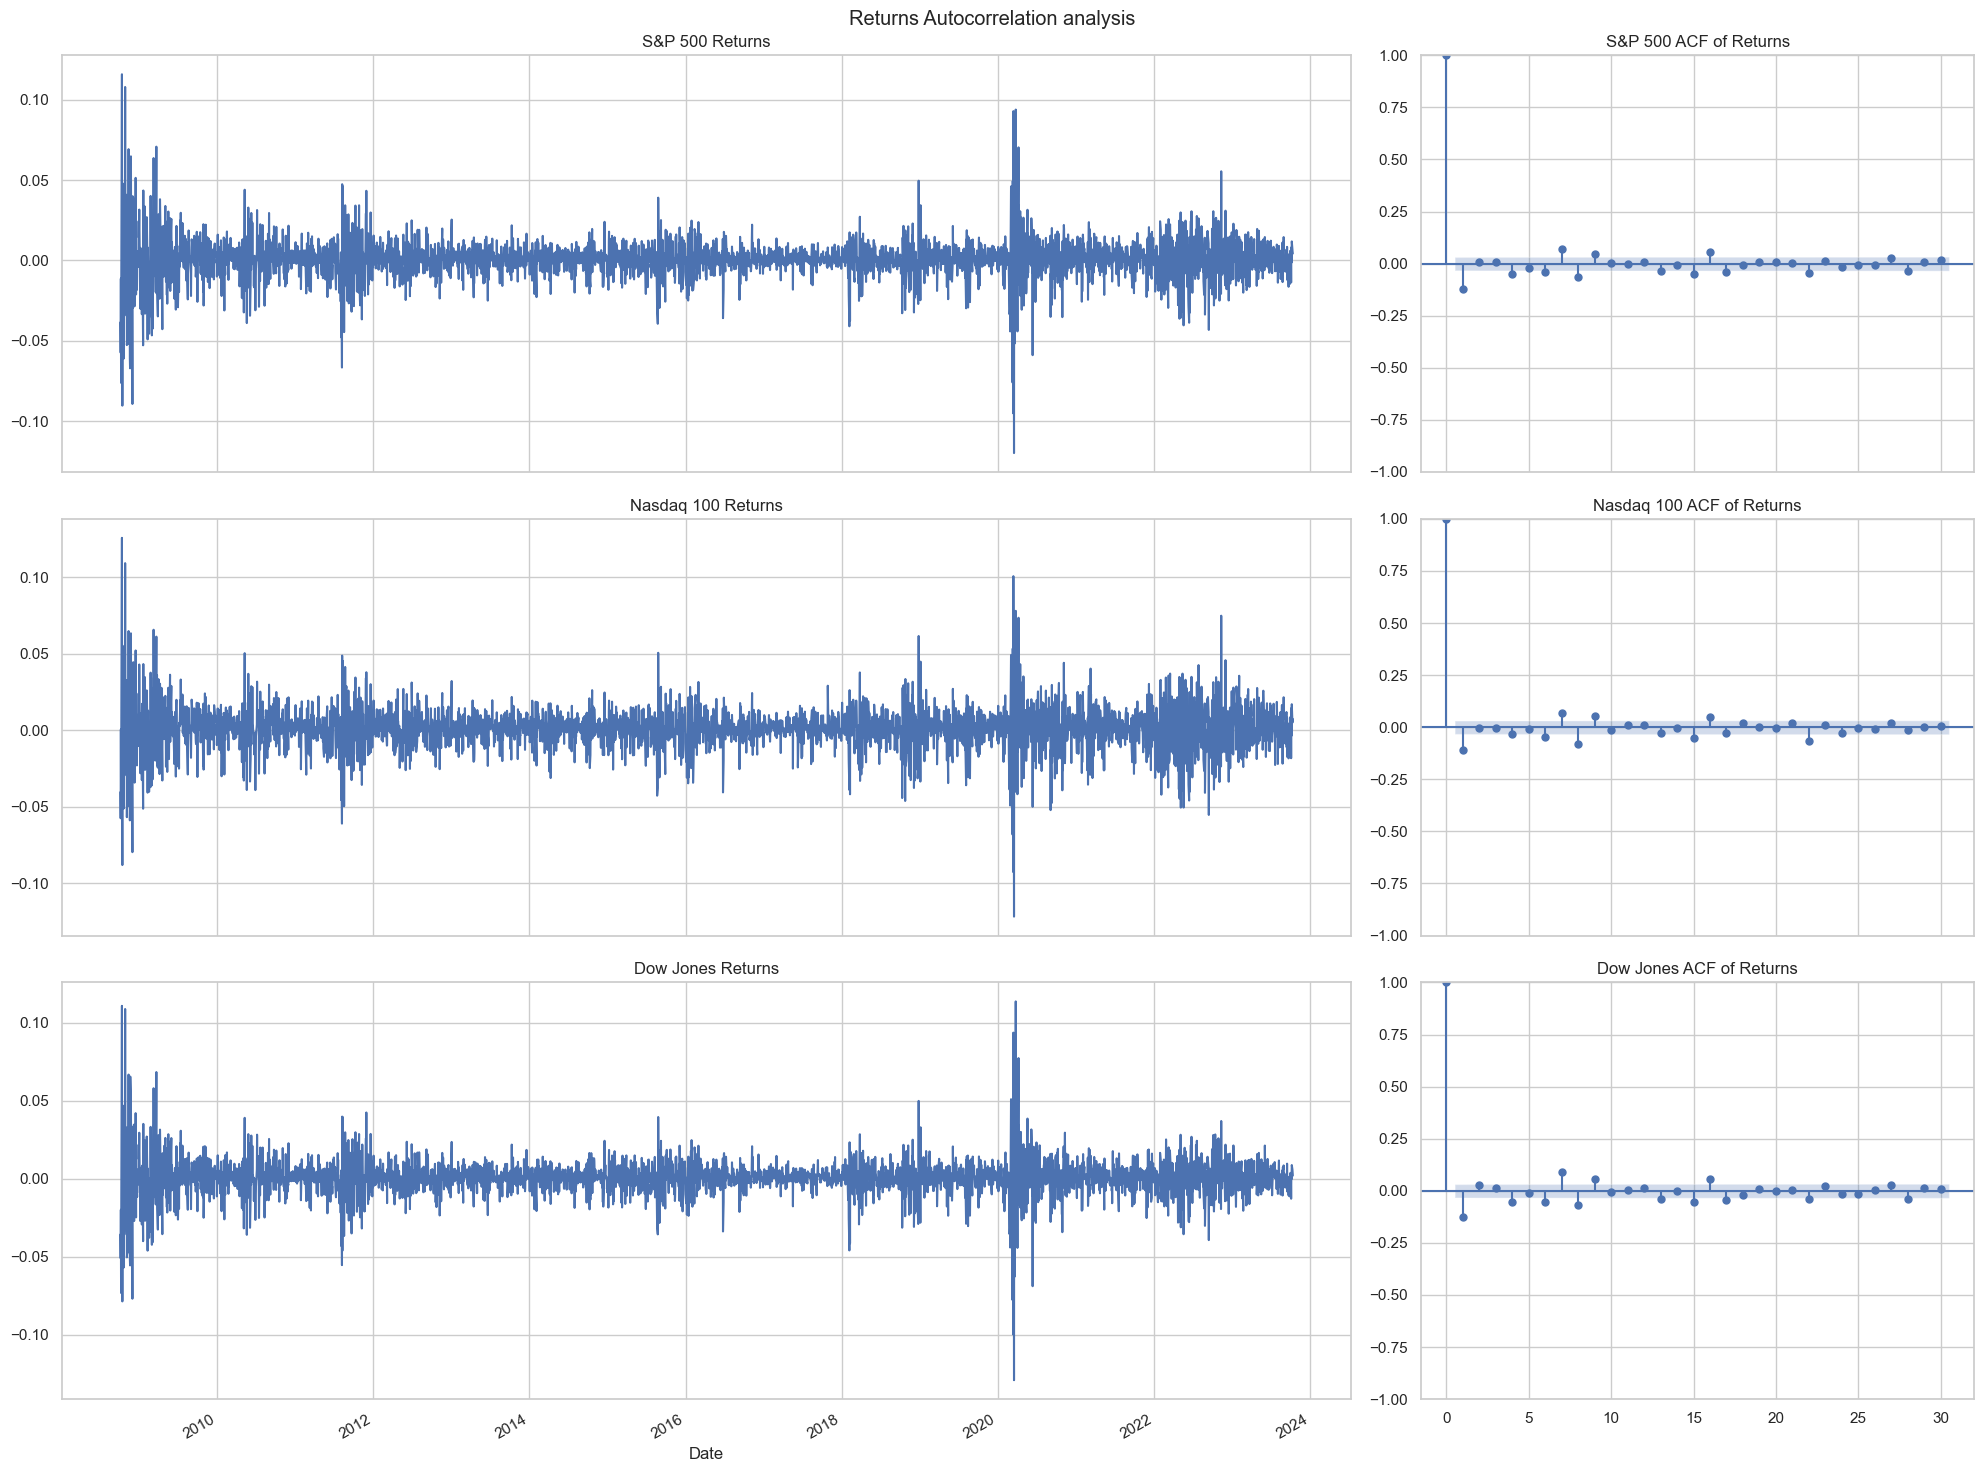

In [74]:
lookback_days = 252*15

fig, axs = plt.subplots(len(indeces), 2, figsize=(20, 15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
fig.suptitle("Returns Autocorrelation analysis")

for i, (name, idx) in enumerate(indeces.items()):
    idx['Return'].iloc[-lookback_days:].plot(ax=axs[i,0])
    axs[i,0].set_title(f"{name} Returns")

    plot_acf(idx['Return'].iloc[-lookback_days:].dropna(), lags=30, ax=axs[i,1])
    axs[i,1].set_title(f"{name} ACF of Returns")

plt.tight_layout()
plt.show()

A bal oldali ábra az idősor tényleges, százalékos hozamait mutatja, időben egymás után.
Ez alapján látható, hogy a hozamok ingadoznak, de vizuálisan nem látszik tartós trend vagy ismétlődő mintázat.

A jobb oldali ábra ugyanezen hozamok ACF-je.
Ha a hozamok nem autokorrelálnak, akkor az ACF értékei a nulla körül szóródnak, és egyik késleltetésnél sincs szignifikáns kiugrás.
Ez azt jelenti, hogy a múltbeli hozamok nem hordoznak előrejelző erőt a jövőbeli hozamokra, vagyis az idősor „emlékezet nélküli”.

Ez teljesen logikus, hiszen ha lenne bármilyen ismert összefüggés, annak hatása már rásze lenne a jelenlegi árnak, ezzel kioltva hasznosságát.

## Az indexek (és részvények) volatilitása autokorrelál

A hozammal ellentétben a volatilitás nem határoz meg irányt, tehát nem lehet része az árnak (legalábbis részvények esetén; más pénzpiaci termékeknél lehet közvetlen hatása). Feltevésem, hogy magasabb volatilitású időszakot jellemzően további magas volatilitású időszak követi.


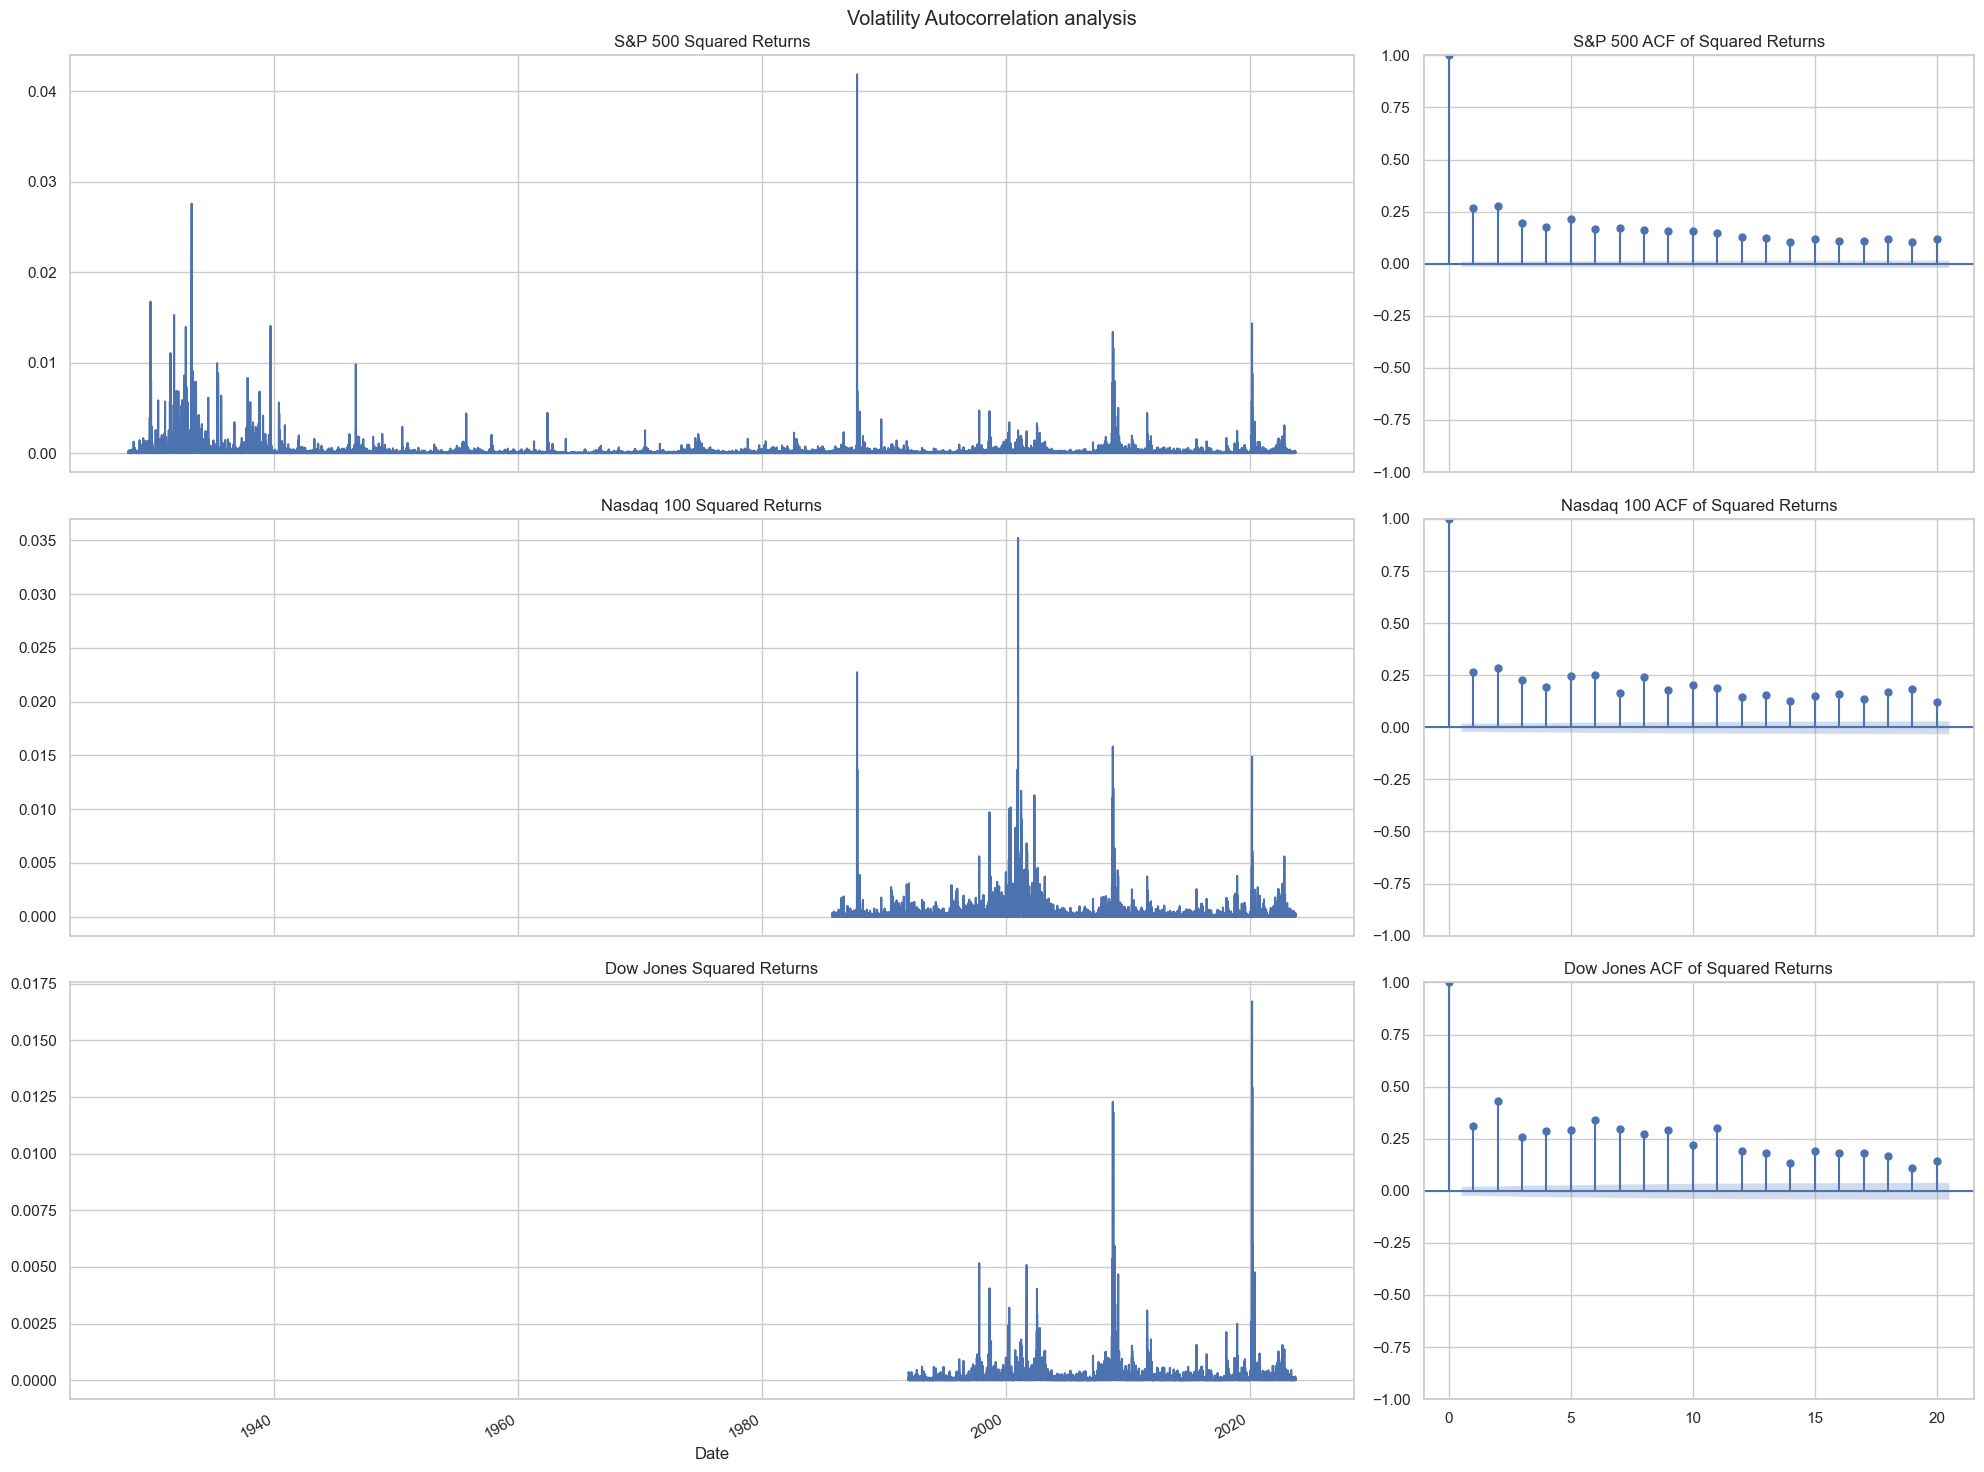

In [75]:
test_results = {}
acf_lag = 20

fig, axs = plt.subplots(len(indeces), 2, figsize=(20, 15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
fig.suptitle("Volatility Autocorrelation analysis")

for i, (name, idx) in enumerate(indeces.items()):
    idx["Squared return"]=idx['Return']**2
    idx["Squared return"].plot(ax=axs[i,0])
    axs[i,0].set_title(f"{name} Squared Returns")

    plot_acf(idx["Squared return"].dropna(), lags=acf_lag, ax=axs[i,1])
    axs[i,1].set_title(f"{name} ACF of Squared Returns")

plt.tight_layout()
plt.show()


Már a négyzetes hozam grafikonján is megfigyelhetőek hullámok kiugró értékek körül, tehát nem túl meglepő, amikor az ACF-en is láthatóak jelentős értékek, még huszas lag mellett is.

Ezt a jelenséget szaknyelven *volatility clustering*-nek is szokták hívni

## Az inflációs kötnyezet hatása szektoronként

Amikor inflációról beszélünk, gyakran hajlamosak vagyunk egyetlen, mindent elsöprő mutatóként tekinteni rá, amely egységesen befolyásolja a gazdaságot. Azonban a piaci folyamatokat közelebbről vizsgálva hamar világossá válik, hogy az infláció változása nem egyformán érinti a szereplőket. Személyes kiváncsiságom folyamán többször is belefutottam bizonyos útmutatókba, melyek magas inflációs környezetben hivatottak befektetési tanácsokat adni. Ez által motiválva meg fogom vizsgálni, hogy milyen különbségek lépnek fel bizonyos szektorok közt különböző inflációs környezetben.


## After hours - Normal hours hozam vizshálata

A modern részvénypiacok egyik legérdekesebb kettőssége a kereskedési időszakok szerkezetéből adódik. Miközben a grafikonokon gyakran egy folytonos vonalat látunk, a valóságban két élesen elkülöníthető szakasz váltja egymást: a napközbeni kereskedés (Intraday / Normal hours) és a zárástól nyitásig tartó időszak (Overnight / After hours). Ez a vizsgálat azt hivatott feltárni, hogy létezik-e szisztematikus eltérés a két periódus teljesítménye között.

 - Információs aszimmetria: A fontos vállalati jelentések, makrogazdasági adatok és váratlan politikai események gyakran a tőzsdezárás után látnak napvilágot. Ezek hatása a másnapi nyitóárban („gap”) árazódik be.
 - Likviditás és volatilitás: A hivatalos nyitvatartás alatt a nagy intézményi befektetők aktivitása és a magas likviditás dominál, míg az éjszakai szakaszban az alacsonyabb forgalom miatt a piac érzékenyebb lehet a sokkokra.
 - Anomáliák keresése: Számos kutatás (például az amerikai indexek esetén) arra mutatott rá, hogy a hosszú távú emelkedő trend jelentős része az éjszakai órákban realizálódik, míg a napközbeni szakasz gyakran oldalazást vagy korrekciót mutat.

A vizsgálat módszertana: A számítás során az alábbi két komponenst hasonlítjuk össze naponta:
 - Overnight hozam: A mai nyitóár és az előző napi záróár különbsége.
 - Intraday hozam: A mai záróár és a mai nyitóár különbsége.

A célunk annak meghatározása, hogy a választott indexeknél a napközbeni és az éjszakai hozam különbsége milyen eloszlást mutat az elmúlt 40 év távlatában.


In [ ]:
lookback_years = 40

return_diff = {}

for name, idx in indeces.items():
    df = idx.sort_index().copy()

    # lookback_years-re korlátoz
    all_years = df['Year'].unique()
    last_years = all_years[-lookback_years:] if len(all_years) >= lookback_years else all_years
    df = df[df['Year'].isin(last_years)]

    df['PrevClose'] = df['Close'].shift(1)

    # 0-ás open price esetén
    df['Open_fixed'] = df['Open']
    mask_zero = df['Open_fixed'] == 0
    df.loc[mask_zero, 'Open_fixed'] = df.loc[mask_zero, 'PrevClose']

    df = df.dropna(subset=['Open_fixed', 'PrevClose', 'Close'])
    df = df[df['Open_fixed'] != 0]

    df['OvernightReturn'] = (df['Open_fixed'] - df['PrevClose']) / df['PrevClose']
    df['IntradayReturn'] = (df['Close'] - df['Open_fixed']) / df['Open_fixed']

    return_diff[name] =  df['IntradayReturn'] - df['OvernightReturn']

fig, axs = plt.subplots(len(indeces), 2, figsize=(20,15), sharex=False, sharey=True, gridspec_kw={'width_ratios': [7, 2]})

for i, name in enumerate(indeces.keys()):
    ax_line = axs[i,0] if len(indeces) > 1 else axs[0]

    ax_line.plot(return_diff[name].index, return_diff[name], color='green')
    ax_line.set_title(f"{name} — Intraday Minus Overnight Return")
    ax_line.grid(True, axis='y')
    ax_line.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    ax_box = axs[i,1] if len(indeces) > 1 else axs[1]

    ax_box.boxplot(return_diff[name].values, vert=True, patch_artist=True, widths=0.6, showfliers=False)

    ax_box.grid(True, axis='y', linestyle='--', alpha=0.7)
    median_val = return_diff[name].median()
    ax_box.axhline(median_val, color='red', linestyle='--', linewidth=1)
    ax_box.text(1, median_val, f"Median: {median_val:.4f}", color='green',
            va='center', ha='center', fontsize=14)


plt.tight_layout()
plt.show()

A boxplotok mediánja mindkét index esetében rendkívül közel van a 0-hoz. Ez arra utal, hogy a vizsgált teljes időszak átlagában a két session-nek nincs tartós előnye egymással szemben.

A vonaldiagramok azt mutatják, hogy a legnagyobb pozitív vagy negatív kiugrások a piaci stressz idején (pl. 2008-as válság) jelentek meg. Ez azt jelzi, hogy a válságok alatt információs egyensúlyhiány lép fel, és egy nagy, sokk alapú Overnight mozgást gyakran egy ellentétes, pánik alapú Intraday mozgás követ.

## Év hónapjainak átlagos hozama, volatilitása

A témával való ismerkedésem és beszélgetések folyamán gyakran hallottam, hogy a nyár végi - őszi hónapok a legrosszabbak részvények teljesítményére tekintettel.
Ebben a felyezetben ezt a feltevést fogom megvizsgálni, és kutatással okot találni az eredményre

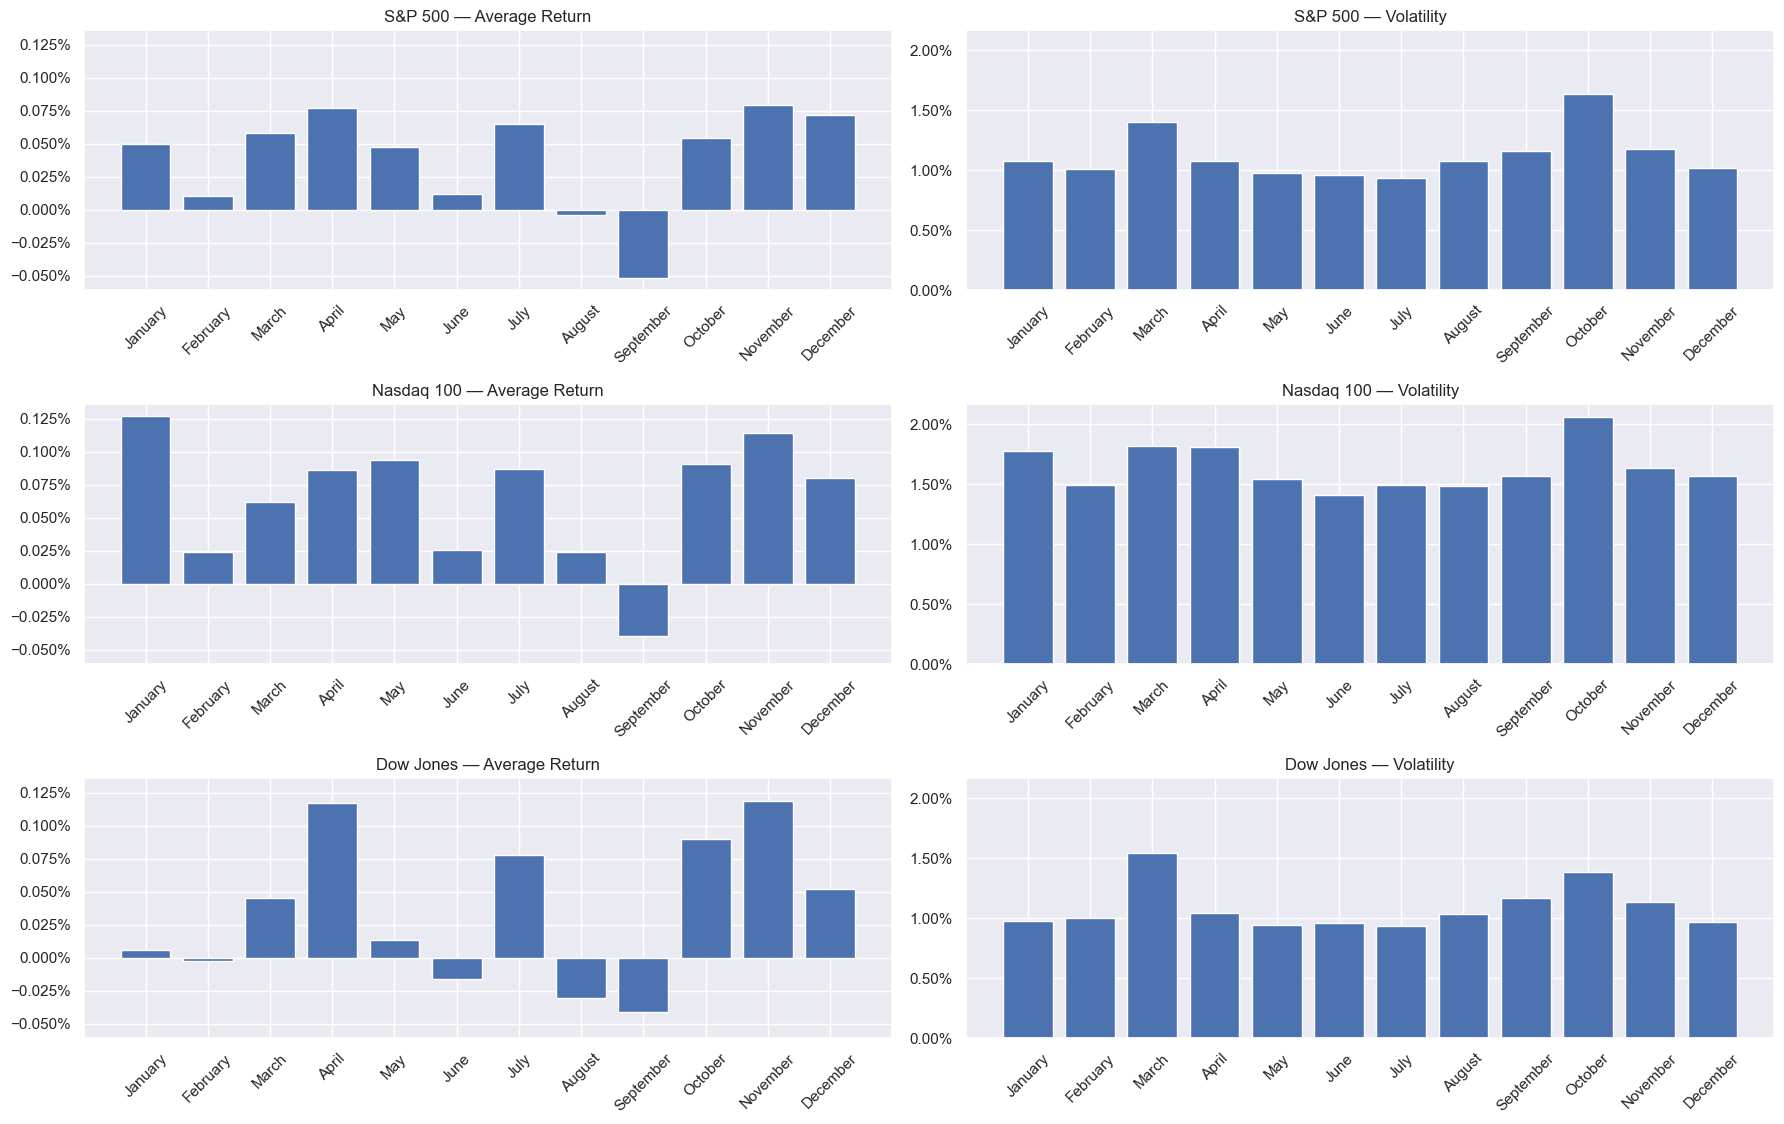

In [86]:
x = 40

month_avg = {}
month_vol = {}
month_volume = {}

for name, idx in indeces.items():
    # Évek meghatározása
    all_years = idx.index.year.unique()
    last_years = all_years[-x:] if len(all_years) >= x else all_years

    idx_recent = idx[idx.index.year.isin(last_years)].copy()
    idx_recent['Month'] = idx_recent.index.month

    average = idx_recent.groupby('Month')['Return'].mean()
    volatility = idx_recent.groupby('Month')['Return'].std()

    # Szám-hónap hozzárendelés
    average.index = average.index.map(lambda m: calendar.month_name[m])
    volatility.index = volatility.index.map(lambda m: calendar.month_name[m])

    month_avg[name] = average
    month_vol[name] = volatility

index_names = list(month_avg.keys())
months = month_avg[index_names[0]].index

fig, axs = plt.subplots(3, 2, figsize=(18, 12), sharey='col')

metrics = [
    ("Average Return", month_avg),
    ("Volatility", month_vol)
]

for i, idx_name in enumerate(index_names):
    for j, (metric_name, metric_dict) in enumerate(metrics):
        ax = axs[i, j]
        values = metric_dict[idx_name].values

        ax.bar(months, values)
        ax.set_title(f"{idx_name} — {metric_name}")
        ax.set_xticklabels(months, rotation=45)
        ax.grid(True, axis='y')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


A hozamok láthatóan erősek januárban, év végi adóoptimalizálás miatt, új pénz beáramlása miatt, és alapok viselkedése miatt. Ezután lecsillapodik a következő hónapokban. Április szintén az erősebb hónapokhoz tartozik Q1-es jelentések, USA-ban adóhónap miatt is. Nyár általában gyengébb illikviditás, makro narratívák hiánya, és általános "üresjárat miatt". Szeptember a legrosszabb hónap alapok viselkedése, makro kockázatok miatt. Ezután erősebb időszak következik, részben a korábbi gyenge hónapok miatti 'leárazott' részvényeket vásárló piaci résztvevők miatt.
Összesítve ez a ciklikusság adóoptimalizálás, negyedéves adatok, likviditási időszakok, intézményi viselkedési minták, és makrogazdasági ciklusok kombinációjával magyarázható.

A volatilitás tavasszal és ősszel magasabb, ami a makroadatok, és korábbi gyenge piac kihasználásával magyarázható

# Modellépítés Szektor predikcióra korreláció alapján

Adatok előkésítése után összehasonlítok több klasszifikációs modellt.

Optimális komponensszám meghatározása

In [213]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


X_std = StandardScaler().fit_transform(corr_matrix)
pca_full = PCA(n_components=None).fit(X_std)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

threshold = 0.95
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"A variancia {threshold*100:.0f}%-át magyarázó komponensek száma: {num_components}")

A variancia 95%-át magyarázó komponensek száma: 38


Adatok előkészítése

In [206]:
X_pca = PCA(n_components=38, random_state=random_state).fit_transform(X_std)
pca_df = pd.DataFrame(data=X_pca, index=corr_matrix.index)

cm = pd.merge(cluster_df.dropna(), all_sectors.dropna(), on="Stock", how="inner").dropna(subset=["Sector"]).copy()

X_filtered = pca_df.loc[cm['Stock']].values

X = X_filtered
y = cm['Sector'].values # Célváltozó

le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.20, random_state=random_state, stratify=y_encoded
)

#### Random Forest

In [207]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=random_state
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.3f}")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Accuracy: 0.808
                        precision    recall  f1-score   support

Communication Services       1.00      0.80      0.89         5
Consumer Discretionary       0.64      0.64      0.64        11
      Consumer Staples       1.00      1.00      1.00         8
                Energy       1.00      1.00      1.00         5
            Financials       0.65      0.93      0.76        14
           Health Care       0.83      0.77      0.80        13
           Industrials       0.69      0.73      0.71        15
Information Technology       0.88      0.93      0.90        15
             Materials       1.00      0.17      0.29         6
           Real Estate       1.00      0.83      0.91         6
             Utilities       1.00      1.00      1.00         6

              accuracy                           0.81       104
             macro avg       0.88      0.80      0.81       104
          weighted avg       0.83      0.81      0.80       104



#### Gradient boosting

In [208]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=random_state
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb:.3f}")

print(classification_report(y_test, y_pred_gb, target_names=le.classes_, zero_division=0))

Accuracy: 0.702
                        precision    recall  f1-score   support

Communication Services       0.60      0.60      0.60         5
Consumer Discretionary       1.00      0.55      0.71        11
      Consumer Staples       1.00      1.00      1.00         8
                Energy       1.00      0.40      0.57         5
            Financials       0.55      0.86      0.67        14
           Health Care       0.80      0.62      0.70        13
           Industrials       0.48      0.73      0.58        15
Information Technology       0.86      0.80      0.83        15
             Materials       0.67      0.33      0.44         6
           Real Estate       0.75      0.50      0.60         6
             Utilities       0.86      1.00      0.92         6

              accuracy                           0.70       104
             macro avg       0.78      0.67      0.69       104
          weighted avg       0.76      0.70      0.70       104



#### Support vector classifier

In [209]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    C=100,
    gamma='auto',
    random_state=random_state
)

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm:.3f}")

print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

Accuracy: 0.462
                        precision    recall  f1-score   support

Communication Services       1.00      0.60      0.75         5
Consumer Discretionary       1.00      0.18      0.31        11
      Consumer Staples       0.00      0.00      0.00         8
                Energy       1.00      0.20      0.33         5
            Financials       0.89      0.57      0.70        14
           Health Care       1.00      0.08      0.14        13
           Industrials       0.21      1.00      0.35        15
Information Technology       1.00      0.67      0.80        15
             Materials       1.00      0.17      0.29         6
           Real Estate       1.00      0.17      0.29         6
             Utilities       1.00      1.00      1.00         6

              accuracy                           0.46       104
             macro avg       0.83      0.42      0.45       104
          weighted avg       0.79      0.46      0.45       104



Összegzés:
 - Hierarchikus Klaszterezés: HCA eredményei adták a kiindulási hipotézist
    - Average Cluster Purity (0.7553) Magas belső kohézió, egy klaszterbe került részvények 75%-a azonos domináns szektorhoz tartozik.
    - Accuracy after mapping (0.5356) A klaszterek tiszták, de az Accuracy alacsony 53.6%. Ez megerősíti, hogy a korreláció szerinti csoportosítás finomabb, viselkedési csoportokat hoz létre, amelyek csak részben egyeznek meg a hivatalos szektorhatárokkal.
    - Adjusted Rand Index (0.2900) Az alacsony ARI alátámasztja, hogy a korreláció nem tökéletes szinonimája a szektoroknak.
 - Predikciós Modellek: Eek közül a Random Forest működött a legjobban minden metrika szerint, ennek accuracy-je: 80.8% .
    - F1 score: Jól Elkülönülő Szektorok (Magas F1): Consumer Staples, Energy, Utilities, Information Technology, Real Estate. Ezek a szektorok mutatják a, legegyedibb korrelációs profilt, ami megerősíti a HCA 75%-os tisztasági eredményét. Alacsony F1: Consumer Discretionary, Financials, Industrials. Ezek a szektorok nagyobb átfedésben vannak más szektorokkal